# Link Analysis
Conducting a link analysis of a network graph involves identifying and analyzing the link within the graph. 

In [7]:
import pandas as pd
import numpy as np
from os.path import join
import os


from dotenv import load_dotenv
load_dotenv()  

path = os.environ['DATA_DIRECTORY']
covalent_key = os.environ['COVALENTHQ_API_KEY']
df_snapshots = pd.read_csv('../data/snapshot_selection.csv')
df_tokens = pd.read_csv("../data/final_token_selection.csv")


In [8]:
import sys
sys.path.append('..') 

from src.analysis.link_analysis import * 
from src.visualisations.link_analysis_visualisations import * 

## Create dataframes for each metrics

In [9]:
# Specify the path to the file containing the saved cliques data
links_data_path = join(path, '../output/links/metrics/links_data_5e-06.pkl') # load reference value
links_data = LinkData(links_data_path)


# Use the metric_names attribute from CliquesData
metric_names = links_data.metric_names


# Initialize an empty dictionary to store DataFrames for each metric
metric_dataframes = {'sample': {},'sample_population': {},'pvalues': {}, 'sample_directional':{}, 'sample_population_directional':{}, 'pvalues_directional':{}}

# Create DataFrames for each metric
for group in ['sample', 'sample_population', 'pvalues', 'sample_directional', 'sample_population_directional', 'pvalues_directional']:
    for metric_name in metric_names:
        metric_dataframes[group][metric_name] = links_data.get_metric_data(group, metric_name)
        

## Figure Generation

### Fig: Size of Clique 

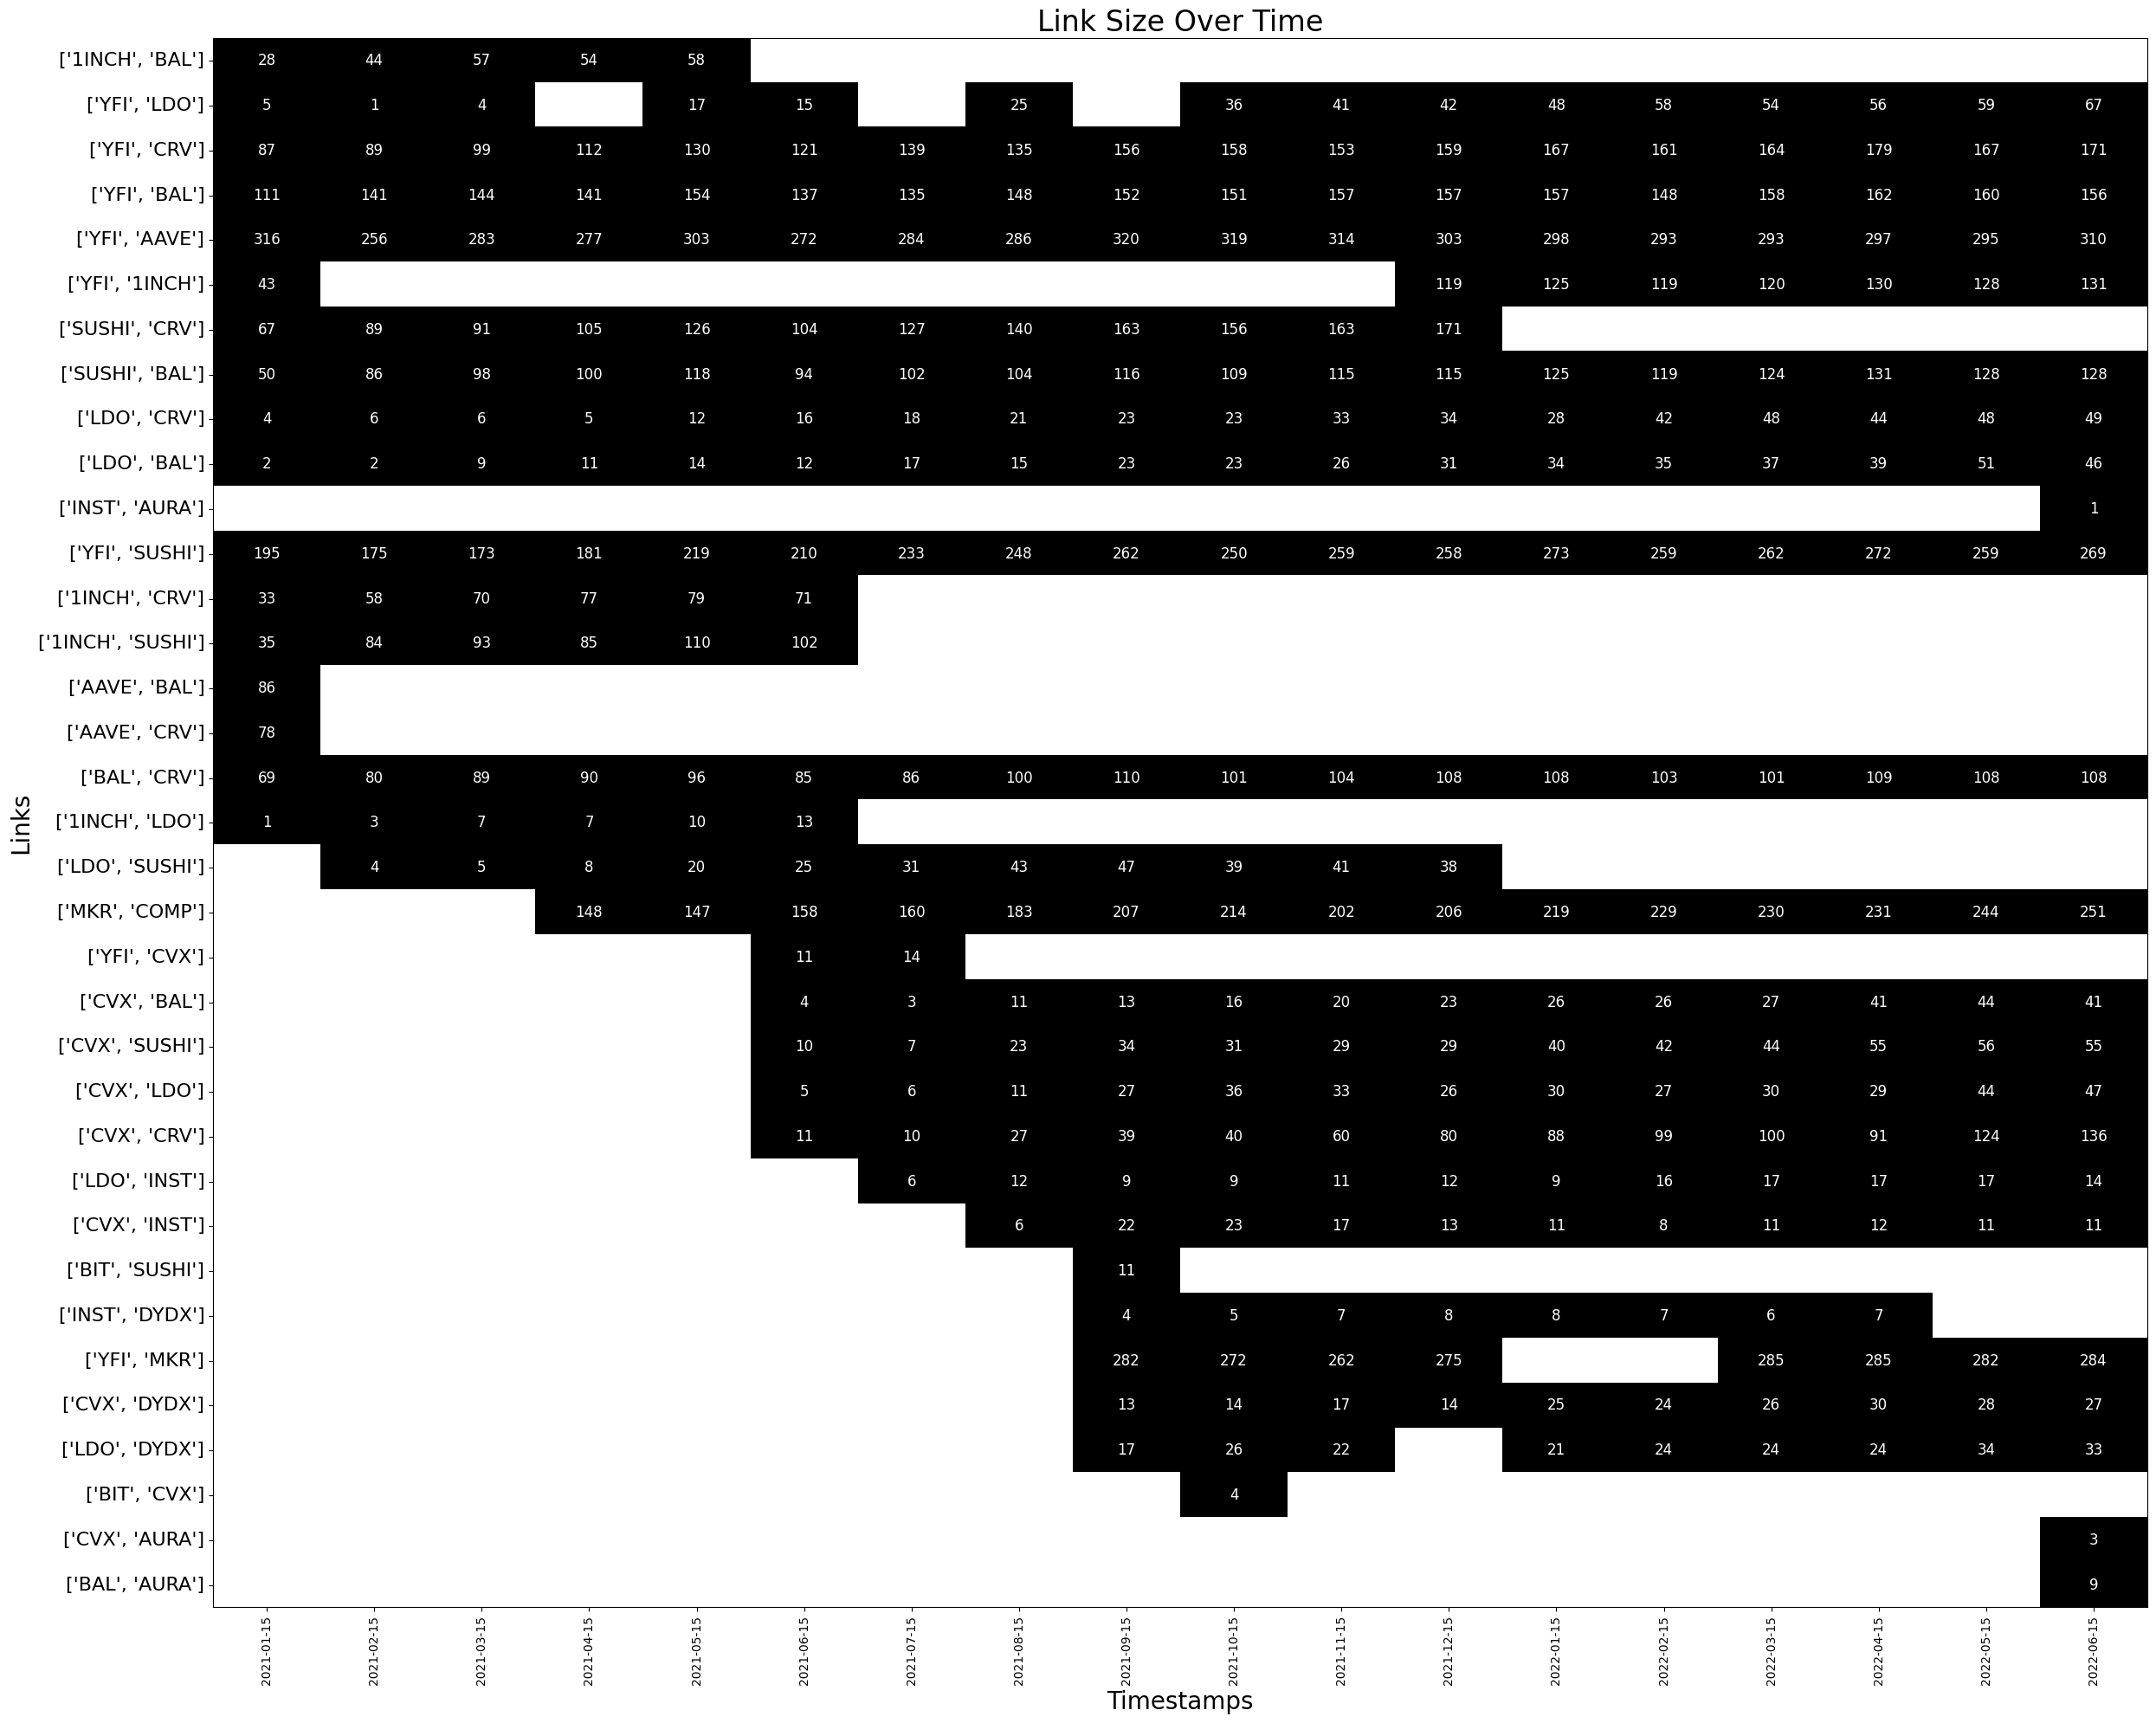

In [10]:
plot_link_size_over_time(metric_dataframes, group='sample', output_path="../output/links/", save=True, show=True)

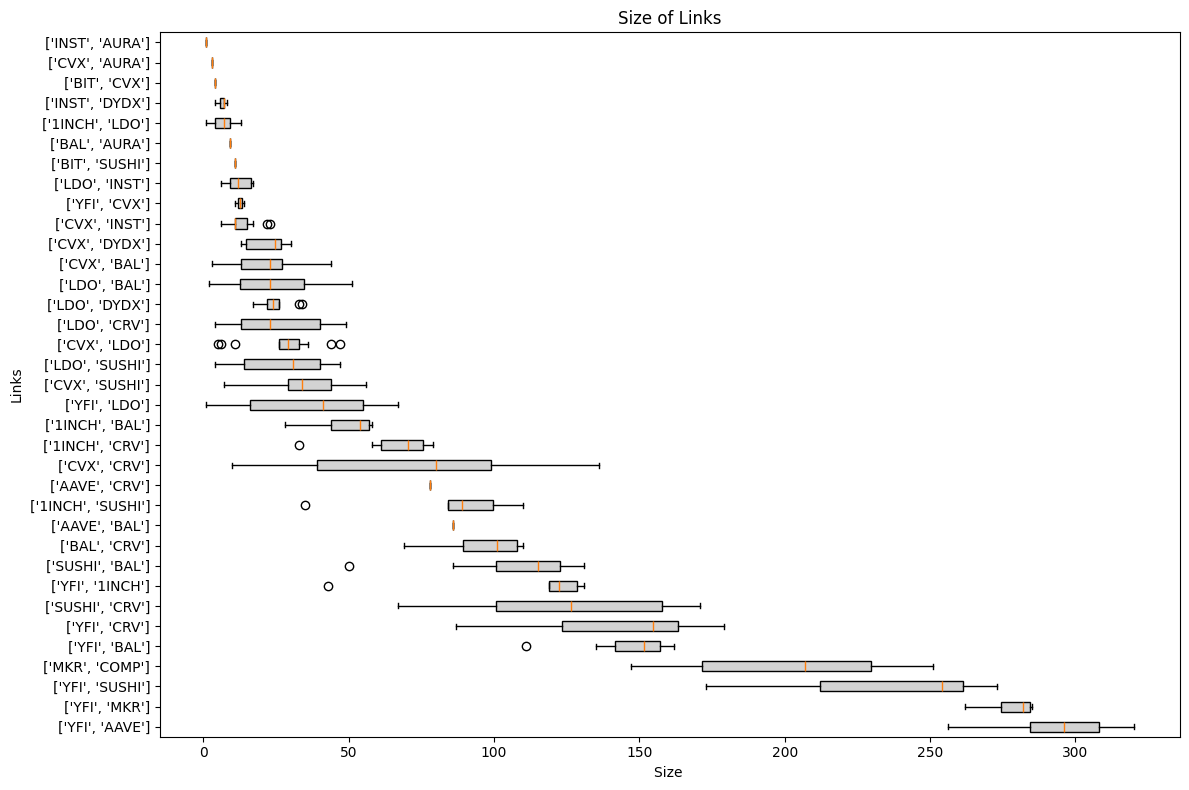

In [11]:
plot_boxplot_with_significance(metric_dataframes, metric='size', unit='', group='sample', output_path="../output/links/", save=True, show=True)


### Fig: link growth over time 

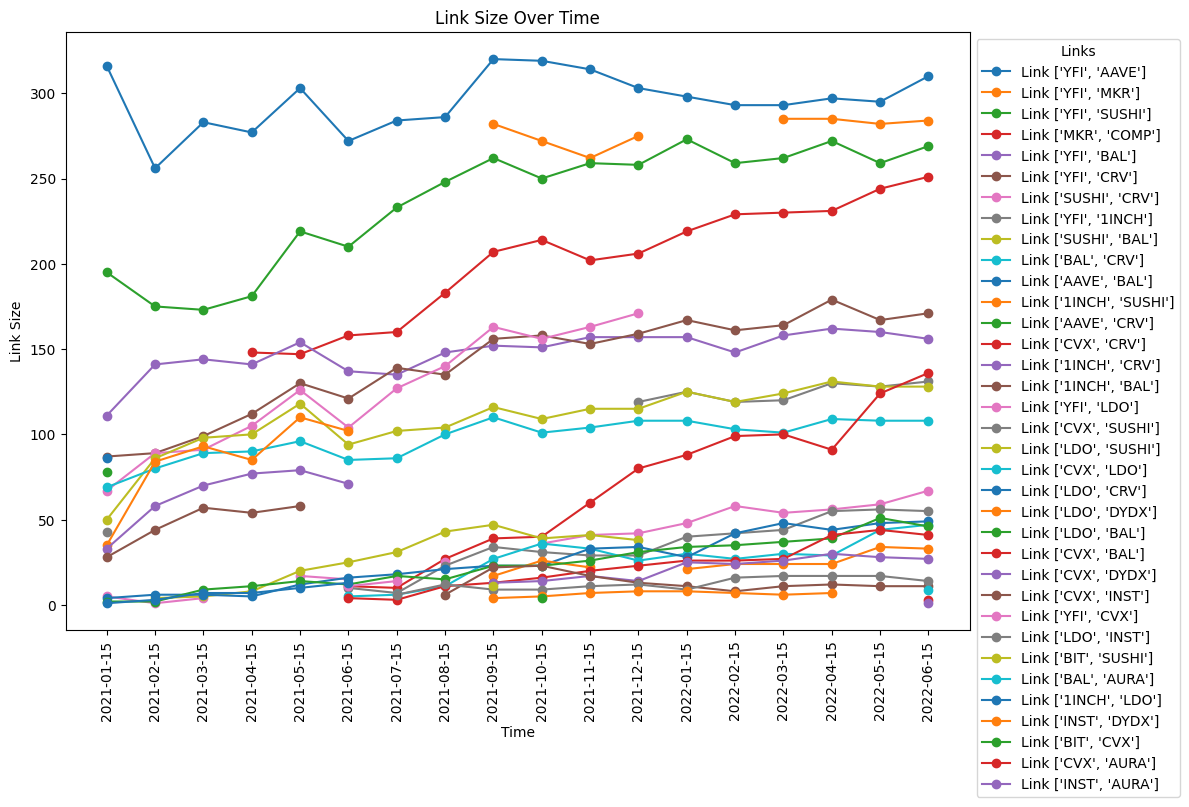

In [12]:
plot_link_growth_over_time(metric_dataframes, group='sample', output_path="../output/links/", save=True, show=True)

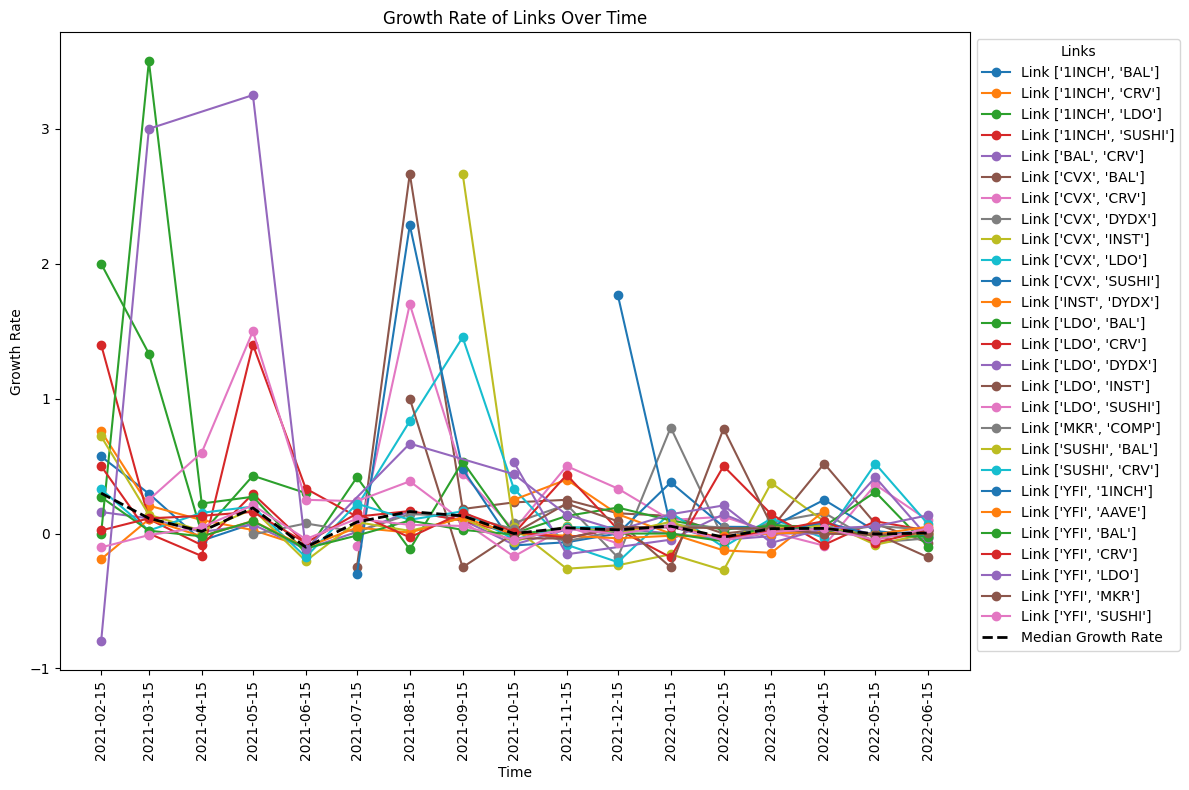

In [13]:
plot_link_growth_rate_over_time(metric_dataframes, group='sample', output_path="../output/links/", save=False, show=True)

/home/xm3van/research-project-erc20-governance/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/xm3van/research-project-erc20-governance/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


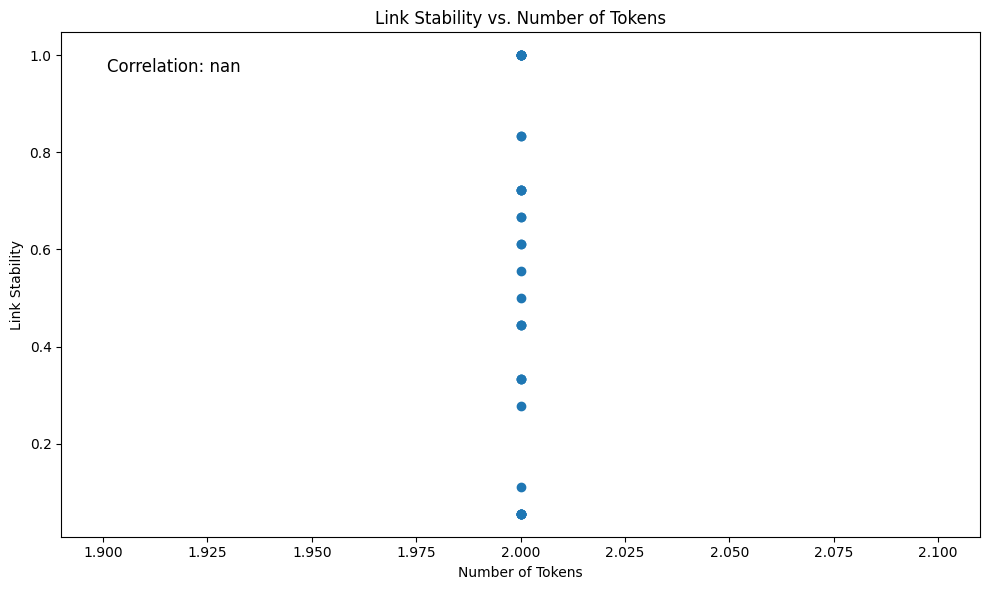

In [14]:
plot_link_stability_vs_no_of_tokens(metric_dataframes, group='sample', output_path="../output/links/", save=False, show=True)

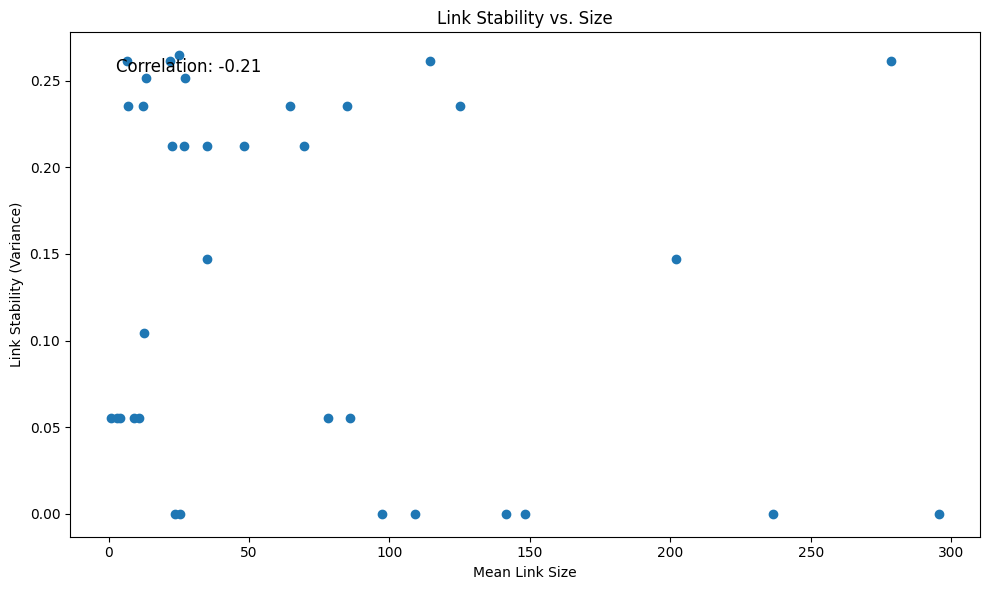

In [15]:
plot_link_stability_vs_size(metric_dataframes, group='sample', output_path="../output/links/", save=False, show=True)

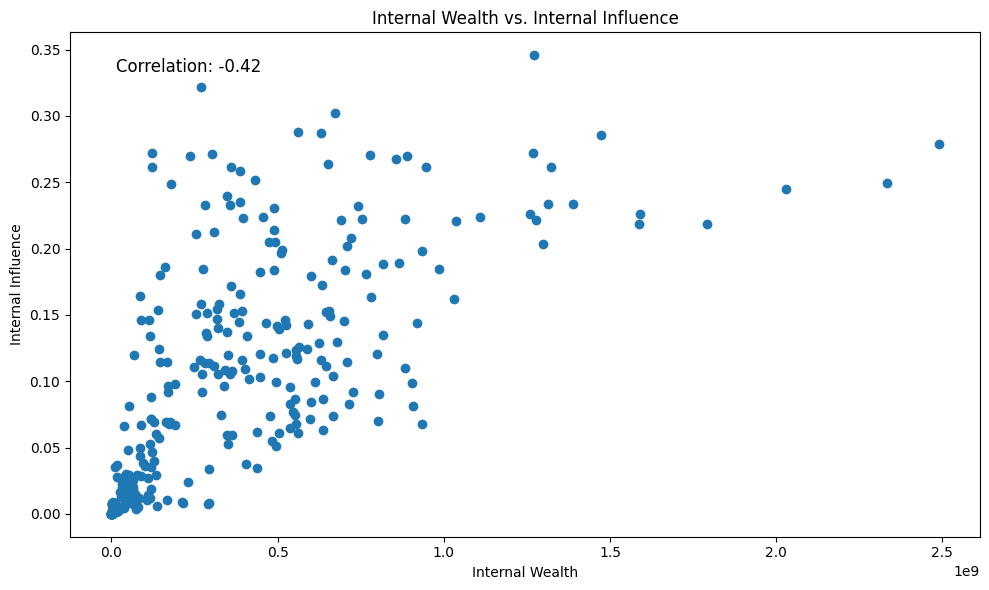

In [16]:
import matplotlib.pyplot as plt

def plot_wealth_vs_influence(metric_dataframes, group='sample', output_path="output/metrics/", save=True, show=True):
    # Constants for aesthetics
    FIG_SIZE = (10, 6)

    # Extract data
    wealth = metric_dataframes[group]['internal_wealth']
    influence = metric_dataframes[group]['internal_influence']

    # Prepare figure and axis for plotting
    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # Create a scatter plot of internal influence versus internal wealth
    ax.scatter(wealth, influence)
    
    # Labels and Title
    ax.set_xlabel("Internal Wealth")
    ax.set_ylabel("Internal Influence")
    ax.set_title("Internal Wealth vs. Internal Influence")

    # Show the correlation value on the plot
    correlation = wealth.mean().corr(influence.mean())
    ax.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=ax.transAxes,
            fontsize=12, verticalalignment='top')

    plt.tight_layout()

    # Save or show the figure
    if save:
        plt.savefig(f"{output_path}/wealth_vs_influence_{group}.png", bbox_inches='tight')
    if show:
        plt.show()

# Example usage:
plot_wealth_vs_influence(metric_dataframes, save=False)


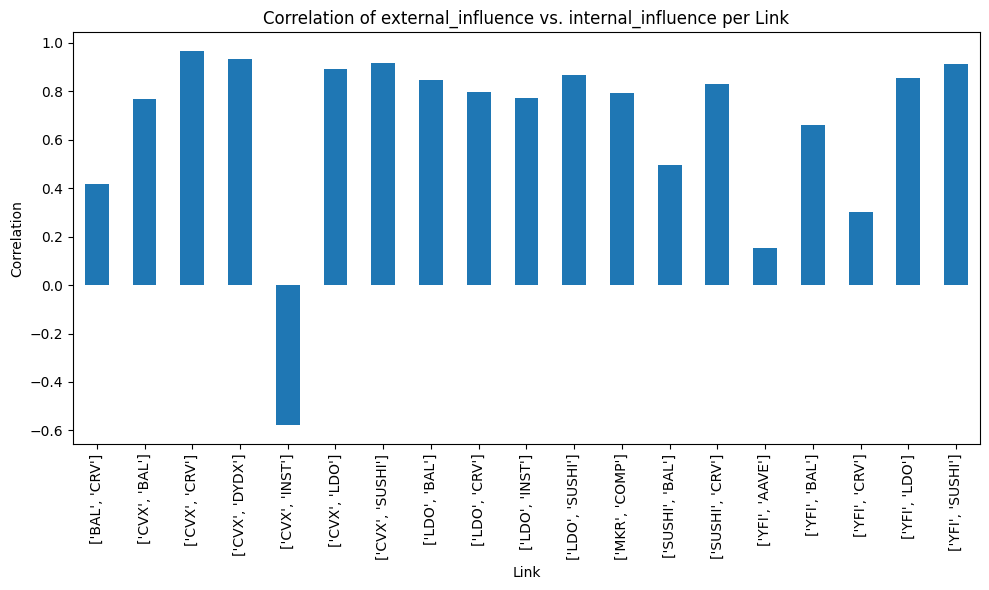

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_linkwise_correlation(metric_dataframes,vs=['internal_wealth', 'internal_influence'], group='sample', min_occurrences=1,output_path="output/metrics/", save=True, show=True):
    # Constants for aesthetics
    FIG_SIZE = (10, 6)

    # Extract data
    wealth_df = metric_dataframes[group][vs[0]]
    influence_df = metric_dataframes[group][vs[1]]

    # Normalize the datetime format for both DataFrames
    wealth_df.columns = pd.to_datetime(wealth_df.columns).normalize()
    influence_df.columns = pd.to_datetime(influence_df.columns).normalize()

    # Initialize a list to store correlations
    correlations = []

    # Iterate over each link (row)
    for link in wealth_df.index:
        wealth = wealth_df.loc[link]
        influence = influence_df.loc[link]

        # Align the indices of wealth and influence without dropping NaNs
        aligned_data = pd.concat([wealth, influence], axis=1)
        
        # Rename columns for clarity
        aligned_data.columns = vs
        
        # Drop rows where both wealth and influence are NaN
        aligned_data = aligned_data.dropna(how='all')

        # Ensure there are enough points to compute correlation
        if aligned_data.shape[0] > min_occurrences:
            # Drop remaining NaNs after alignment
            aligned_data = aligned_data.dropna()

            if not aligned_data.empty:
                wealth_aligned = aligned_data[vs[0]]
                influence_aligned = aligned_data[vs[1]]

                # Compute correlation for the current link
                correlation = wealth_aligned.corr(influence_aligned)
                correlations.append(correlation)
            else:
                correlations.append(None)
        else:
            correlations.append(None)

    # Convert the list of correlations to a Series and drop non-numeric values
    correlation_series = pd.Series(correlations, index=wealth_df.index)
    correlation_series = correlation_series.dropna()

    # Prepare figure and axis for plotting
    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # Create a bar plot of correlations
    correlation_series.plot(kind='bar', ax=ax)
    
    # Labels and Title
    ax.set_xlabel("Link")
    ax.set_ylabel("Correlation")
    ax.set_title(f"Correlation of {vs[0]} vs. {vs[1]} per Link")

    plt.tight_layout()

    # Save or show the figure
    if save:
        plt.savefig(f"{output_path}/wealth_vs_influence_linkwise_{group}.png", bbox_inches='tight')
    if show:
        plt.show()

# Example usage:
# plot_linkwise_wealth_vs_influen




# Example usage:
plot_linkwise_correlation(metric_dataframes,vs=['external_influence', 'internal_influence'],min_occurrences=9, save=False)


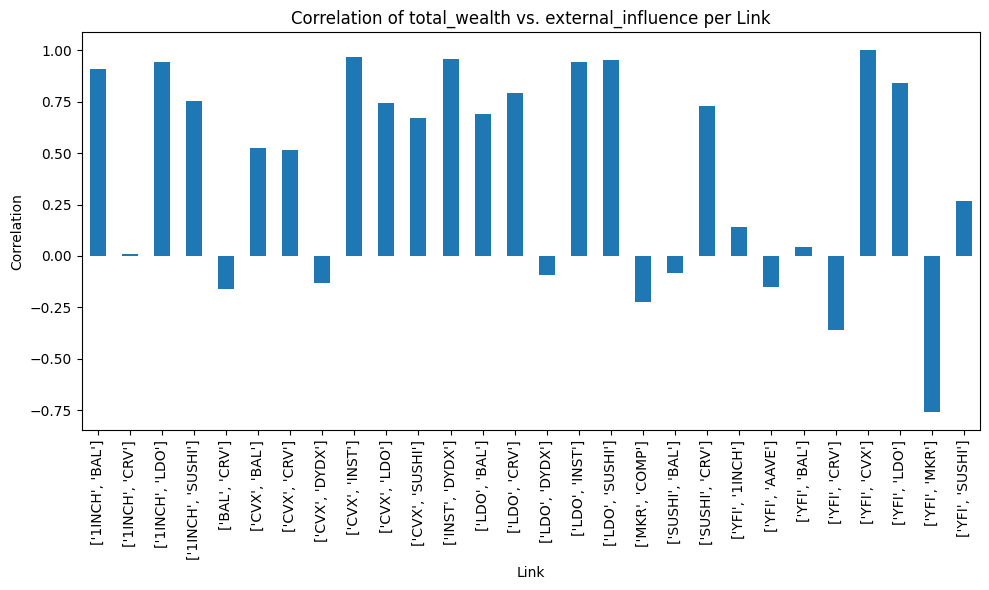

In [18]:
plot_linkwise_correlation(metric_dataframes,vs=['total_wealth', 'external_influence'], save=False)


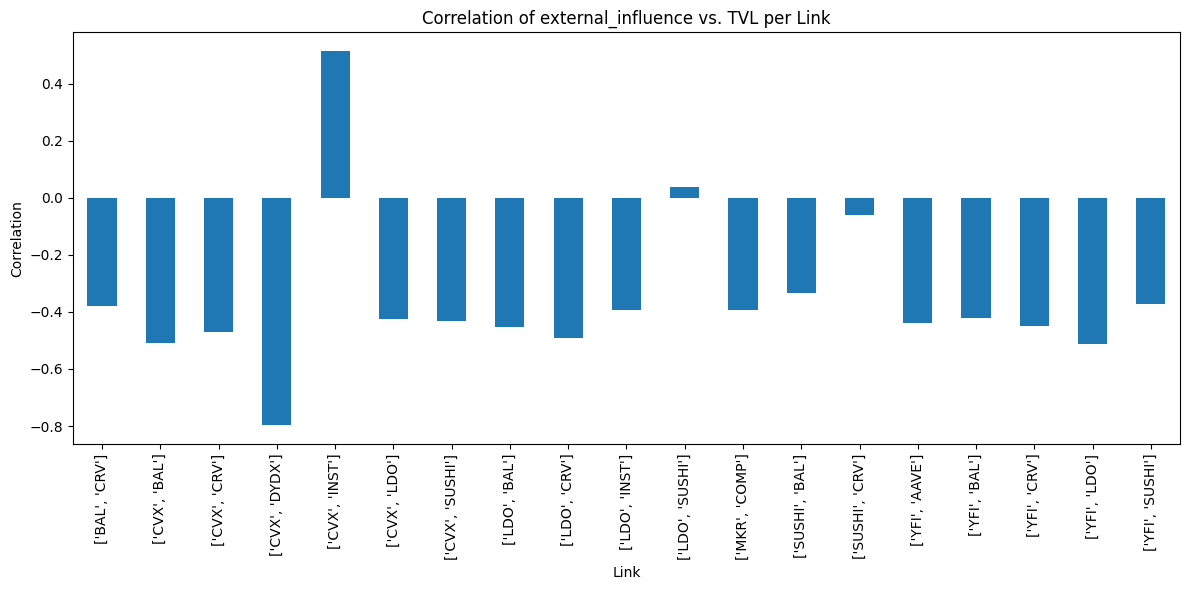

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import json

def plot_linkwise_correlation_vs_tvl(metric_dataframes, tvl_data_path, metric='internal_influence', output_path="output/", min_occurrences=1, save=True, show=True):
    # Extract internal influence data
    influence_df = metric_dataframes['sample'][metric]

    # Normalize the datetime format for influence DataFrame
    influence_df.columns = pd.to_datetime(influence_df.columns).normalize()

    # Load TVL data
    with open(tvl_data_path, 'r') as file:
        tvl_data = json.load(file)
    tvl_df = pd.DataFrame(tvl_data)
    tvl_df['date'] = pd.to_datetime(tvl_df['date'], unit='s')#.normalize()
    tvl_df.set_index('date', inplace=True)

    # Initialize a list to store correlations
    correlations = []

    # Iterate over each link (row)
    for link in influence_df.index:
        influence = influence_df.loc[link]

        # Align the indices of influence and TVL
        aligned_data = pd.concat([influence, tvl_df['tvl'].pct_change(1)], axis=1, join='inner').dropna()

        if not aligned_data.empty and aligned_data.shape[0] > min_occurrences:
            influence_aligned = aligned_data.iloc[:, 0]
            tvl_aligned = aligned_data.iloc[:, 1]

            # Compute correlation for the current link
            correlation = influence_aligned.corr(tvl_aligned)
            correlations.append(correlation)
        else:
            correlations.append(None)

    # Convert the list of correlations to a Series
    correlation_series = pd.Series(correlations, index=influence_df.index).dropna()

    # Prepare figure and axis for plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create a bar plot of correlations
    correlation_series.plot(kind='bar', ax=ax)
    
    # Labels and Title
    ax.set_xlabel("Link")
    ax.set_ylabel("Correlation")
    ax.set_title(f"Correlation of {metric} vs. TVL per Link")

    plt.xticks(rotation=90)
    plt.tight_layout()

    # Save or show the figure
    if save:
        plt.savefig(f"{output_path}/influence_vs_tvl_correlation.png", bbox_inches='tight')
    if show:
        plt.show()

# Example usage:
# plot_linkwise_correlation

# To-do: add in error bands


# Example usage:
plot_linkwise_correlation_vs_tvl(metric_dataframes, metric='external_influence', min_occurrences=9, tvl_data_path='../data/response_1722835427100.json', save=False, show=True)


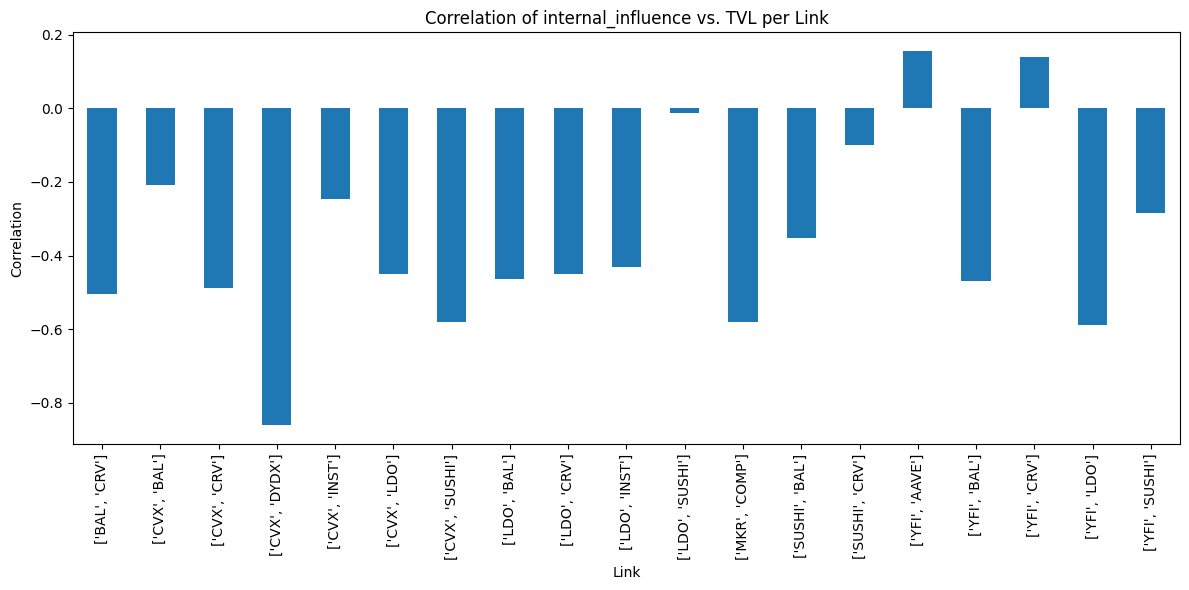

In [20]:
plot_linkwise_correlation_vs_tvl(metric_dataframes, metric='internal_influence', min_occurrences=9, tvl_data_path='../data/response_1722835427100.json', save=False, show=True)


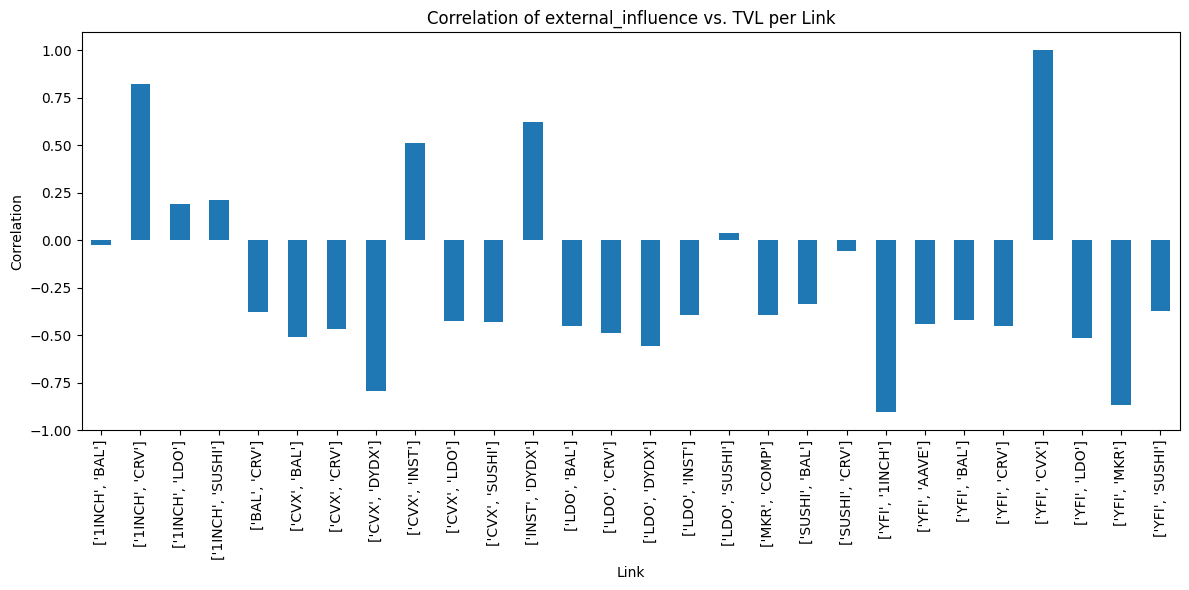

In [21]:
plot_linkwise_correlation_vs_tvl(metric_dataframes, metric='external_influence', tvl_data_path='../data/response_1722835427100.json', save=False, show=True)


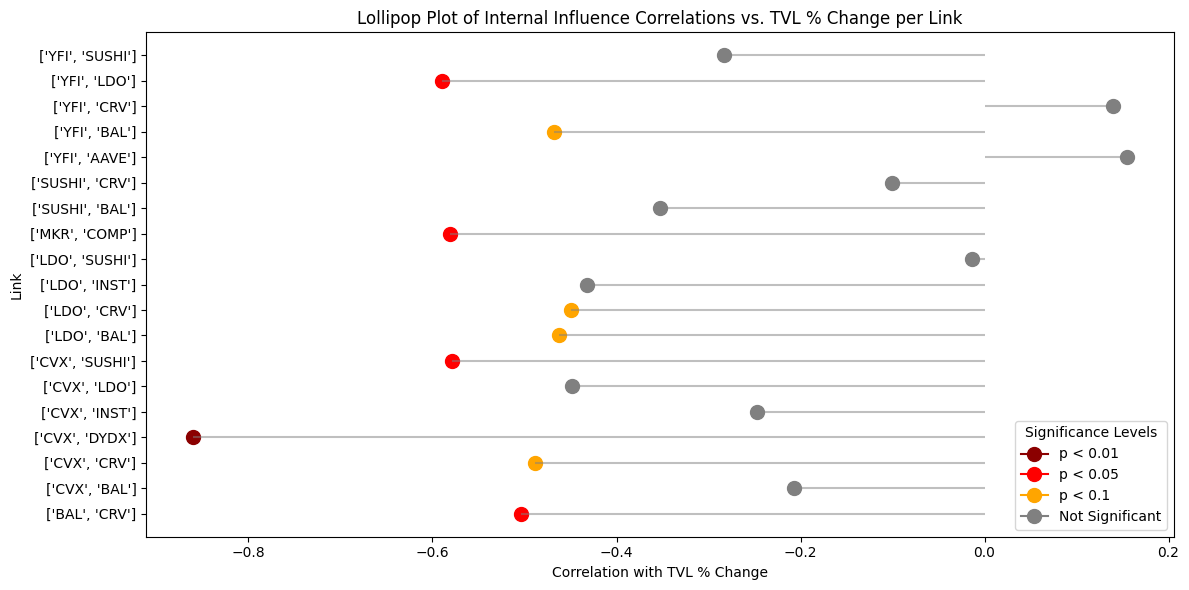

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from scipy.stats import pearsonr
import matplotlib.lines as mlines

# Helper function to map p-values to significance colors
def pval_to_color(pval):
    if pval < 0.01:
        return 'darkred'
    elif pval < 0.05:
        return 'red'
    elif pval < 0.1:
        return 'orange'
    else:
        return 'gray'

def plot_lollipop_correlation_vs_tvl(metric_dataframes, tvl_data_path, metric='internal_influence', output_path="output/", min_occurrences=1, save=True, show=True):
    # Extract internal influence data
    influence_df = metric_dataframes['sample'][metric]

    # Normalize the datetime format for influence DataFrame
    influence_df.columns = pd.to_datetime(influence_df.columns).normalize()

    # Load TVL data
    with open(tvl_data_path, 'r') as file:
        tvl_data = json.load(file)
    tvl_df = pd.DataFrame(tvl_data)
    tvl_df['date'] = pd.to_datetime(tvl_df['date'], unit='s')
    tvl_df.set_index('date', inplace=True)

    # Initialize a list to store correlations and p-values
    correlations = []
    pvals = []

    # Iterate over each link (row)
    for link in influence_df.index:
        influence = influence_df.loc[link]

        # Align the indices of influence and TVL percentage changes
        aligned_data = pd.concat([influence, tvl_df['tvl'].pct_change(1)], axis=1, join='inner').dropna()

        if not aligned_data.empty and aligned_data.shape[0] > min_occurrences:
            influence_aligned = aligned_data.iloc[:, 0]
            tvl_aligned = aligned_data.iloc[:, 1]

            # Compute correlation and p-value for the current link
            correlation, pval = pearsonr(influence_aligned, tvl_aligned)
            correlations.append(correlation)
            pvals.append(pval)
        else:
            correlations.append(None)
            pvals.append(None)

    # Convert the list of correlations and p-values to a DataFrame
    result_df = pd.DataFrame({
        'Correlation': correlations,
        'P-value': pvals
    }, index=influence_df.index).dropna()

    # Prepare figure and axis for plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create the lollipop plot
    ax.hlines(y=result_df.index, xmin=0, xmax=result_df['Correlation'], color='gray', alpha=0.5)
    
    # Add the dots with significance colors
    for i, (corr, pval) in enumerate(zip(result_df['Correlation'], result_df['P-value'])):
        color = pval_to_color(pval)
        ax.scatter(corr, result_df.index[i], color=color, s=100)  # s controls the size of the dot

    # Update axis labels and title to reflect percentage change
    ax.set_xlabel("Correlation with TVL % Change")
    ax.set_ylabel("Link")
    ax.set_title(f"Lollipop Plot of {metric.replace('_',' ').title()} Correlations vs. TVL % Change per Link")

    # Create custom legend for significance levels
    darkred_patch = mlines.Line2D([], [], color='darkred', marker='o', markersize=10, label='p < 0.01')
    red_patch = mlines.Line2D([], [], color='red', marker='o', markersize=10, label='p < 0.05')
    orange_patch = mlines.Line2D([], [], color='orange', marker='o', markersize=10, label='p < 0.1')
    gray_patch = mlines.Line2D([], [], color='gray', marker='o', markersize=10, label='Not Significant')

    # Add the legend to the plot
    ax.legend(handles=[darkred_patch, red_patch, orange_patch, gray_patch], loc='lower right', title='Significance Levels')

    plt.tight_layout()


    # Save or show the figure
    if save:
        plt.savefig(f"{output_path}/lollipop_{metric}_vs_tvl_correlation_with_legend.png", bbox_inches='tight')
    if show:
        plt.show()

# Example usage:
plot_lollipop_correlation_vs_tvl(metric_dataframes, metric='internal_influence', min_occurrences=9, output_path='../output/links', tvl_data_path='../data/response_1722835427100.json', save=True, show=True)


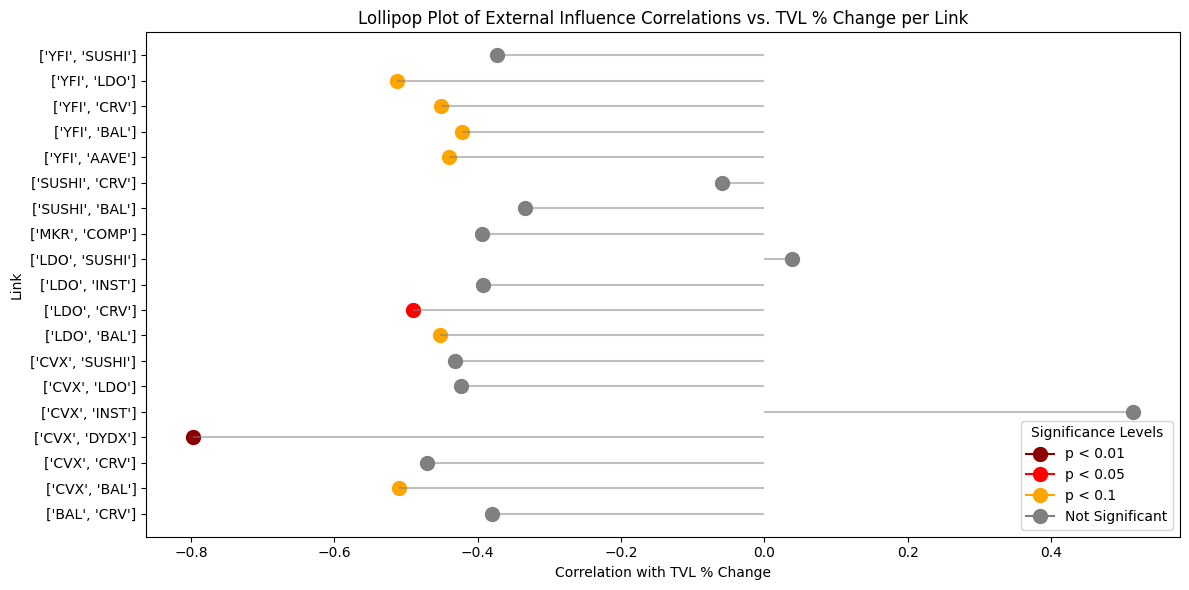

In [23]:
plot_lollipop_correlation_vs_tvl(metric_dataframes, metric='external_influence', min_occurrences=9,output_path='../output/links', tvl_data_path='../data/response_1722835427100.json', save=True, show=True)


### Fig: link_size vs total_influence 

In [24]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# from os.path import join

# def plot_clique_size_influence_correlation(metric_dataframes, method='upper_bound', group='sample', output_path="output/cliques/", save=True, show=True):
#     # Define dfs
#     df_size = metric_dataframes[method][group]['size_clique']
#     df_influence = metric_dataframes[method][group]['total_influence']

#     # Calculate correlations for each timestamp
#     correlations = df_size.corrwith(df_influence, axis=0)

#     # Plotting the correlations
#     plt.figure(figsize=(10, 5))
#     plt.plot(correlations.index, correlations, marker='o', linestyle='-')
#     plt.xlabel('Timestamps', fontsize=12)
#     plt.ylabel('Correlation between Clique Size and Total Influence', fontsize=12)
#     plt.title(f'[{method.upper()}]: Correlation of Clique Size and Total Influence Over Time', fontsize=14)
#     plt.grid(True)

#     plt.xticks(rotation=90)  # Rotate x-tick labels by 90 degrees

#     # Save the plot to the specified output path
#     if save:
#         plt.savefig(join(output_path, f'clique_size_influence_correlation_{method}_{group}.png'))

#     if show:
#         plt.show()
#     else:
#         plt.close()

# # Example usage
# plot_clique_size_influence_correlation(metric_dataframes, method='upper_bound', group='sample', save=False, show=True)


### Fig: total_influence

In [25]:
import json
file_path = '../data/response_1722835427100.json'
with open(file_path, 'r') as file:
    tvl_data = json.load(file)
tvl_df = pd.DataFrame(tvl_data)
tvl_df['date'] = pd.to_datetime(tvl_df['date'], unit='s')
tvl_df.set_index('date', inplace=True)

In [26]:
metric_dataframes['sample']['internal_influence'].columns

DatetimeIndex(['2021-01-15', '2021-02-15', '2021-03-15', '2021-04-15',
               '2021-05-15', '2021-06-15', '2021-07-15', '2021-08-15',
               '2021-09-15', '2021-10-15', '2021-11-15', '2021-12-15',
               '2022-01-15', '2022-02-15', '2022-03-15', '2022-04-15',
               '2022-05-15', '2022-06-15'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [27]:
# tvl_df[tvl_df.index in list(pd.to_datetime(metric_dataframes['sample']['internal_influence'].columns))]


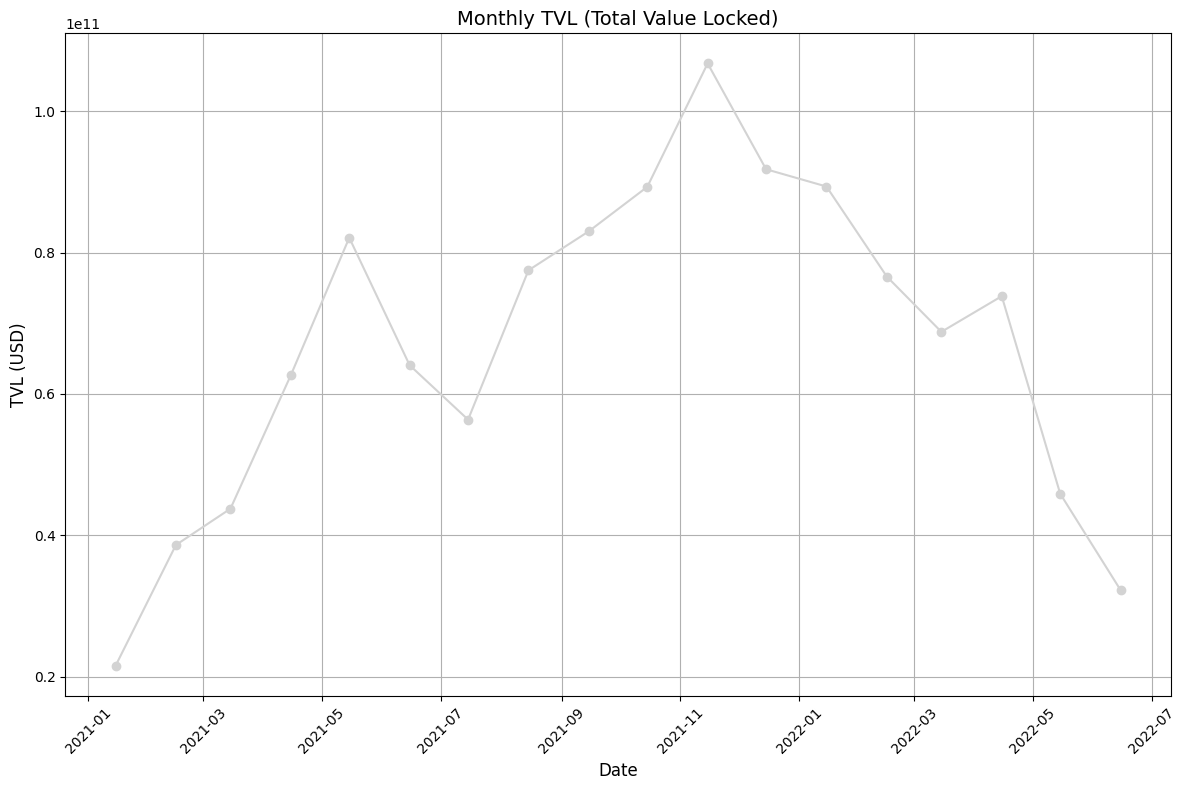

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import json

def plot_monthly_tvl(tvl_data_path, output_path="../output/tvl_monthly_chart.png", save=False, show=True):

    date_range = metric_dataframes['sample']['internal_influence'].columns

    # Load TVL data
    with open(tvl_data_path, 'r') as file:
        tvl_data = json.load(file)
    tvl_df = pd.DataFrame(tvl_data)
    tvl_df['date'] = pd.to_datetime(tvl_df['date'], unit='s')
    tvl_df.set_index('date', inplace=True)
    

    df = metric_dataframes['sample']['internal_influence']
    # Convert index to datetime if not already
    if not isinstance(df.columns, pd.DatetimeIndex):
        df.columns = pd.to_datetime(df.columns)
    # Resample to monthly values
    monthly_tvl = tvl_df[tvl_df.index.isin(pd.to_datetime(df.columns))]

    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.plot(monthly_tvl.index, monthly_tvl, marker='o', linestyle='-', color='lightgray')
    # plt.fill_between(monthly_tvl.index, monthly_tvl, color='cyan', alpha=0.1)
    plt.title('Monthly TVL (Total Value Locked)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('TVL (USD)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    
    # Save and/or show the plot
    if save:
        plt.savefig(output_path, bbox_inches='tight')
    if show:
        plt.show()

# Example call to the function
plot_monthly_tvl(tvl_data_path='../data/response_1722835427100.json', save=True, show=True)


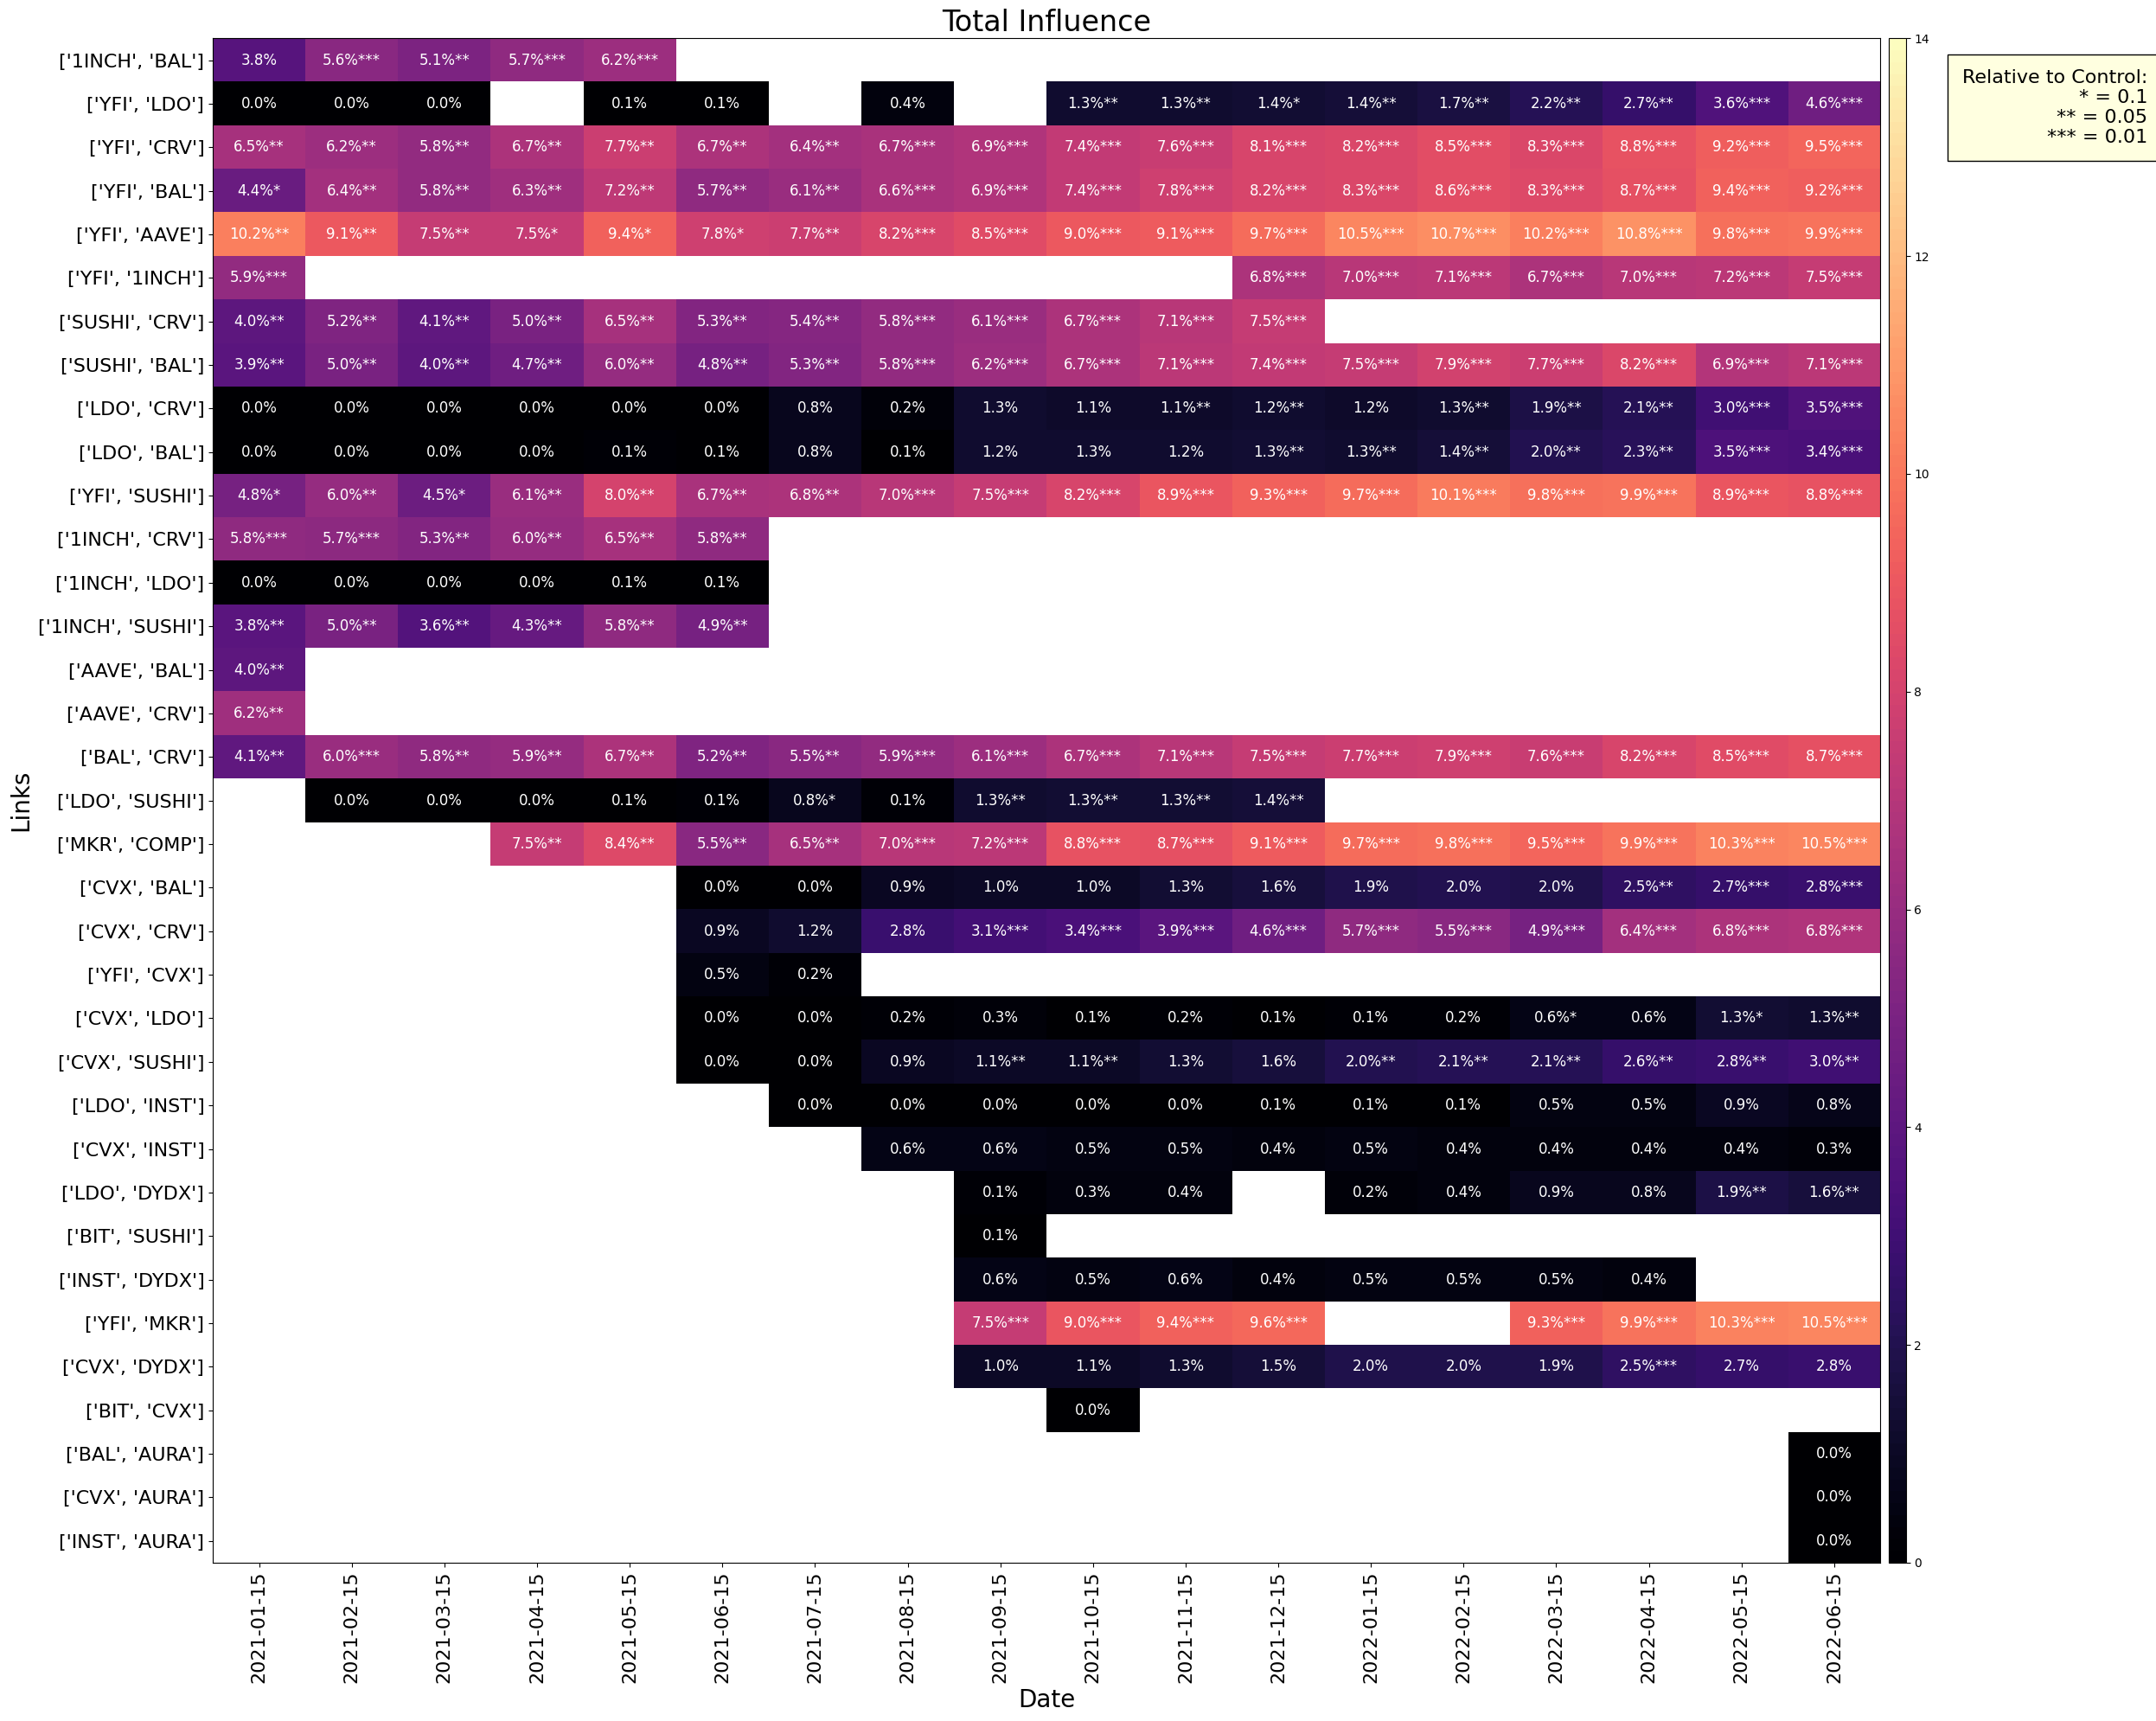

In [30]:
plot_heatmap_chart(metric_dataframes, metric_name='total_influence', pct=True,  log=False, output_path="../output/links/", save=True, show=True)

Observations: 
1. **High Influence in Specific Links**: Certain cliques, such as those involving YFI (Yearn Finance), consistently show high influence over time. For instance, links like ['YFI', 'LDO'], ['YFI', 'AAVE'],  ['YFI', 'MKR'] and ['YFI', 'SUSHI'] exhibit a significant and persistent influence, indicating that addresses associated with YFI hold considerable governance power across multiple protocols. 

2. **Central Role of YFI**: YFI seems to act as a central node within the network, linking to many other tokens. This central position might be due to Yearn Finance's role as a yield aggregator, which integrates with various DeFi protocols to optimize returns for its users. YFI holders seem to hold several other token making them influential in term of prevlant goverance power in a lot of protocol form persistent statstically validated link in the network projects and holding significant control relative to permuted samples.

3. **Statistical Significance**: The heatmap indicates statistical significance for various cliques with stars denoting different significance levels (p < 0.01, p < 0.05, and p < 0.1). This suggests that the observed influence of these cliques relative to samples taken from all token hold, meaningfully more. Link involving INSTA display high values for 2021-04-15 and 2021-05-15, yet are not significant because the the token was launched and later on distributed, meaning that the permutation test scored high permuted control samples. 

4. **Temporal Changes**: There are visible changes in influence over time. For example, the influence of the ['MKR', 'COMP'], ['YFI', 'AAVE'], ['YFI', 'SUSHI'] and ['SUSHI', '1INCH'] links starts to rise significantly from mid-2021 peking close to controlling up to 18.8% of prevlant goverance power on the network, suggesting a shift in a higher concentration of these tokens in the link. The concentration falls as the projections progress. Given these snapshot conincide prior to a market down turn this may suggest that these token where held with believe of price appreication rather than to participate in governance and where sold off with the market downturn to a base level held by potential user either believing in the long term investment or actual governance participants. 

5. **Increase in Control Over Time**: Many link defining wallet show an increasing trend in their influence over time. This could indicate a growing conentration in Link holding the respective token (i.e. see  ['CVX', 'CRV'],  ['SUSHI', 'BAL'],  ['YFI', 'MKR'],  ['LDO', 'CRV'],  ['YFI', 'CRV'],  ['YFI', 'BAL'],  ['CRV', 'DYDX'] ) of governance power as certain addresses accumulate more tokens or as new influential addresses enter the network.


### Fig: gini_total_influence

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as patches

def plot_boxplot(metric_dataframes, metric, unit, group='sample',pval_group='pvalues', output_path="output/links/", custom_index='internal_influence',  min_occurrences=0, significance=False, save=True, show=True):
    # Constants for aesthetics
    FIG_SIZE = (12, 8)
    COLOR_MAP = {'non-significant': 'lightgray', '0.05': 'yellow', '0.01': 'orange', '0.001': 'red'}
    BASE_COLOR = 'lightgray'


    # Extract data
    df = metric_dataframes[group][metric]
    
    # Load p_values to control
    df_pvalues = metric_dataframes[pval_group][metric]      

    # FILTER OCCURANCES 
    df = df[df.count(axis=1) >= min_occurrences]
    df_pvalues = df_pvalues.loc[df.index]

    # Sort links by average influence
    if custom_index != '':
        links_order = metric_dataframes[group][custom_index].mean(axis=1).sort_values(ascending=False).index
    else: 
        links_order = df.mean(axis=1).sort_values(ascending=False).index

    df = df.reindex(links_order)
    df_pvalues = df_pvalues.reindex(links_order)

    # Prepare figure and axis
    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # Create boxplot data
    boxplot_data = [df.loc[link].dropna() for link in links_order]
    boxplot = ax.boxplot(boxplot_data, vert=False, patch_artist=True)

    # Color and annotate based on significance
    if significance:
        for i, link in enumerate(links_order):
            p_values = df_pvalues.loc[link].dropna()
            # Determine the most common significance level based on mode
            try: 
                significance_level = p_values.apply(lambda x: '0.001' if x < 0.001 else ('0.01' if x < 0.01 else ('0.05' if x < 0.05 else 'non-significant'))).mode()[0]
            except: 
                significance_level = 'non-significant'
            boxplot['boxes'][i].set_facecolor(COLOR_MAP[significance_level])

        # Adding legend for significance
        if metric != 'size':
            legend_patches = [patches.Patch(color=color, label=significance) for significance, color in COLOR_MAP.items()]
            ax.legend(handles=legend_patches, title="Significance Levels", loc='upper left', bbox_to_anchor=(1, 1))
    else:
        for box in boxplot['boxes']:
            box.set_facecolor(BASE_COLOR)

    # Labels and Title
    metric_name_formatted = ' '.join(metric.split('_')).title()
    ax.set_yticks(np.arange(1, len(links_order) + 1))
    ax.set_yticklabels(links_order)
    ax.set_ylabel('Links')
    ax.set_xlabel(f"{metric_name_formatted} {unit}")
    ax.set_title(f"{metric_name_formatted} of Links")

    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/{metric}_significance_boxplot_{group}.png", bbox_inches='tight')

    if show:
        plt.show()


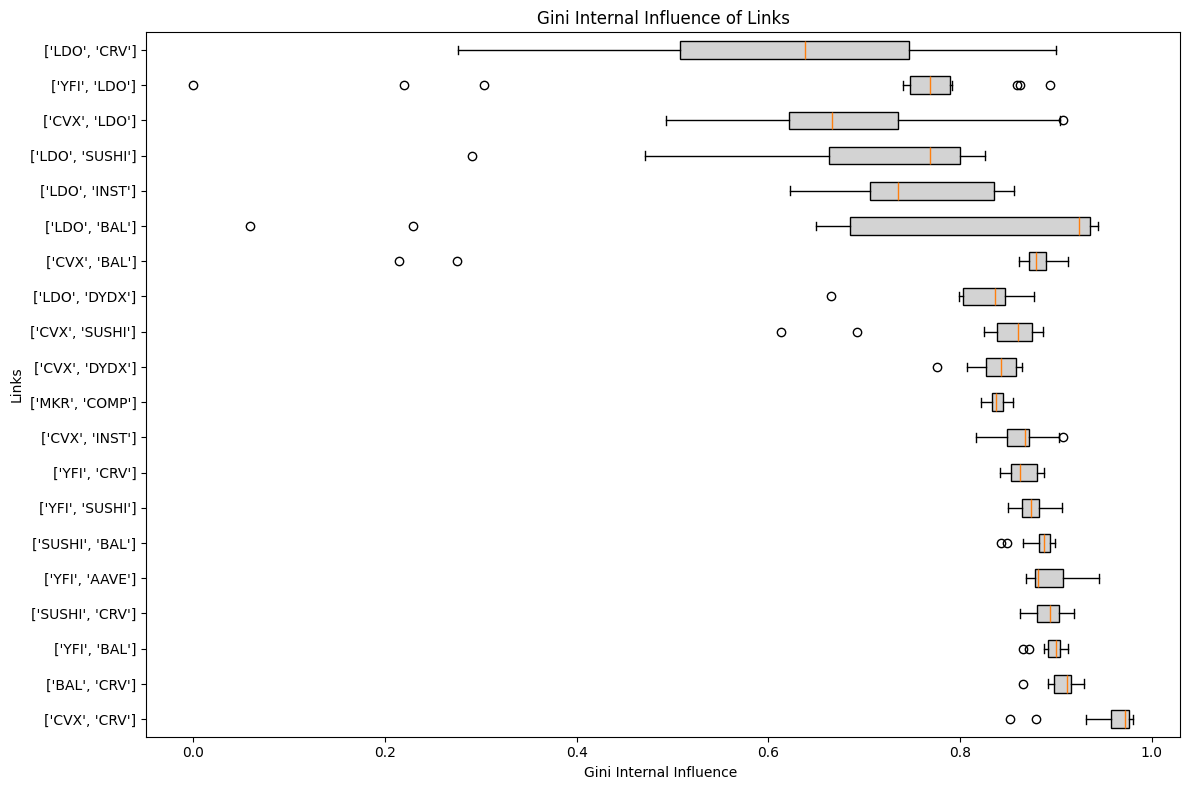

In [39]:
plot_boxplot(metric_dataframes, metric='gini_internal_influence', unit='', group='sample', pval_group='pvalues', output_path="../output/links/", custom_index='', min_occurrences=9, significance=False, save=True, show=True)

Observations: 
- The influence distribution within the link tends to be highly unequal with a gini coefficient close to 1 across cliques. This suggest that most substantial token supply is held by few addresses accross links. 
- Compare to permutated control samples they tend to be non-significant suggesting that control samples follow a simialry uneqal distribution.

### Fig: internal_influence 

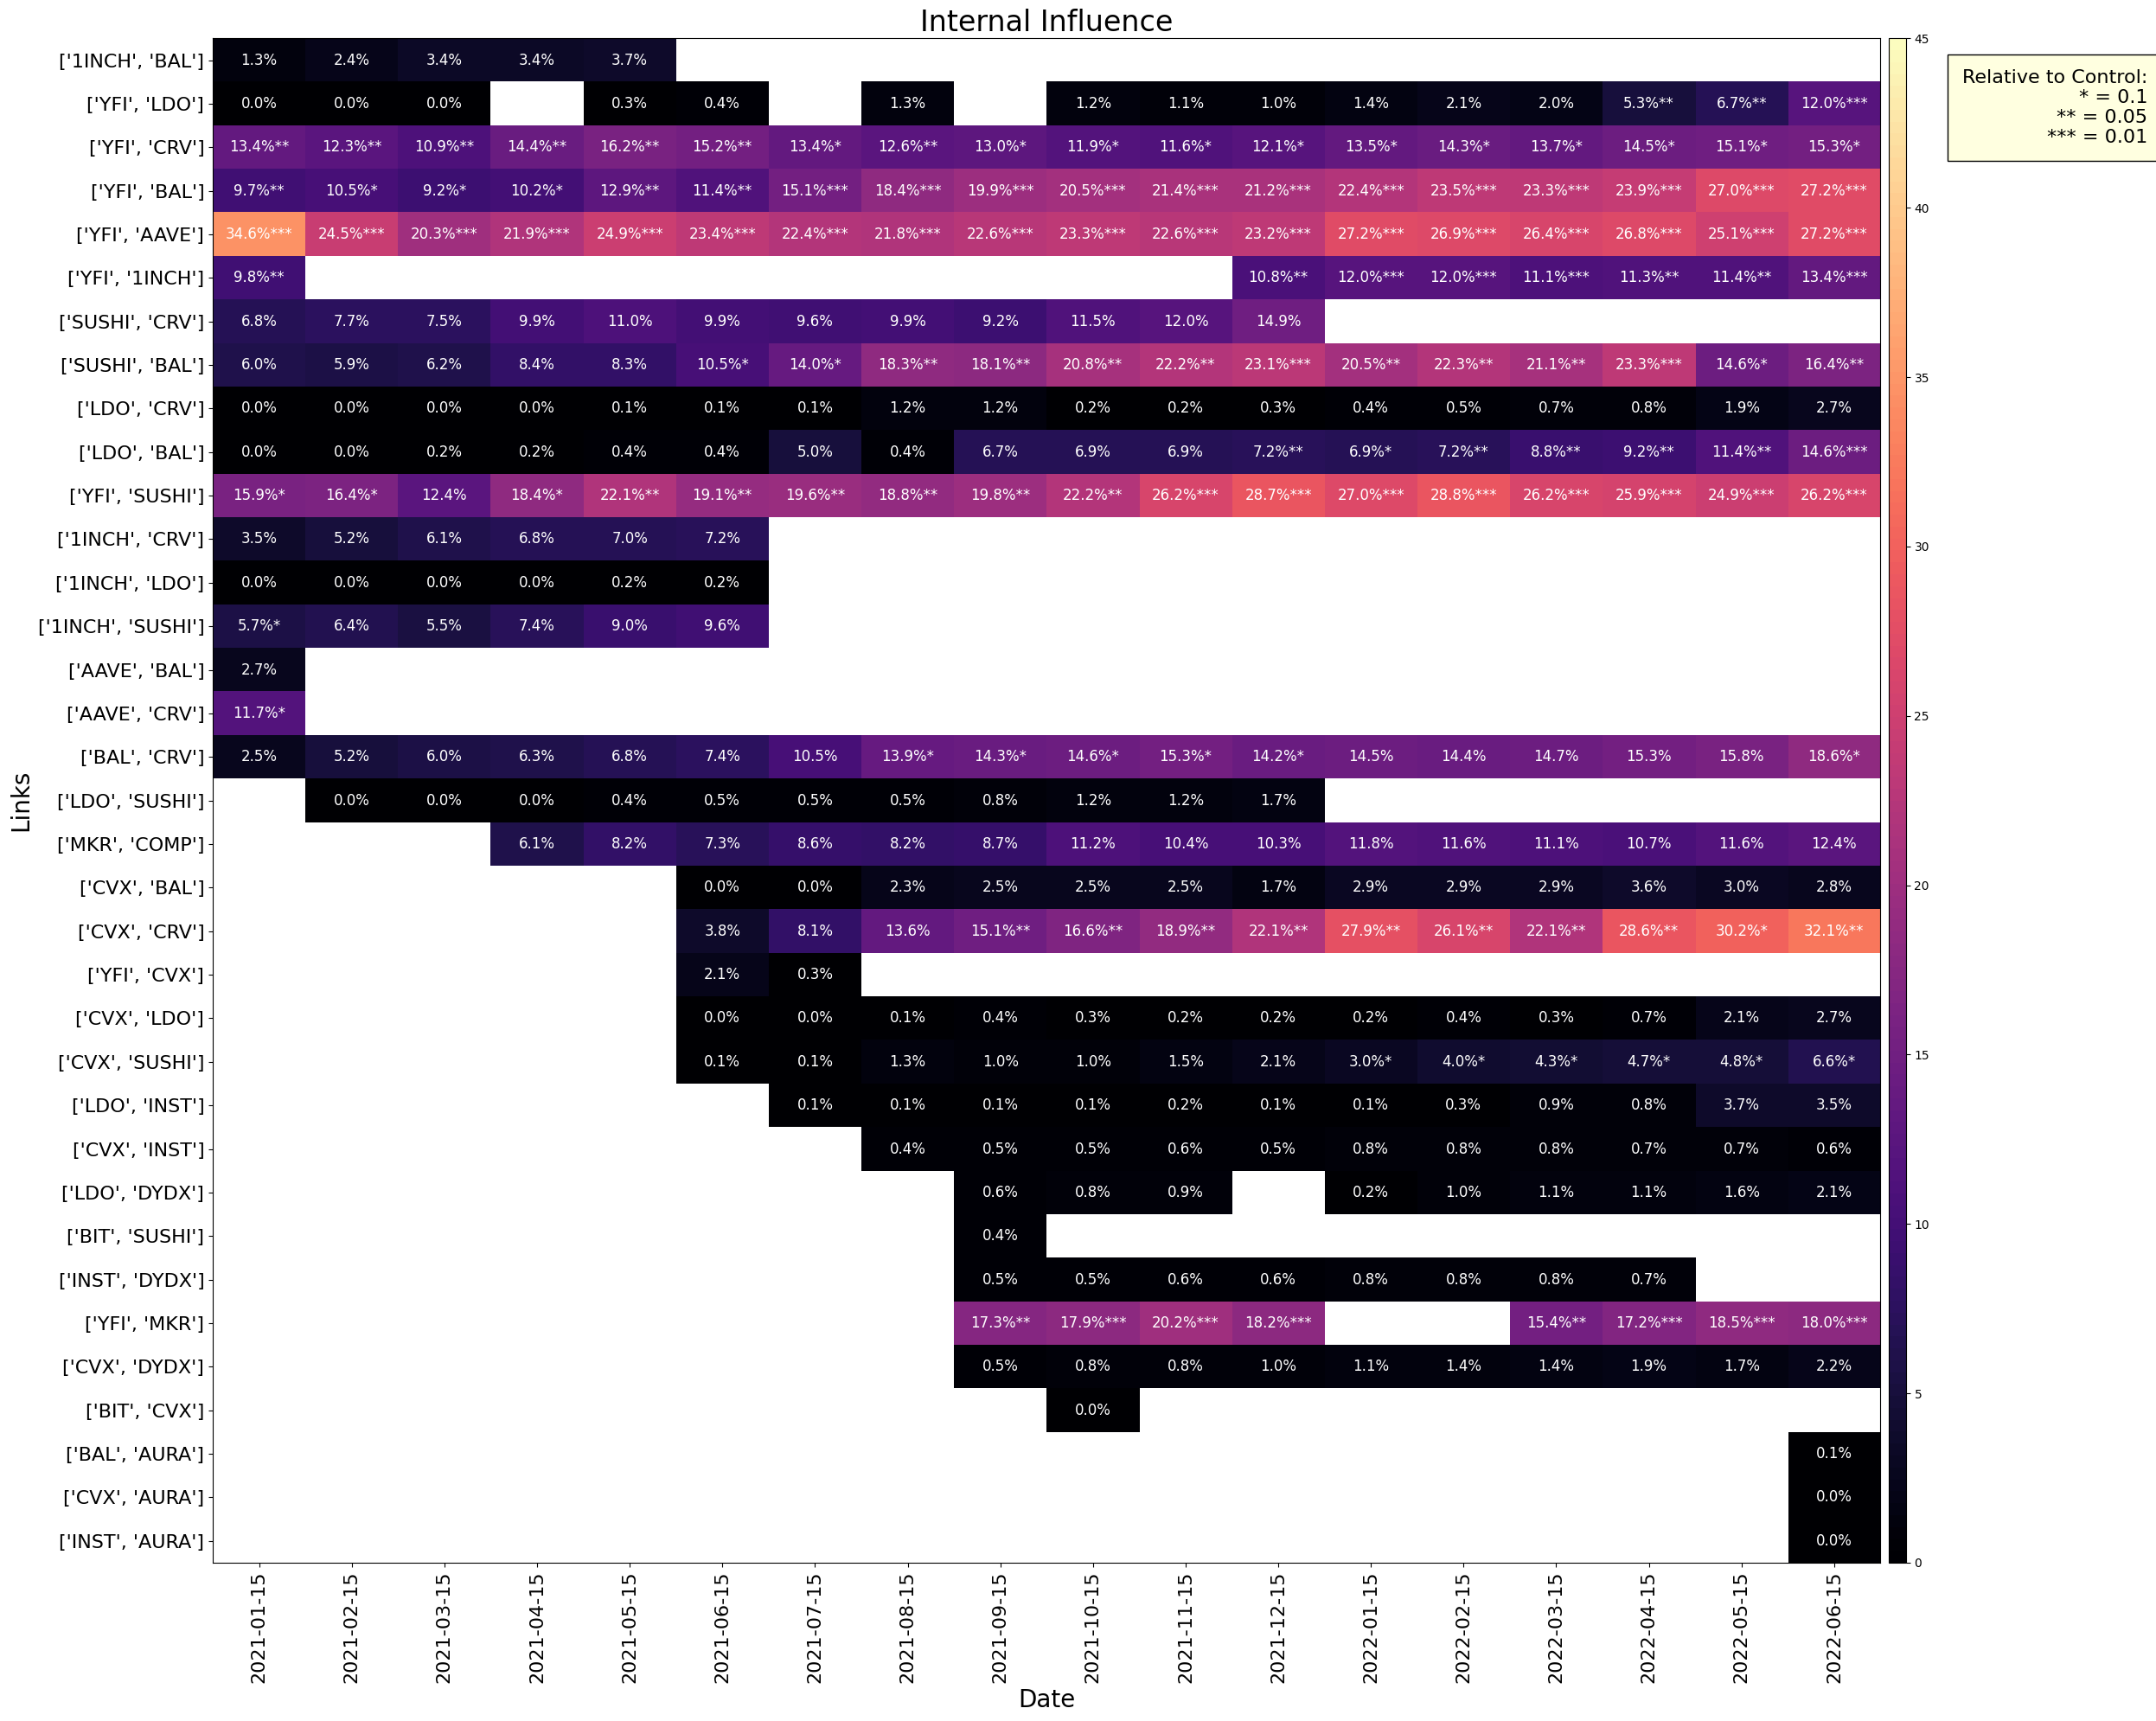

In [13]:
plot_heatmap_chart(metric_dataframes, metric_name='internal_influence', pct=True,  log=False, output_path="../output/links/", save=True, show=True)

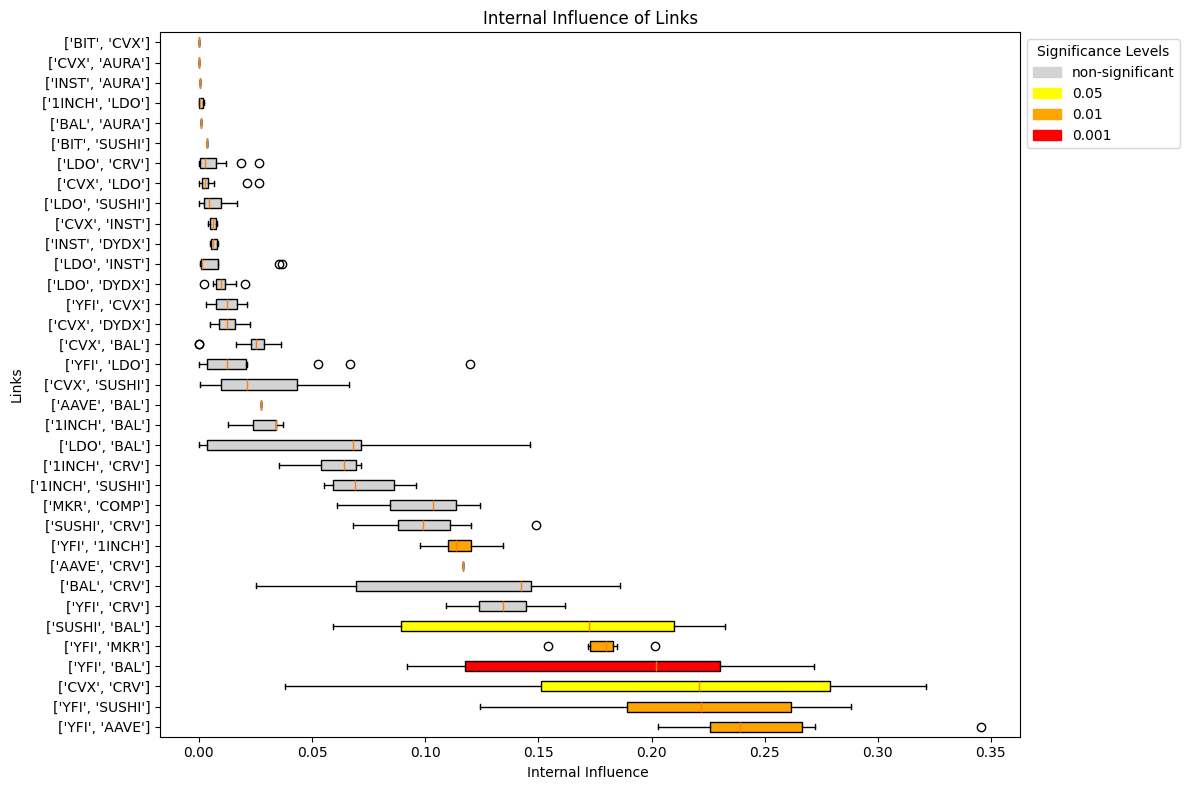

In [14]:
plot_boxplot_with_significance(metric_dataframes, metric='internal_influence', unit='',group='sample', output_path="../output/links/", save=True, show=True)

In [15]:
metric_dataframes['sample']['internal_influence'].mean(axis=1).describe()

count    35.000000
mean      0.064663
std       0.074484
min       0.000155
25%       0.006148
50%       0.026425
75%       0.115786
max       0.247251
dtype: float64

Observations: 
- High influence values reaching up to 34 % 
- Flucuation over time co-inciding with market cycles for instance may 2021-05-15, links such as YFI show accumualtion with decline 
- Some seem agnostic to market cycles such as CVX-CRV, YFI-BAL, LDO-BAL 
- YFI-CRV is relatively stable 

### Fig: gini_internal_influence 

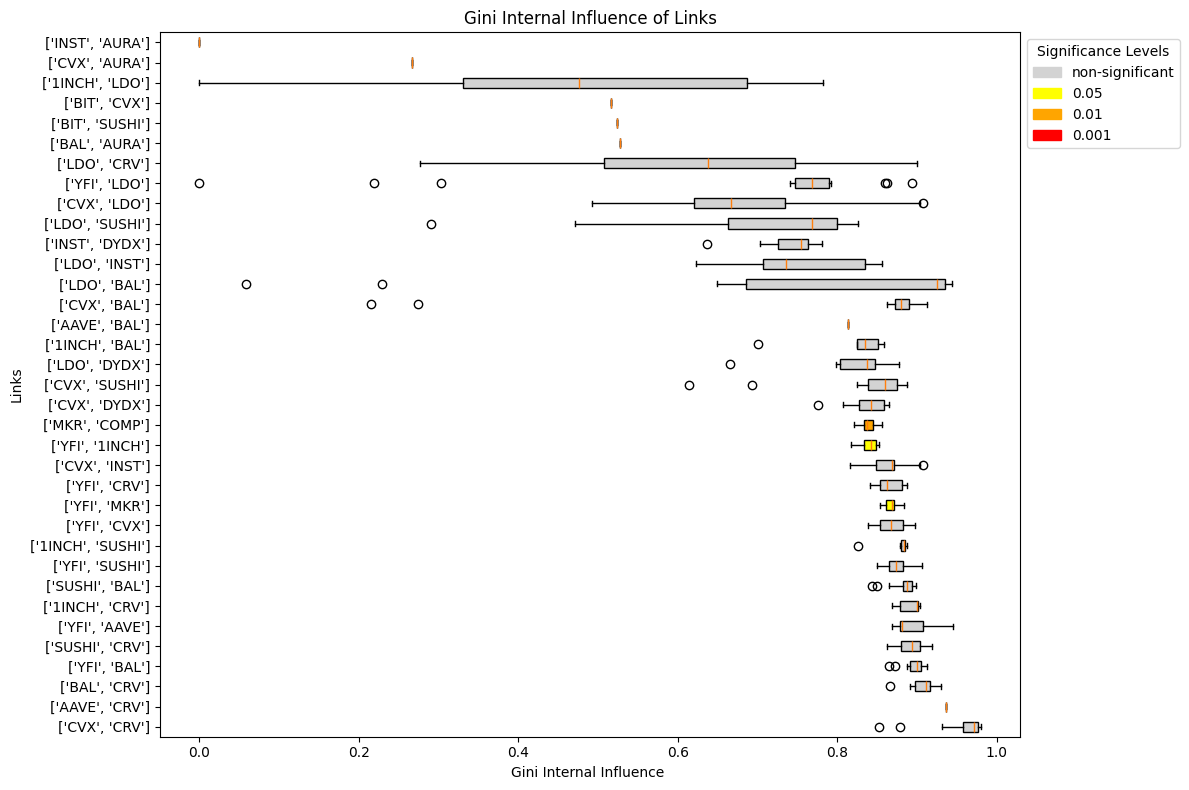

In [16]:
plot_boxplot_with_significance(metric_dataframes, metric='gini_internal_influence', unit='', group='sample', output_path="../output/links/", save=True, show=True)

Observation: 
- Internal Links show high concentration for most part
- The mode of available samples are non-significantly relative to permuated control, exception are MKR-COMP, YFI-1INCH, YFI-MKR.
- Here the gini coefficient is meaningfully lower compared to permuated control samples 

### Fig: external_influence

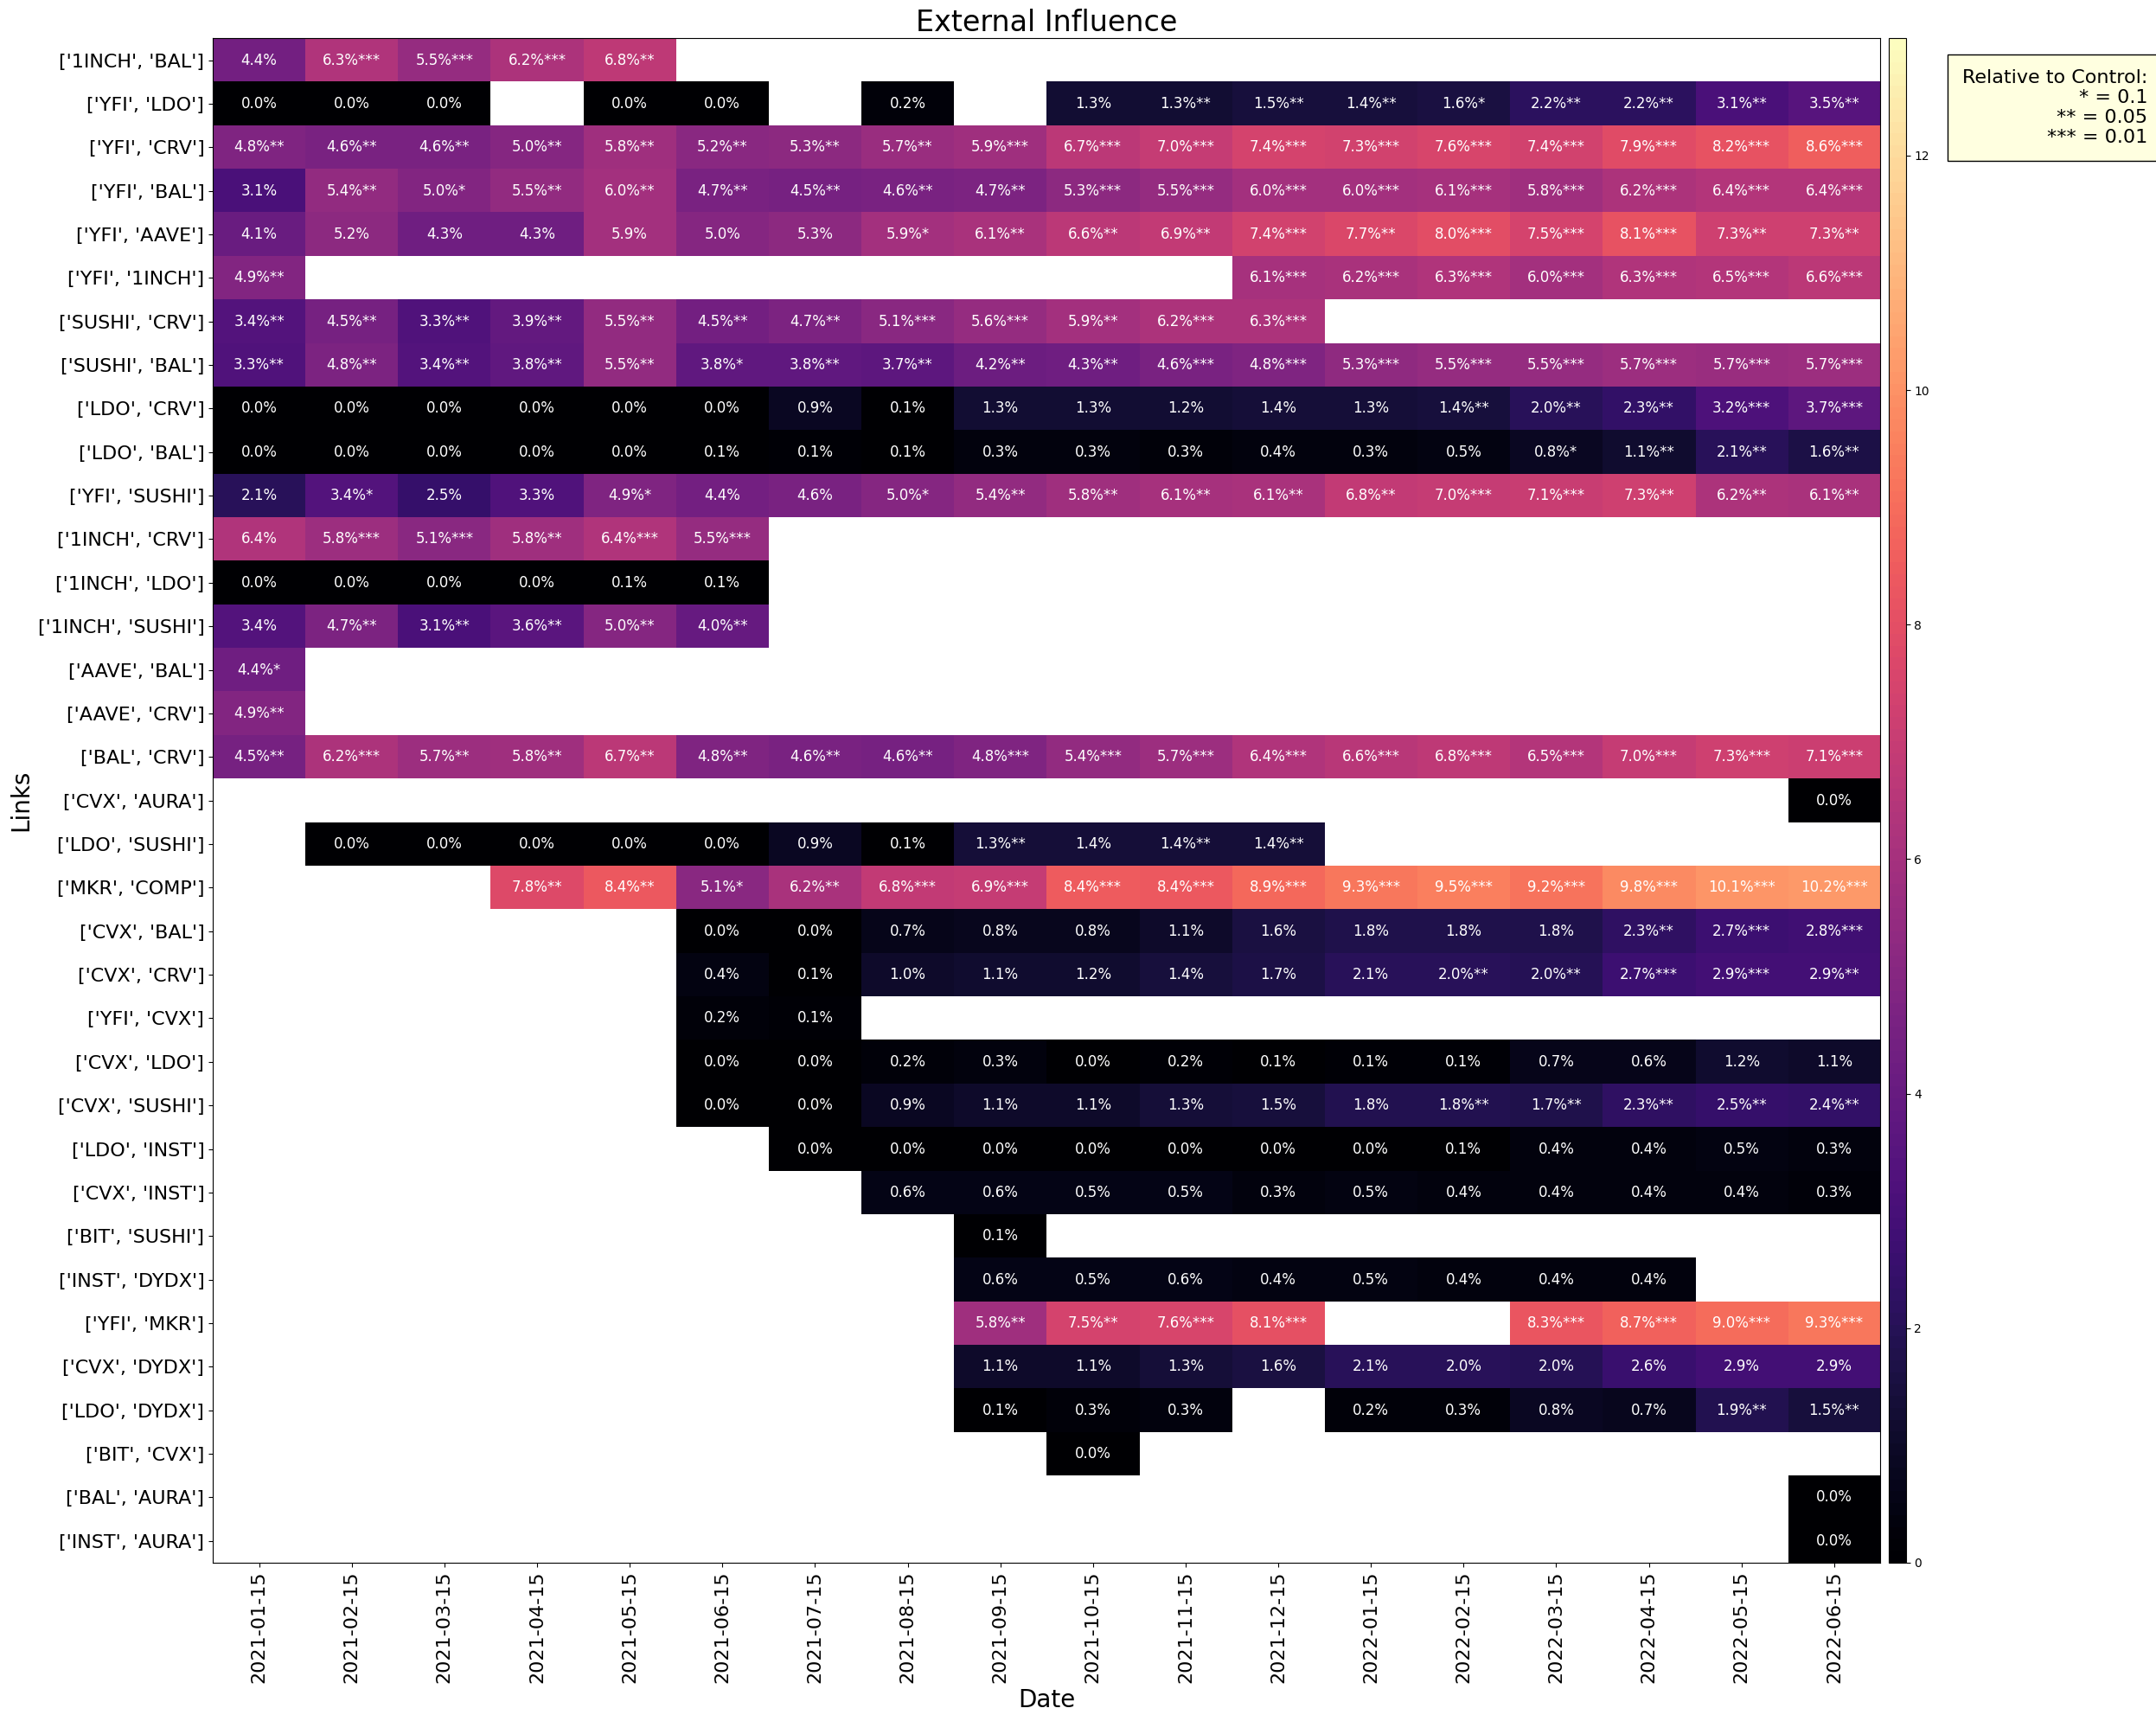

In [17]:
plot_heatmap_chart(metric_dataframes, metric_name='external_influence', pct=True, log=False, output_path="../output/links/", save=True, show=True)

Observation: 
- Link wield meaningful influence over other tokens in the sample which are not part of the clique. 
- Patterns seem to coincide more with market cycles (see BAL-CRV, MKR-COMP, SUSHI-BAL,YFI-CRV). Note especially cumulation peak with 2021-05-15
- Comparing this to internal influence suggest that clique token are held more by the selected wallets
- MKR-COMP reaches signigicane values in external but not internal influence, suggest the influential in the environment but lesser so with in the token communitites they are part of. 
- CVX-CVR hardly holds any other tokens 

### Fig: gini_external_influence

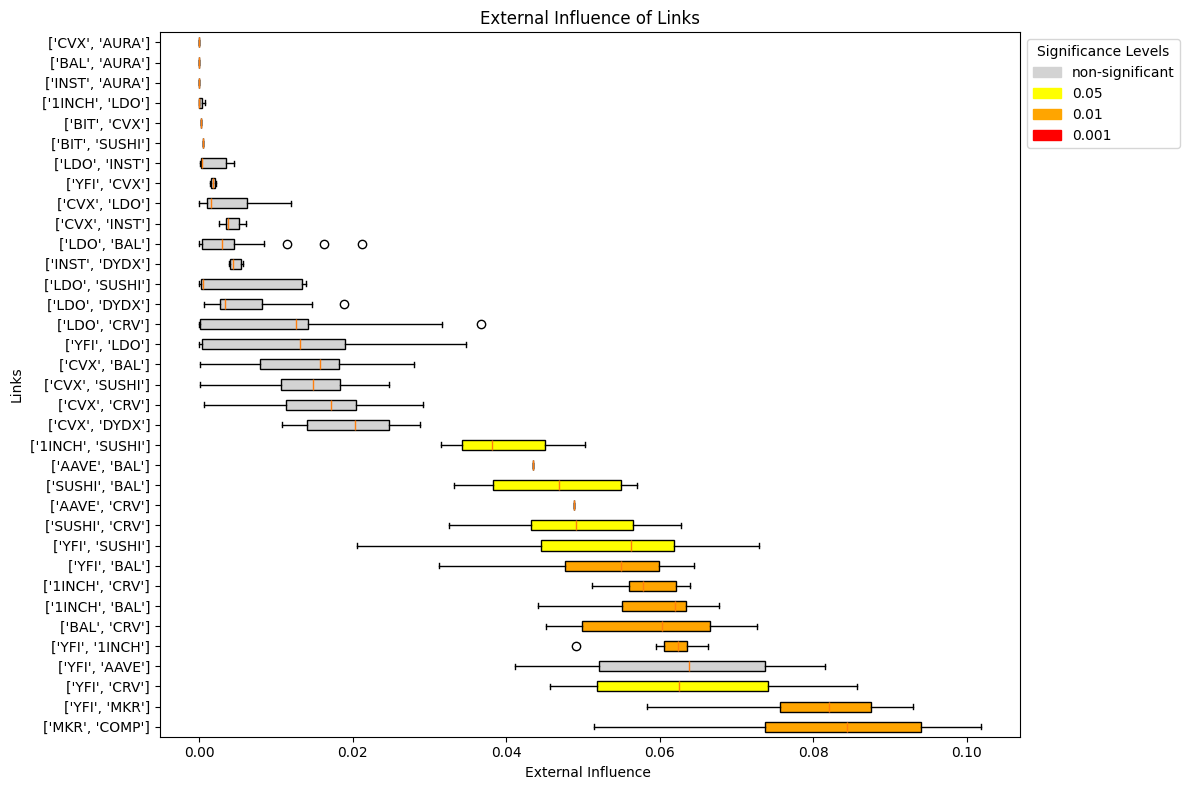

In [18]:
plot_boxplot_with_significance(metric_dataframes, metric='external_influence', unit='', group='sample', output_path="../output/links/", save=True, show=True)

Observations: 
- lower gini then internal influence (i.e. wealth/ influence is more equally distributed), wide ranges fro LDO tokens 
- YFI-1INCH, SUSHI-BAL, YFI-AAVE have more equal distribution than expected compared to the permuted control samples. 


### Fig: wealth_clique


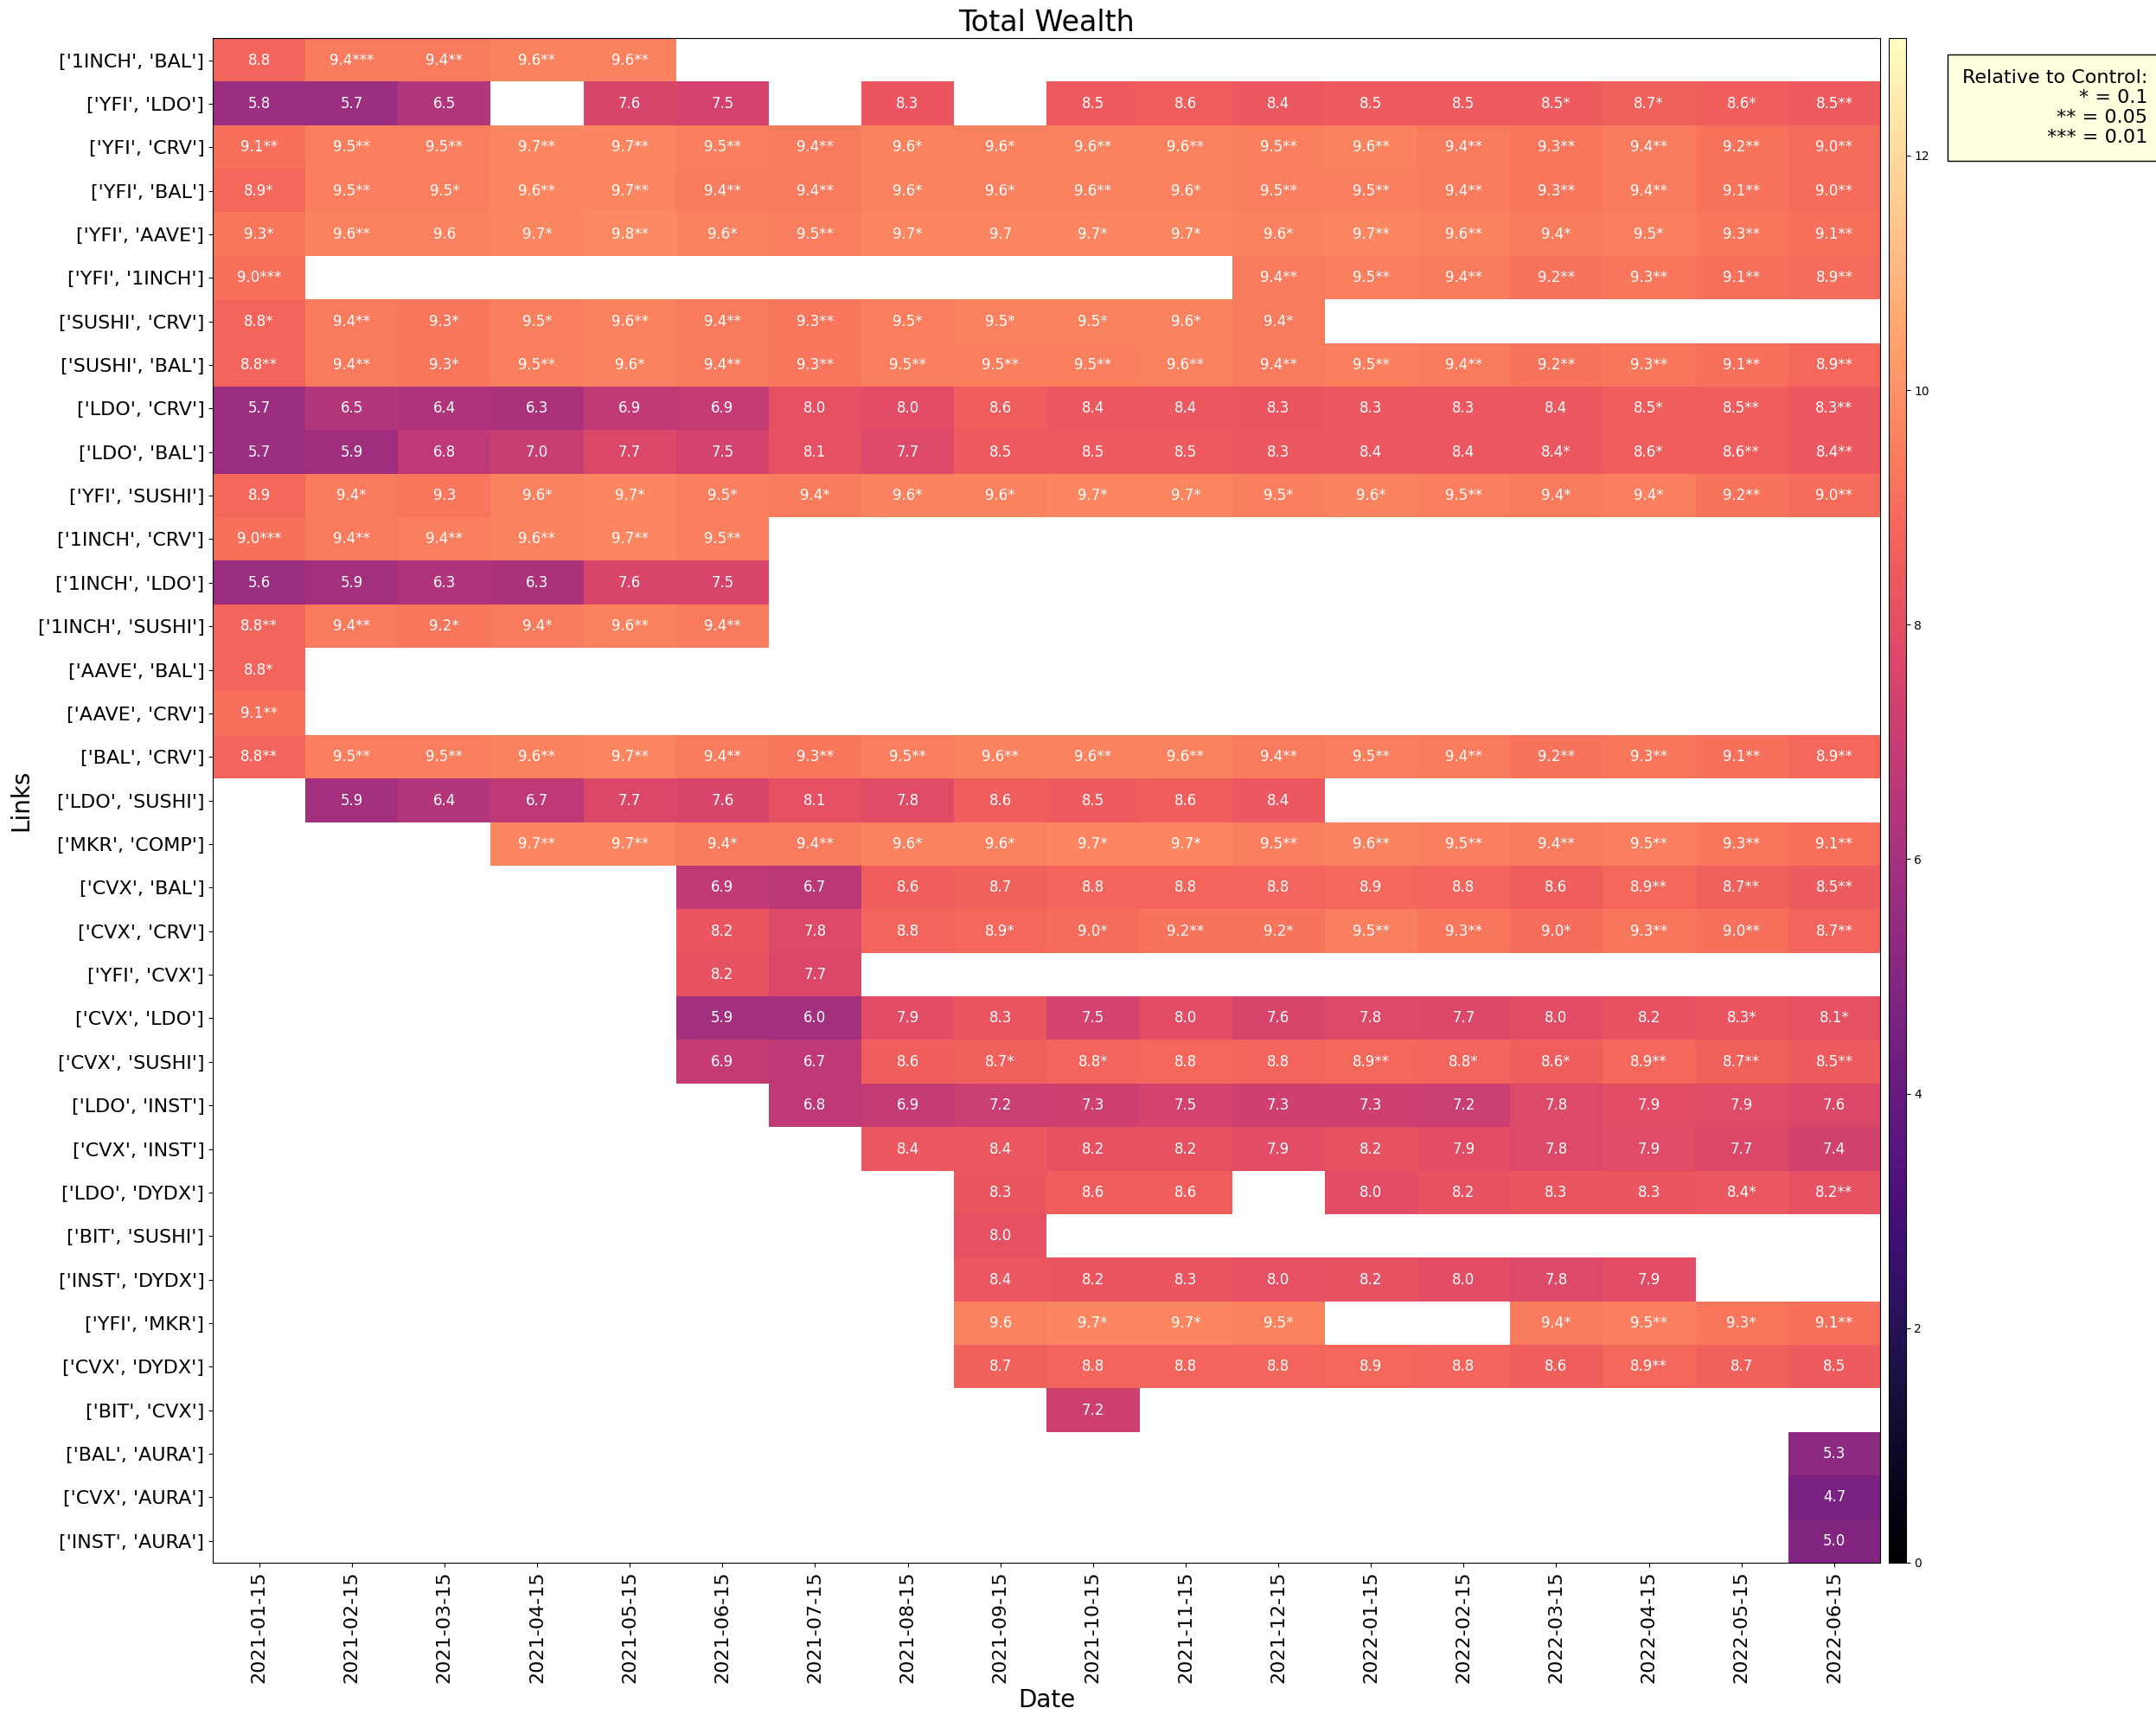

In [19]:
plot_heatmap_chart(metric_dataframes, metric_name='total_wealth', pct=False, log=True, output_path="../output/links/", save=True, show=True)

Observation: 
- High not regular investor 
- values relatively stable 

NOTE: DO NOT INCLUDE THIS CHART

DO do correlate influence with wealth - negative correlation for cliques would suggest that influence or wealth move independent (i.e. people are holding and price is changing)

### Fig: gini_wealth_clique

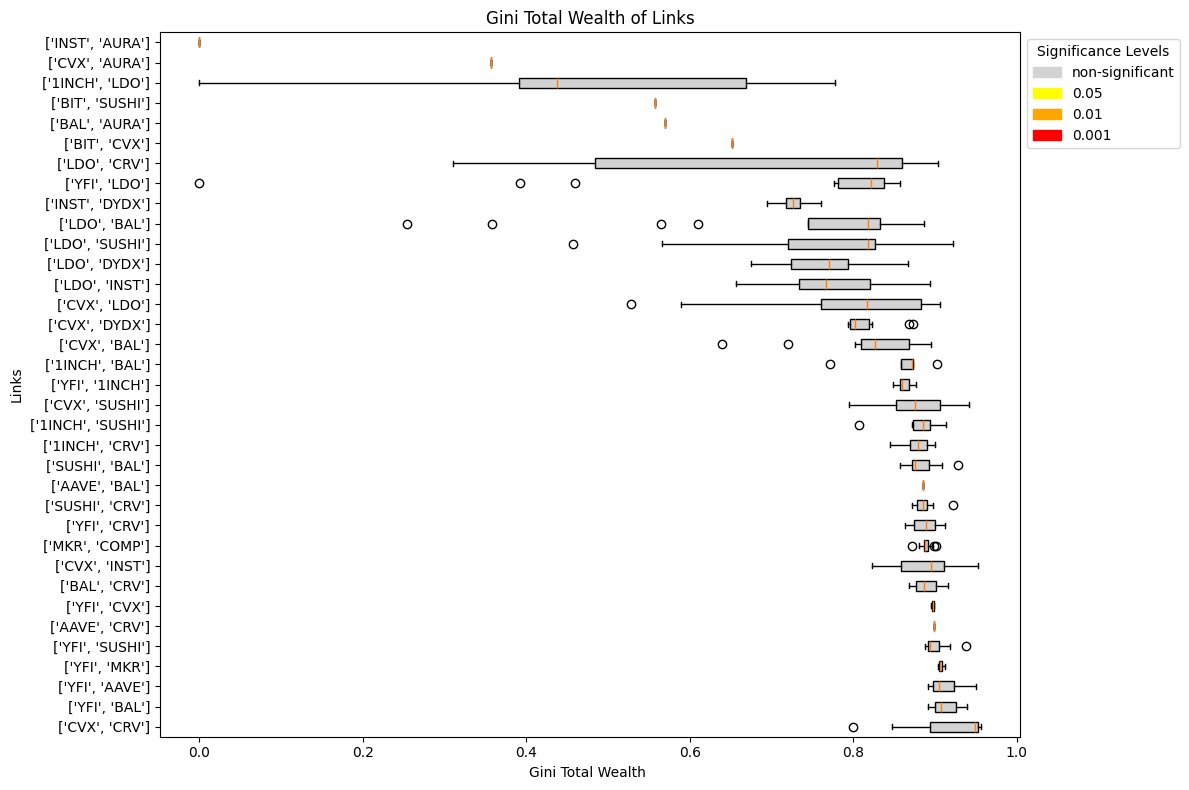

In [20]:

plot_boxplot_with_significance(metric_dataframes, metric='gini_total_wealth', unit='', group='sample', output_path="../output/links/", save=True, show=True)


Obervation: 
- as expected not interesting 

DO NOT INCLUDE THIS CHART 

### Fig: median_wealth_level

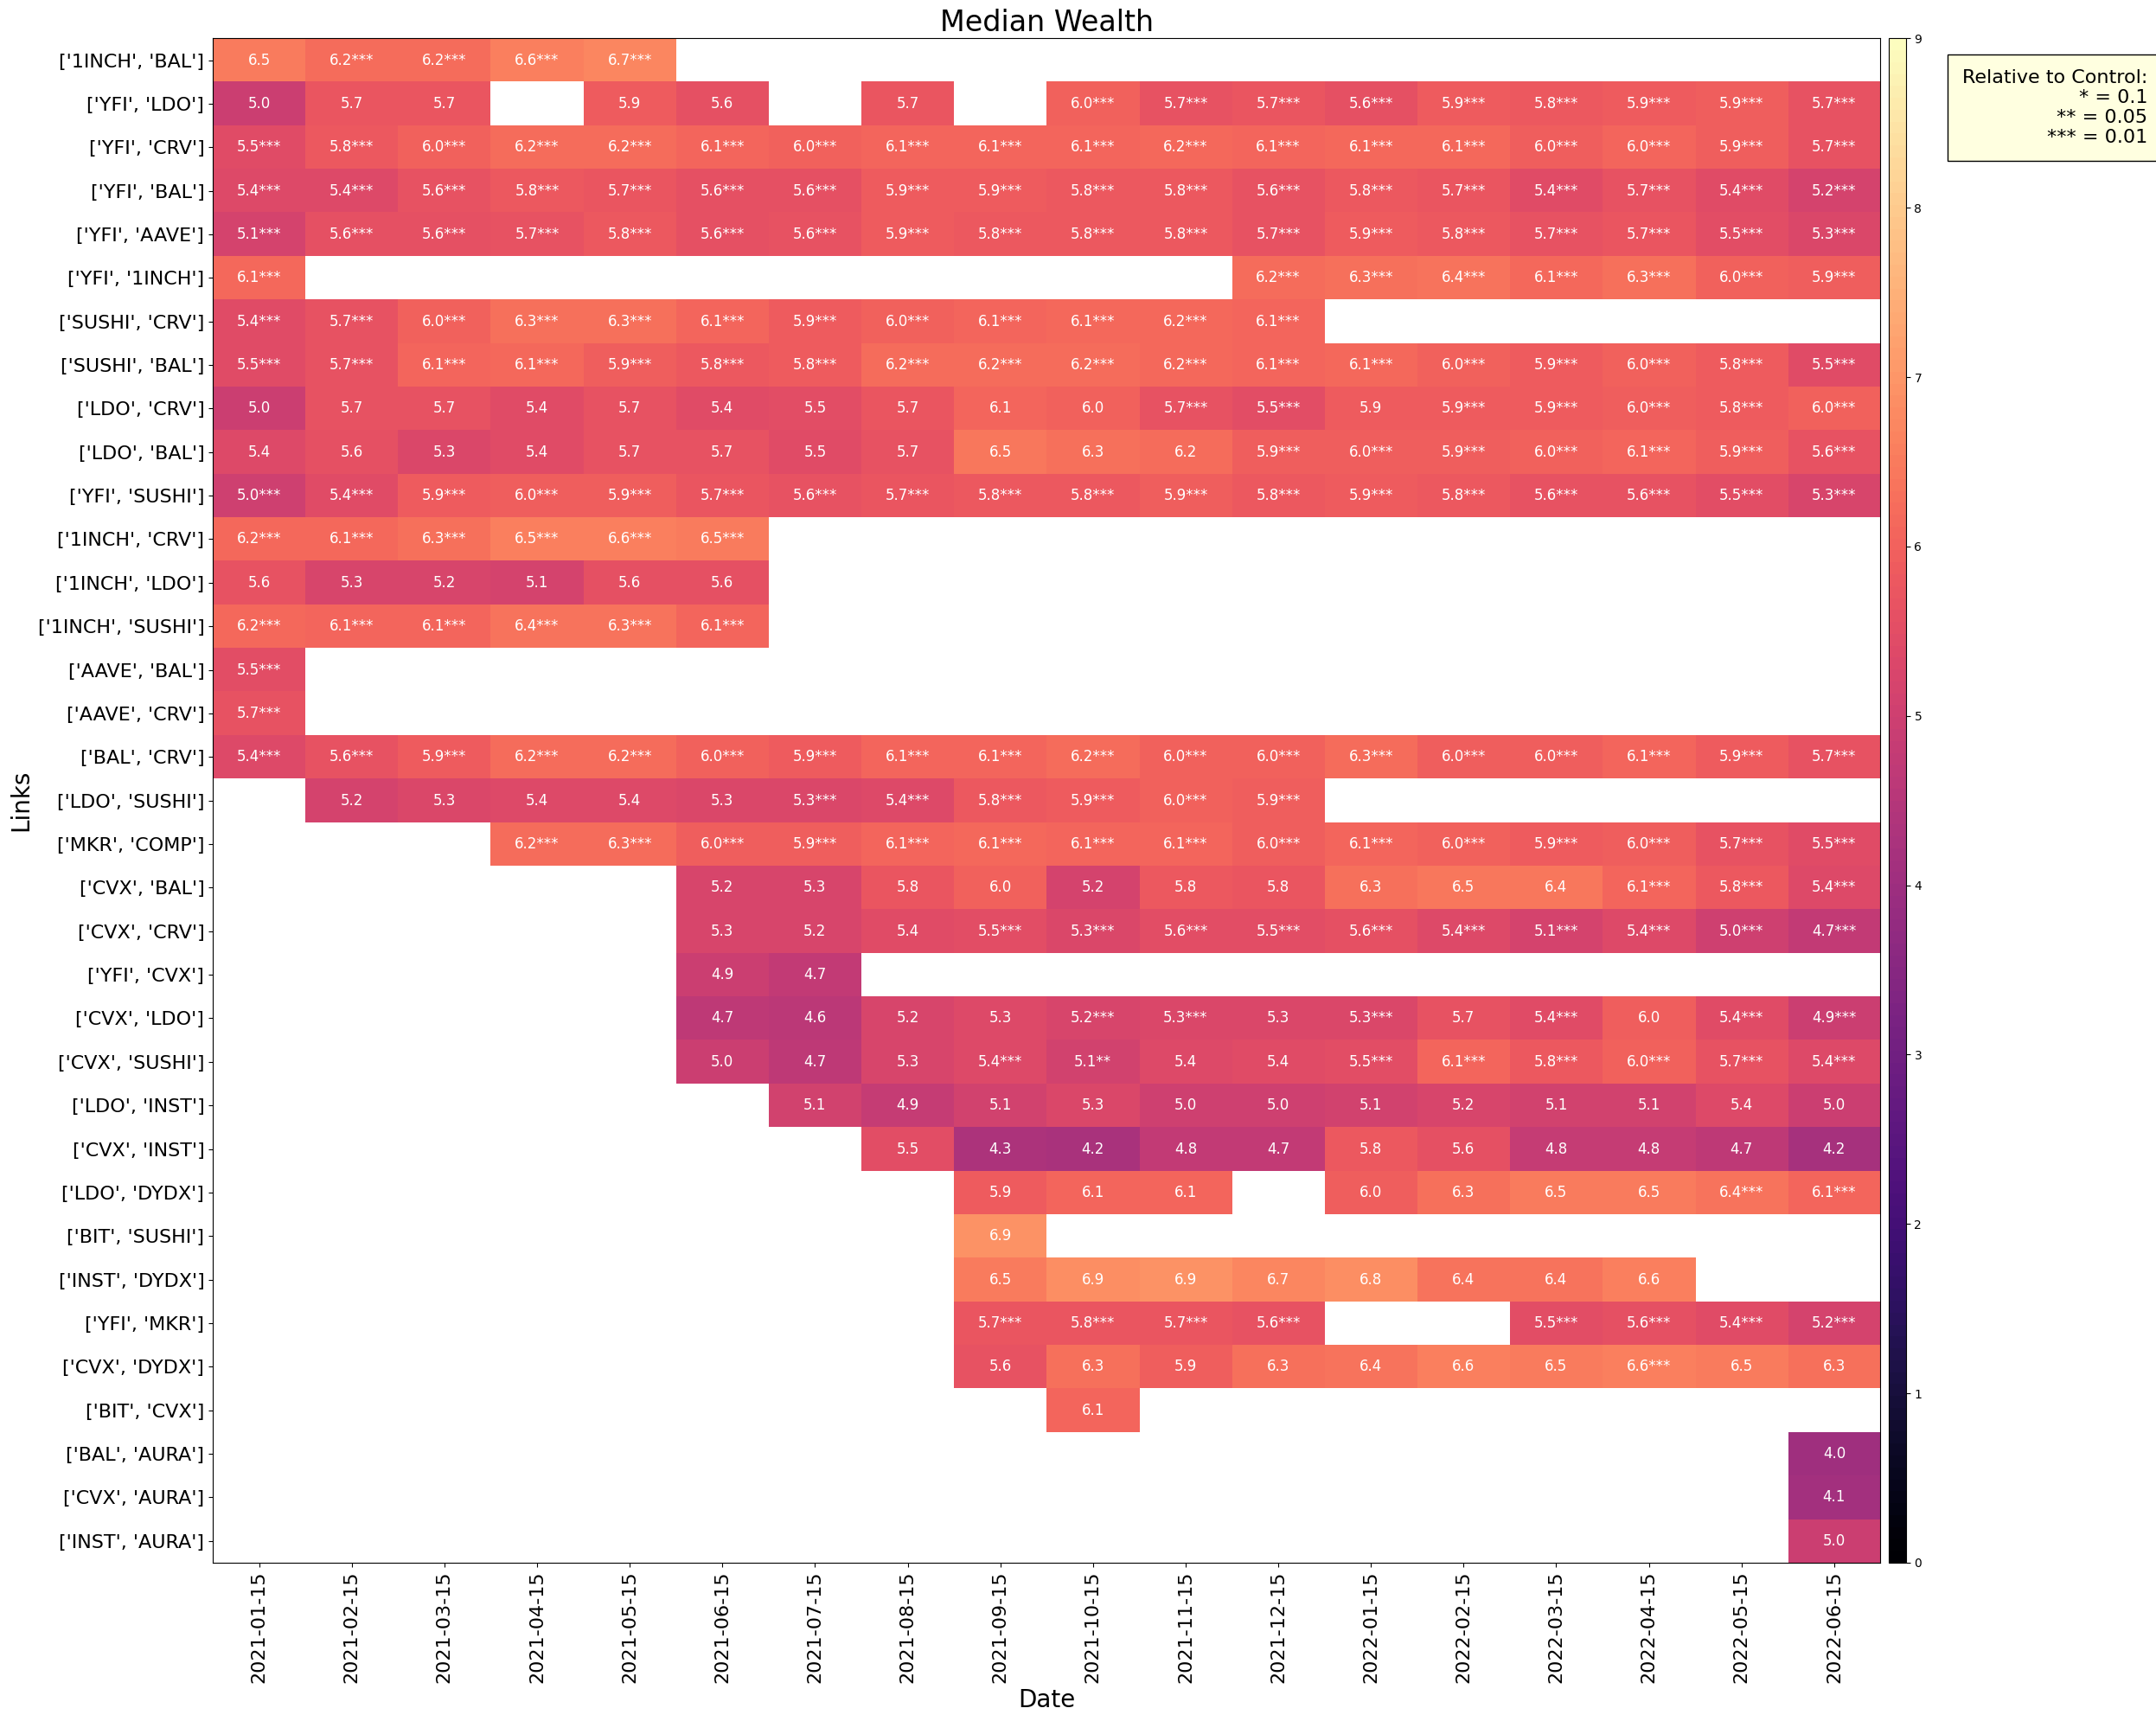

In [21]:
plot_heatmap_chart(metric_dataframes, metric_name='median_wealth', pct=False, log=True, output_path="../output/links/", save=True, show=True)

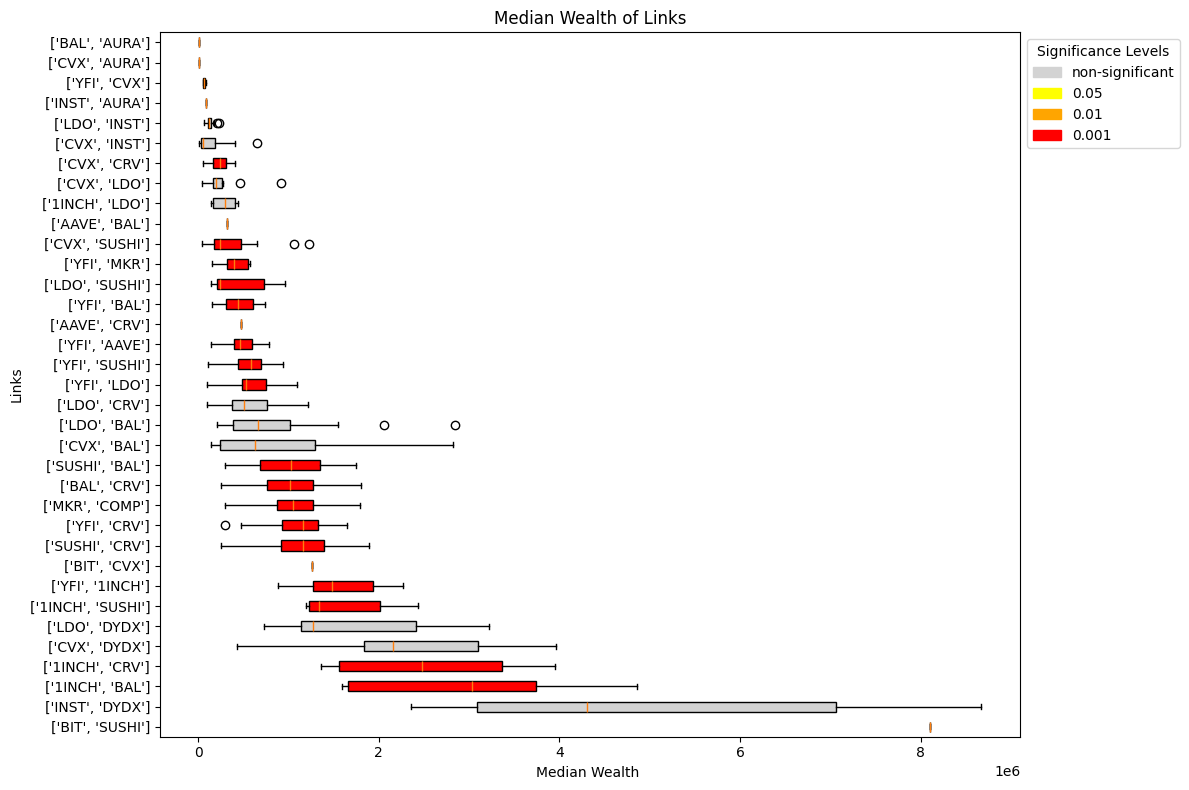

In [22]:
plot_boxplot_with_significance(metric_dataframes, metric='median_wealth', unit='', group='sample', output_path="../output/links/", save=True, show=True)


Observation: 
- Median investment size is generally 100_000  to 1000_000 USD
- Suggest its not typical household investors 

### Fig: internal_wealth

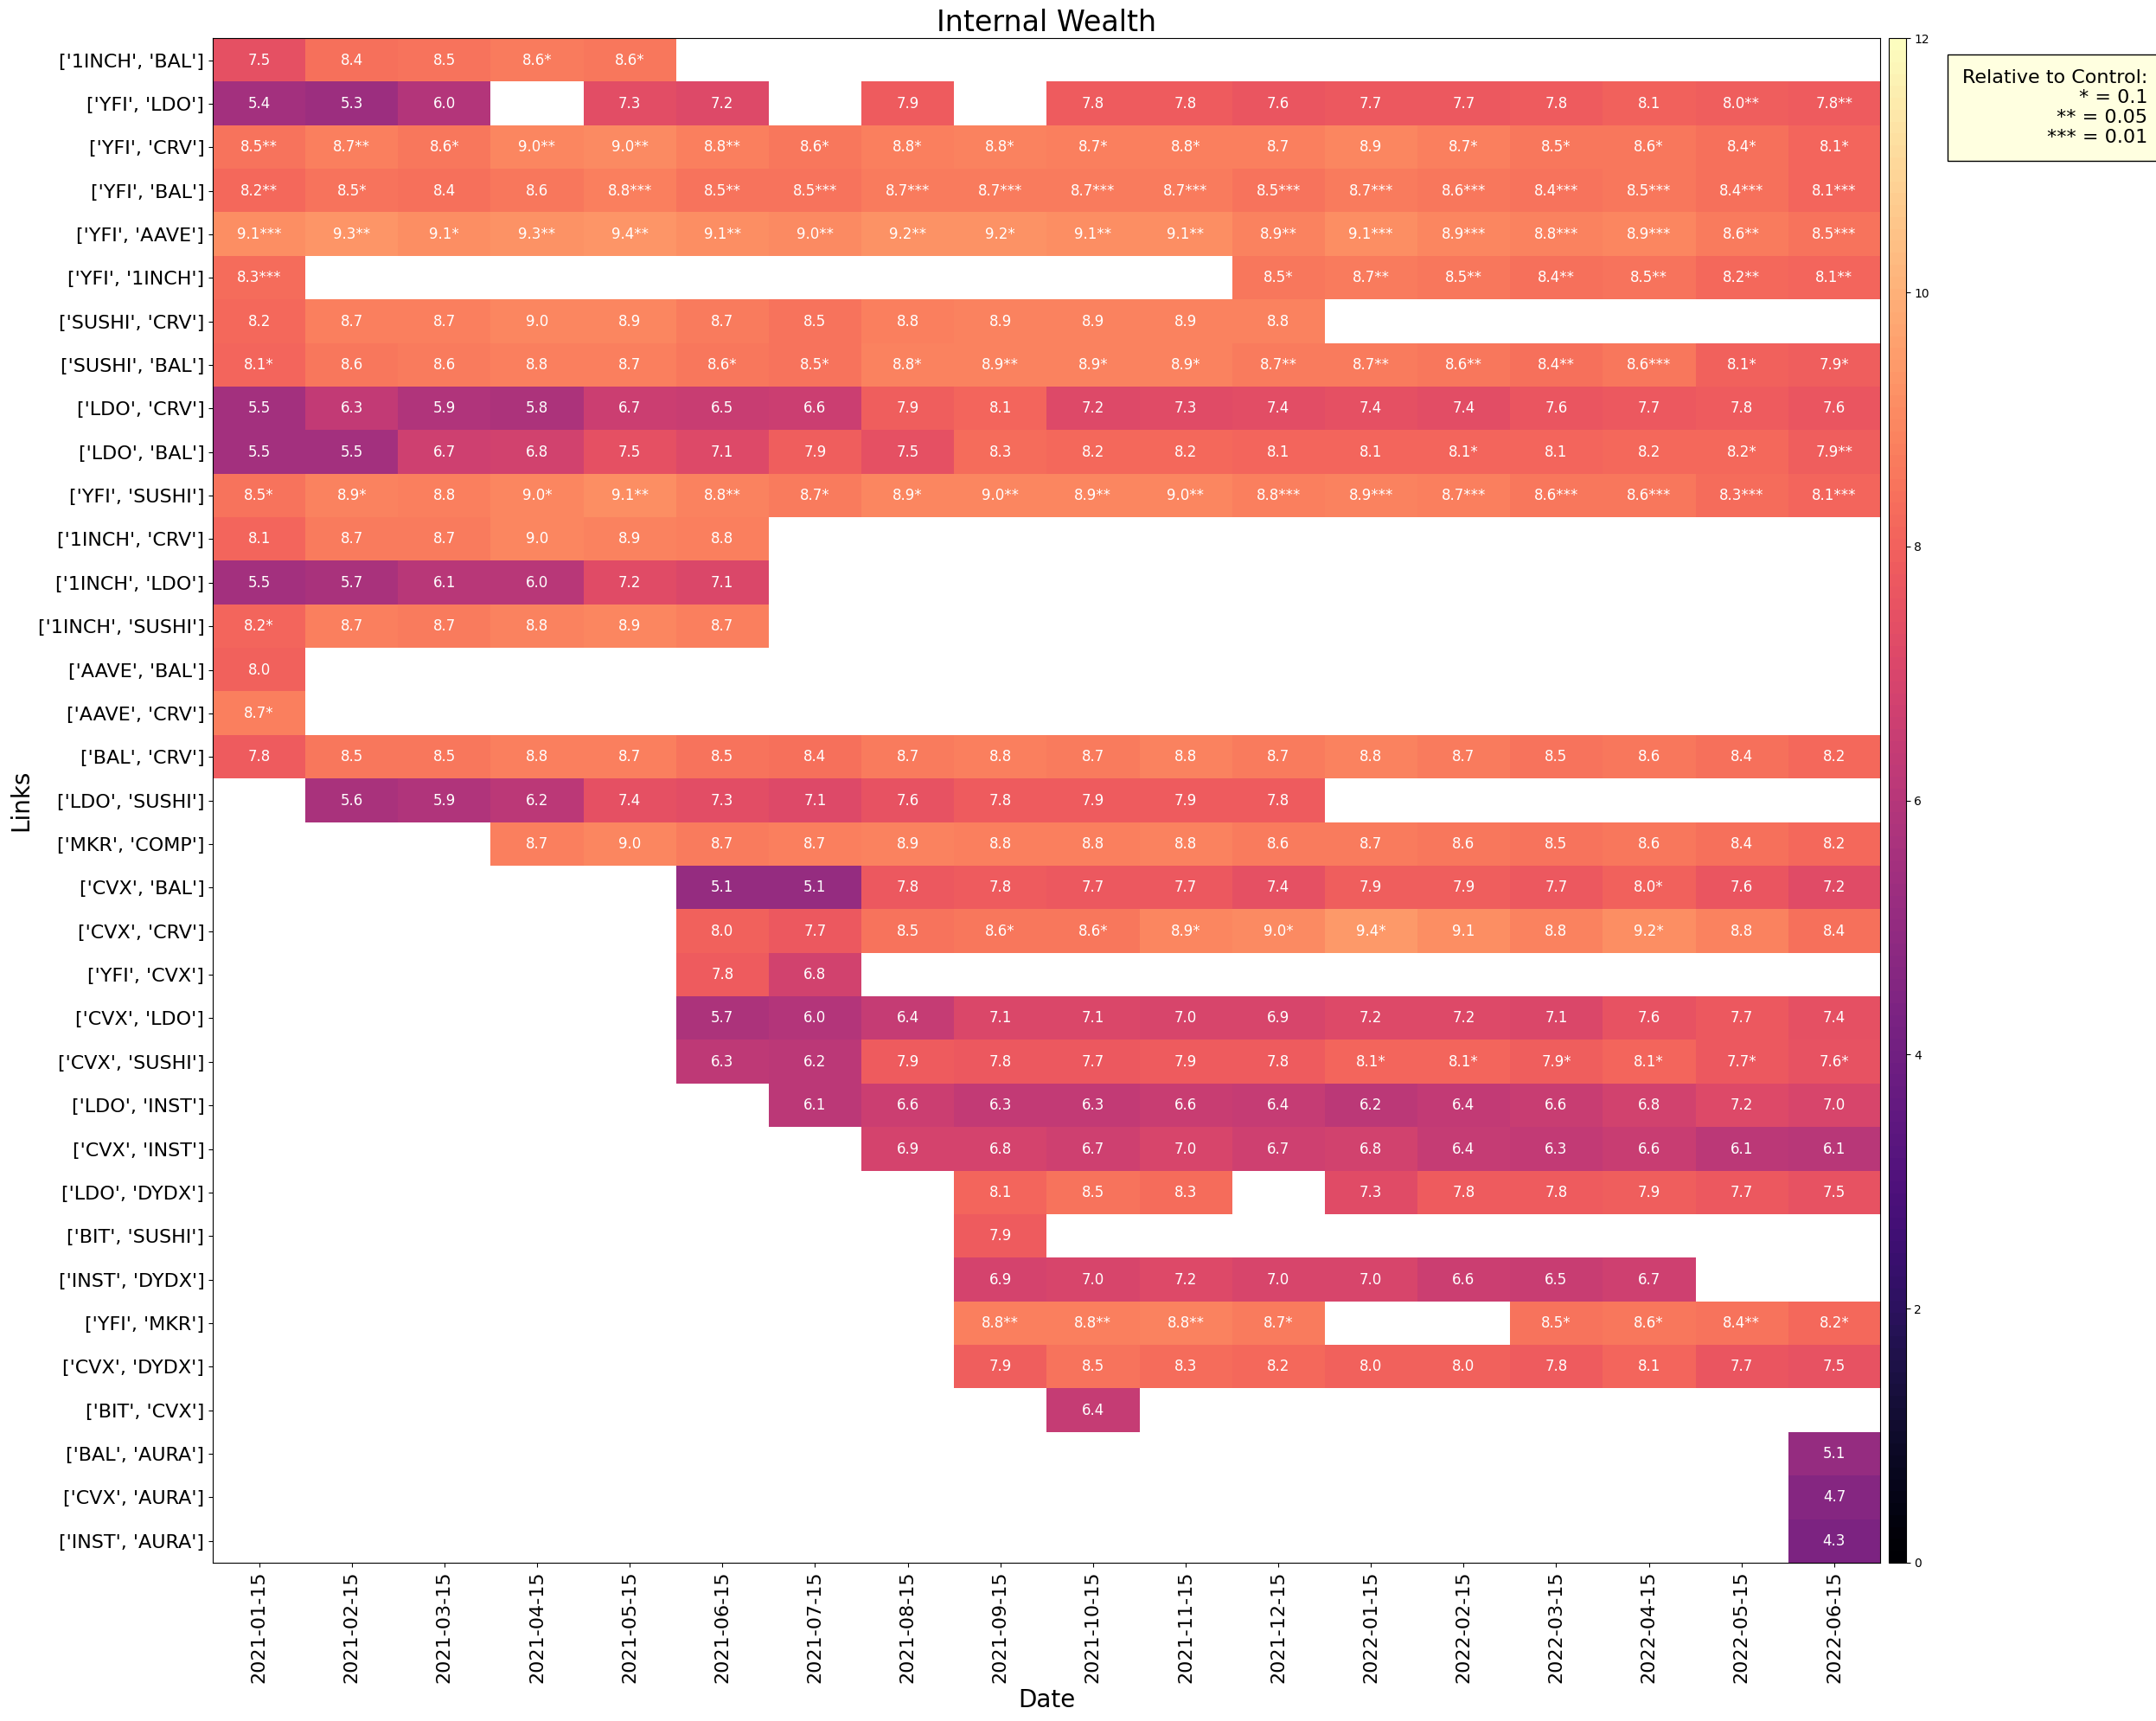

In [23]:
plot_heatmap_chart(metric_dataframes, metric_name='internal_wealth', pct=False, log=True, output_path="../output/links/", save=True, show=True)

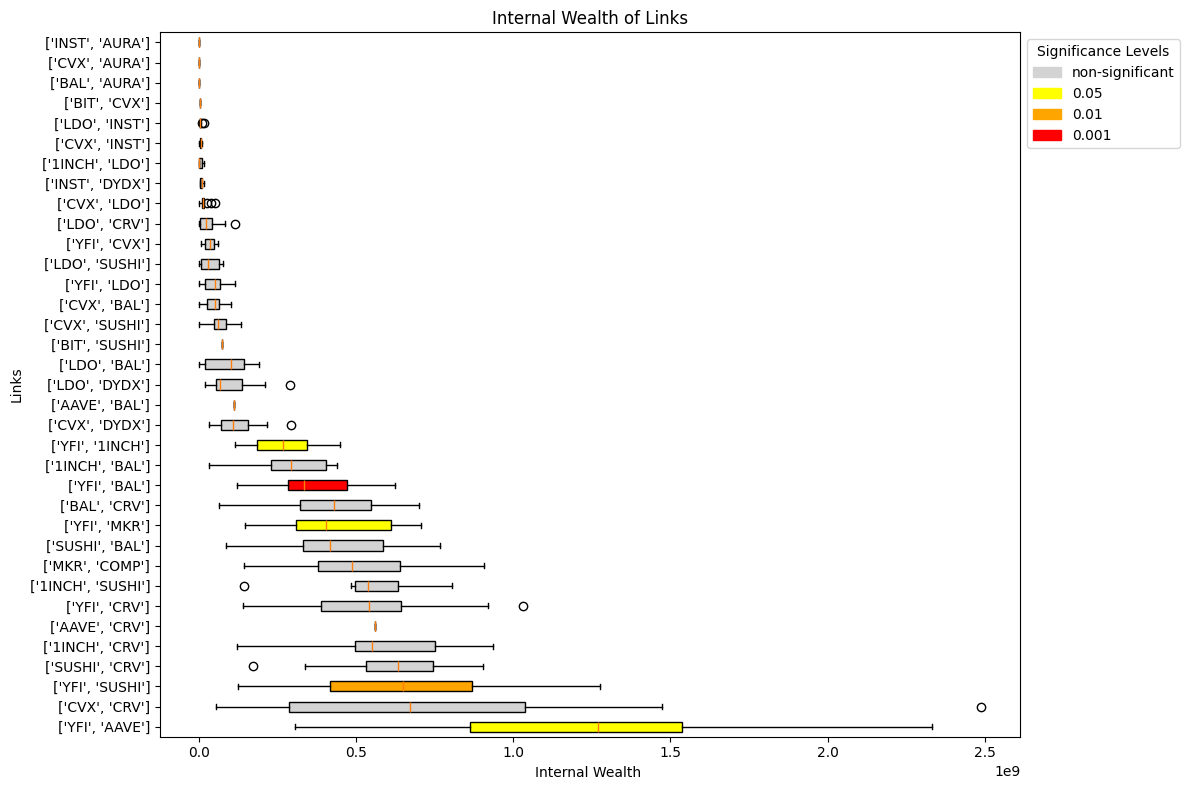

In [24]:

plot_boxplot_with_significance(metric_dataframes, metric='internal_wealth', unit='', group='sample', output_path="../output/links/", save=True, show=True)


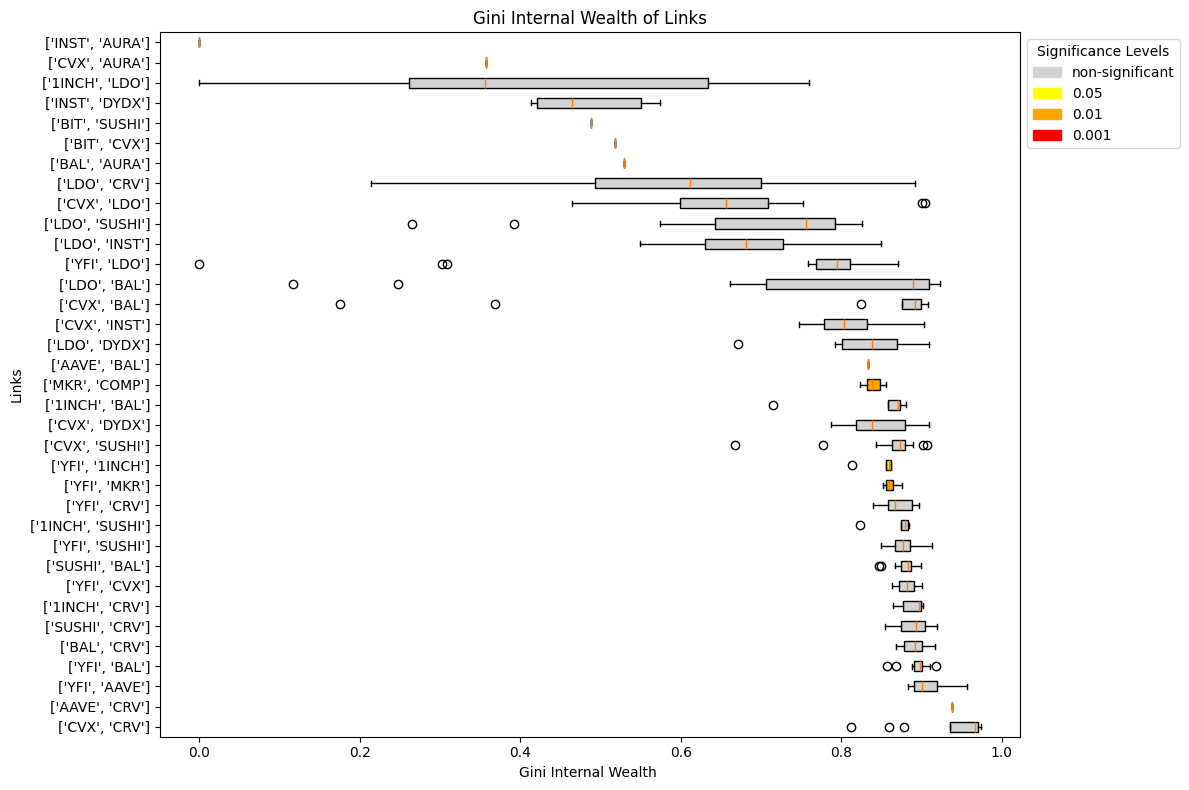

In [25]:
plot_boxplot_with_significance(metric_dataframes, metric='gini_internal_wealth', unit='', group='sample', output_path="../output/links/", save=True, show=True)


### Fig: external_wealth

/home/xm3van/research-project-erc20-governance/.venv/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


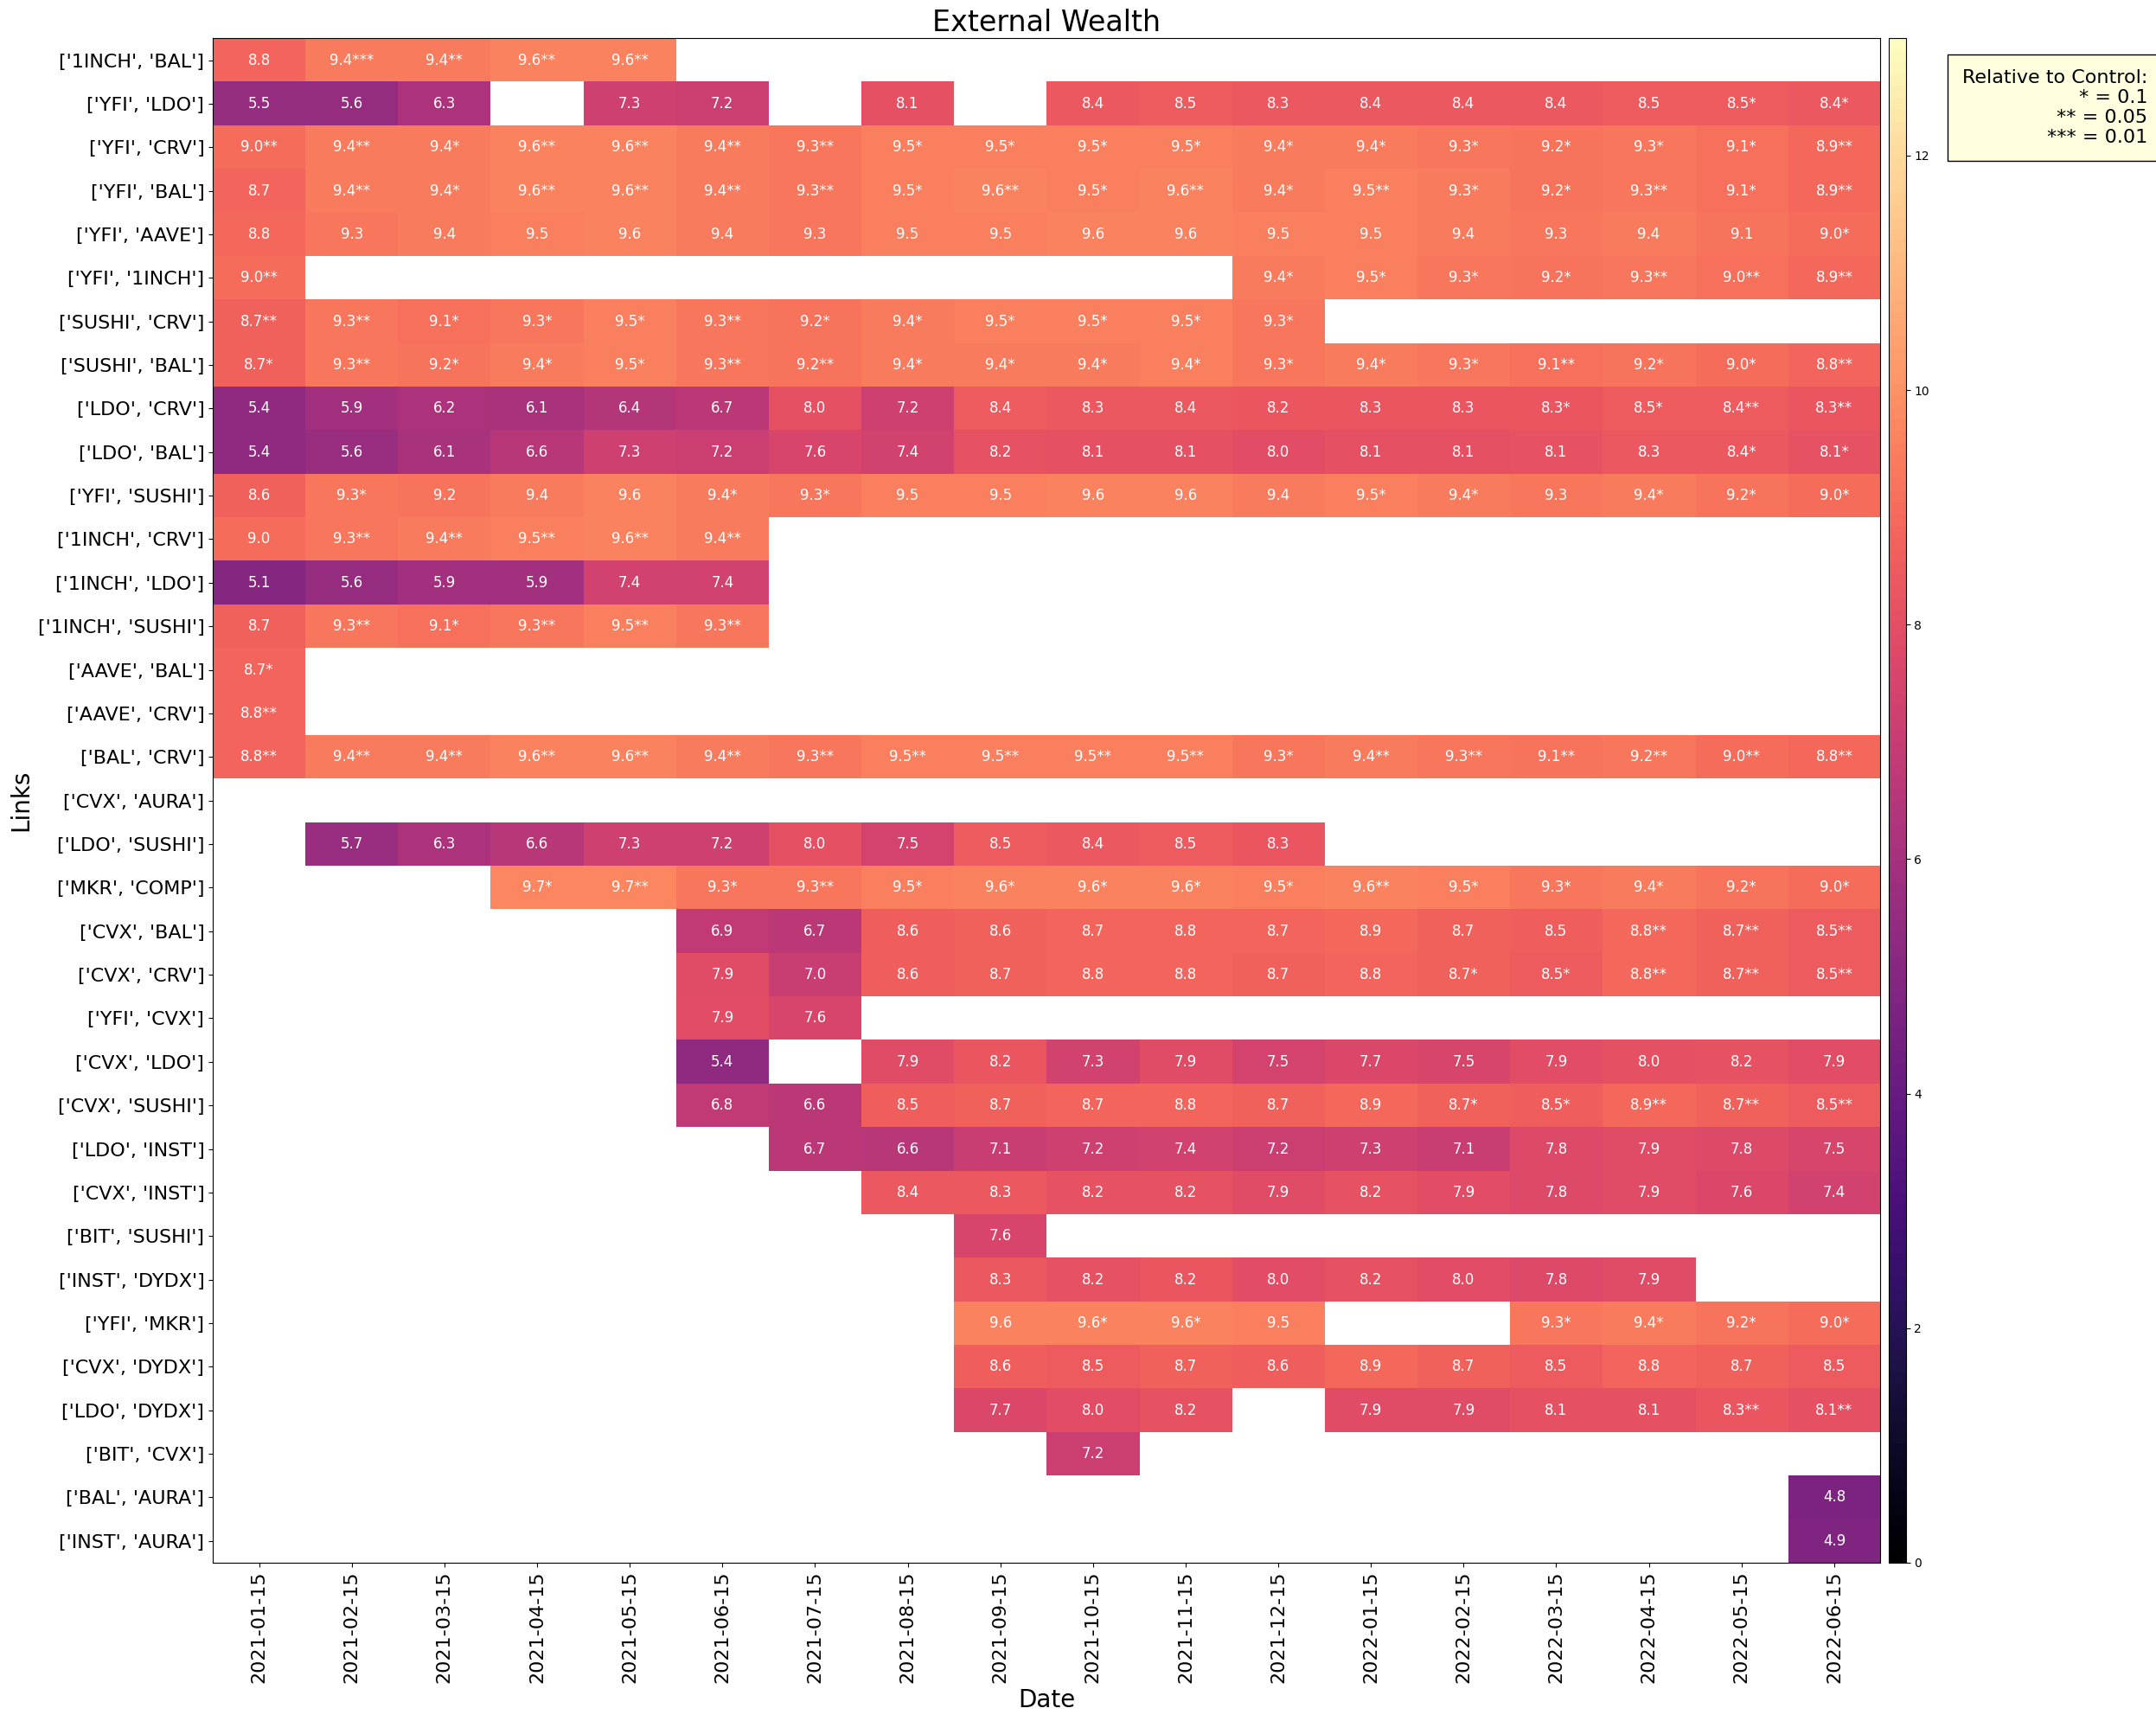

In [26]:
plot_heatmap_chart(metric_dataframes, metric_name='external_wealth', pct=False, log=True, output_path="../output/links/", save=True, show=True)

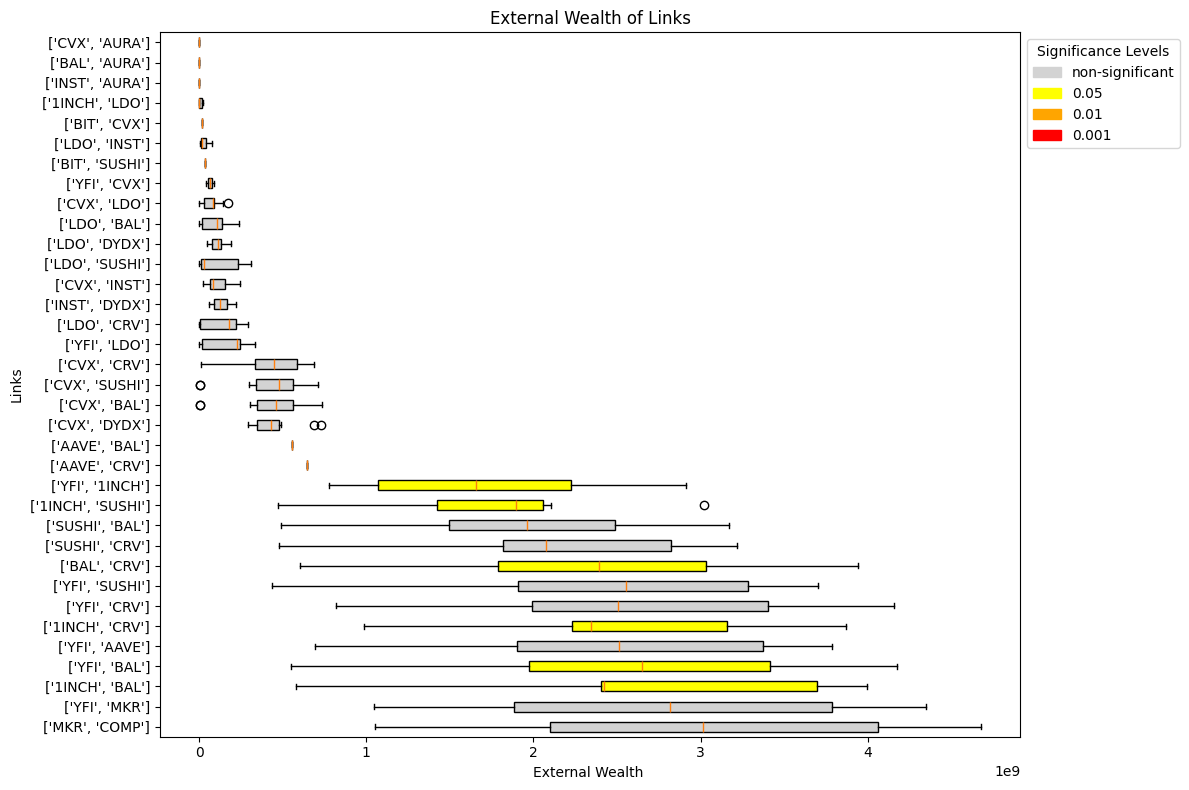

In [27]:
plot_boxplot_with_significance(metric_dataframes, metric='external_wealth', unit='', group='sample', output_path="../output/links/", save=True, show=True)


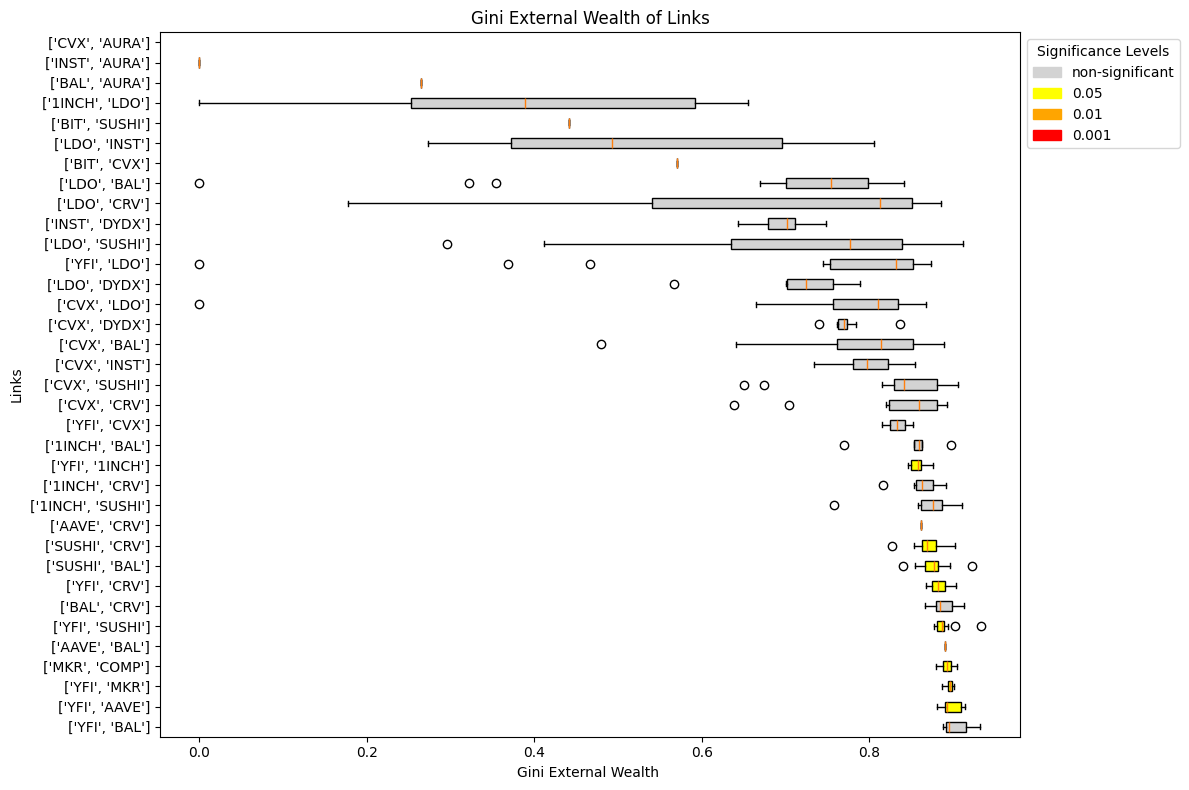

In [28]:
plot_boxplot_with_significance(metric_dataframes, metric='gini_external_wealth', unit='', group='sample', output_path="../output/links/", save=True, show=True)


### Fig: median_no_assets_link


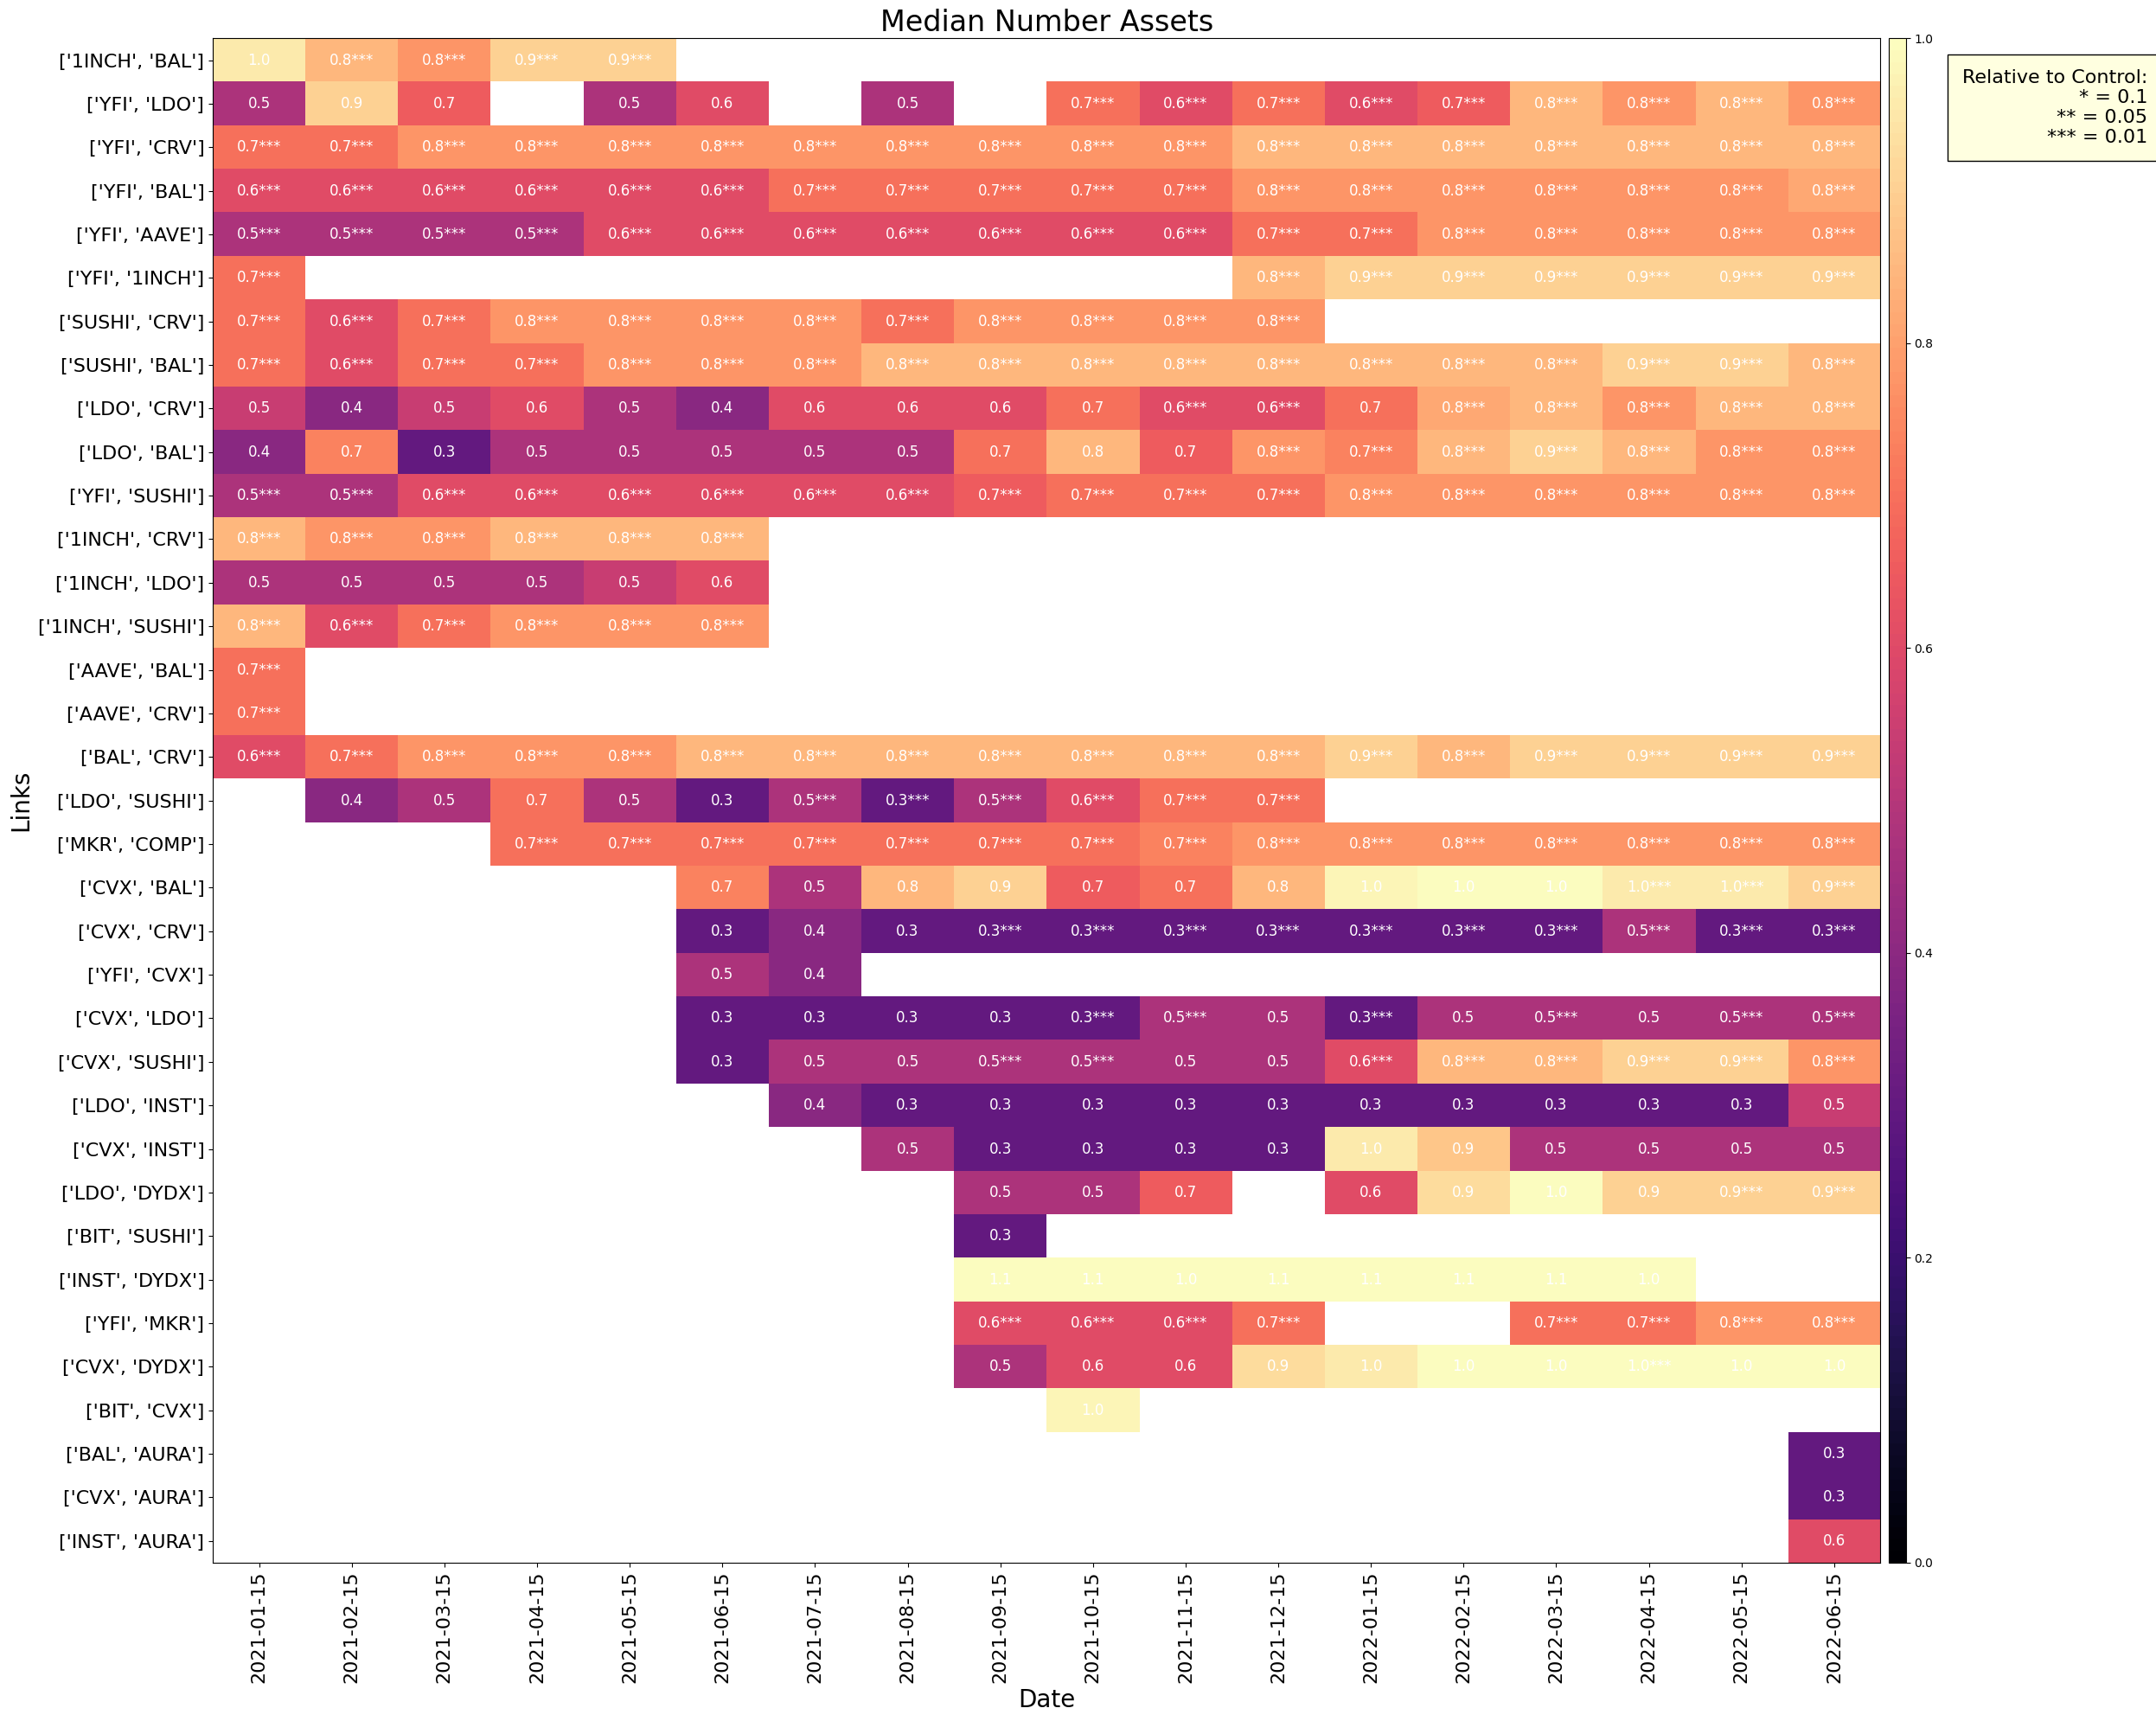

In [29]:
plot_heatmap_chart(metric_dataframes, metric_name='median_number_assets', pct=False, log=True, output_path="../output/links/", save=True, show=True)


# ISSUE: WHY DO WE HAVE LESS THAN 1 as MEDIAN

### Fig: Distribution of Labels

In [62]:
metric_dataframes['sample']['max_influence_label_distribution']


Date  level_0  index           Link Name  \
0           0      0    ['1INCH', 'BAL']   
1           1      1    ['1INCH', 'CRV']   
2           2      2    ['1INCH', 'LDO']   
3           3      3  ['1INCH', 'SUSHI']   
4           4      4     ['AAVE', 'BAL']   
5           5      5     ['AAVE', 'CRV']   
6           6      6     ['BAL', 'AURA']   
7           7      7      ['BAL', 'CRV']   
8           8      8      ['BIT', 'CVX']   
9           9      9    ['BIT', 'SUSHI']   
10         10     10     ['CVX', 'AURA']   
11         11     11      ['CVX', 'BAL']   
12         12     12      ['CVX', 'CRV']   
13         13     13     ['CVX', 'DYDX']   
14         14     14     ['CVX', 'INST']   
15         15     15      ['CVX', 'LDO']   
16         16     16    ['CVX', 'SUSHI']   
17         17     17    ['INST', 'AURA']   
18         18     18    ['INST', 'DYDX']   
19         19     19      ['LDO', 'BAL']   
20         20     20      ['LDO', 'CRV']   
21         21     21     ['LDO', 'DYDX']   
22         22     22     ['LDO', 'INST']   
23         23     23    ['LDO', 'SUSHI']   
24         24     24     ['MKR', 'COMP']   
25         25     25    ['SUSHI', 'BAL']   
26         26     26    ['SUSHI', 'CRV']   
27         27     27    ['YFI', '1INCH']   
28         28     28     ['YFI', 'AAVE']   
29         29     29      ['YFI', 'BAL']   
30         30     30      ['YFI', 'CRV']   
31         31     31      ['YFI', 'CVX']   
32         32     32      ['YFI', 'LDO']   
33         33     33      ['YFI', 'MKR']   
34         34     34    ['YFI', 'SUSHI']   

Date                                         2021-01-15  \
0     {'IEMOA': 0.036590619743982006, 'other_contrac...   
1     {'IEMOA': 0.056733260859137304, 'other_contrac...   
2               {'other_contracts': 3.812633615988e-05}   
3     {'IEMOA': 0.0365952367303979, 'bridge_contract...   
4     {'IEMOA': 0.03571283248950559, 'PCV': 0.000148...   
5     {'IEMOA': 0.056621151357204726, 'other_contrac...   
6                                                   NaN   
7     {'IEMOA': 0.03941719402125407, 'PCV': 3.219370...   
8                                                   NaN   
9                                                   NaN   
10                                                  NaN   
11                                                  NaN   
12                                                  NaN   
13                                                  NaN   
14                                                  NaN   
15                                                  NaN   
16                                                  NaN   
17                                                  NaN   
18                                                  NaN   
19           {'other_contracts': 4.815251437210172e-05}   
20    {'IEMOA': 9.069053471007552e-06, 'other_contra...   
21                                                  NaN   
22                                                  NaN   
23                                                  NaN   
24                                                  NaN   
25    {'IEMOA': 0.03700387973617422, 'other_contract...   
26    {'IEMOA': 0.03703033701537094, 'other_contract...   
27    {'IEMOA': 0.056714366647388645, 'bridge_contra...   
28    {'IEMOA': 0.058279160951002086, 'bridge_contra...   
29    {'IEMOA': 0.03987719844386048, 'other_contract...   
30    {'IEMOA': 0.0609631525354416, 'other_contracts...   
31                                                  NaN   
32    {'IEMOA': 9.069053471007552e-06, 'other_contra...   
33                                                  NaN   
34    {'IEMOA': 0.03886825986075089, 'bridge_contrac...   

Date                                         2021-02-15  \
0     {'EMOA': 8.846969177678239e-05, 'IEMOA': 0.053...   
1     {'EMOA': 7.499242589583893e-05, 'IEMOA': 0.053...   
2     {'IEMOA': 1.5131459920888503e-05, 'other_contr...   
3     {'IEMOA': 0.046318186370064275, 'bridge_contra..

In [67]:
def create_and_normalize_matrix(dataframe, label_column='Link Name', short_labels=None):
    """
    Create a normalized matrix from a dataframe with string-encoded dictionaries of influence labels.

    Args:
        dataframe (pd.DataFrame): The original dataframe.
        label_column (str): The name of the column to use as labels (default: 'Link Name').
        short_labels (dict): A dictionary for mapping original labels to human-readable labels.

    Returns:
        pd.DataFrame: The normalized and renamed dataframe.
    """
    def convert_str_to_dict(x):
        try:
            return ast.literal_eval(x) if isinstance(x, str) else (x if isinstance(x, dict) else {})
        except:
            return {}

    dataframe = dataframe.copy()
    for column in dataframe.columns.difference([label_column]):
        dataframe[column] = dataframe[column].apply(convert_str_to_dict)

    def extract_and_average(row):
        contract_sums = {}
        contract_counts = {}
        for cell in row:
            for contract, value in cell.items():
                if contract in contract_sums:
                    contract_sums[contract] += value
                    contract_counts[contract] += 1
                else:
                    contract_sums[contract] = value
                    contract_counts[contract] = 1
        return {contract: contract_sums[contract] / contract_counts[contract] for contract in contract_sums}

    dataframe['averages'] = dataframe[dataframe.columns.difference([label_column])].apply(extract_and_average, axis=1)

    matrix_df = pd.DataFrame(index=dataframe[label_column])
    for index, row in dataframe.iterrows():
        for contract, avg_value in row['averages'].items():
            matrix_df.at[row[label_column], contract] = avg_value
    matrix_df.fillna(0, inplace=True)

    row_sums = matrix_df.sum(axis=1).replace(0, np.nan)
    result_df = matrix_df.div(row_sums, axis=0).fillna(0)

    if short_labels:
        result_df.rename(columns=short_labels, inplace=True)
        result_df = result_df[[short_labels[key] for key in short_labels if short_labels[key] in result_df.columns]]


    return result_df


def plot_heatmap_labels(metric_dataframes, group='sample', colormap='magma', output_path='output/links', min_occurrences=9):
    """
    Plot a heatmap from a dataframe, filtering links with a minimum number of occurrences.

    Args:
        metric_dataframes (dict): A dictionary containing dataframes to plot.
        group (str): The group to select from the metric_dataframes.
        colormap (str): The colormap to use for the heatmap.
        output_path (str): The directory to save the heatmap.
        min_occurrences (int): The minimum number of occurrences required to keep a link (default: 9).

    Returns:
        None
    """
    
    short_readable_labels = {
        'EMOA': 'EOA Addresses',
        'IEMOA': 'Institutional Addresses',
        'PCV': 'Protocol Addresses',
        'vesting_contract': 'Vesting Contracts',
        'external_staking_contracts': 'Staking Contracts',
        'lp_amm': 'Liquidity Pools',
        'lending_borrowing_contract': 'Lending/Borrowing Contracts',
        'bridge_contract': 'Bridge Contracts',
        'other_contracts': 'Other Contracts',
    }
    
    # Get the raw data for the specified group
    df_raw = metric_dataframes[group]['max_influence_label_distribution']
    # df_raw.reset_index(inplace=True)

    # Filter for links with at least `min_occurrences` non-NaN values
    df_raw.set_index('Link Name', inplace=True)
    link_occurrences = df_raw.notna().sum(axis=1)
    df_filtered = df_raw[link_occurrences >= min_occurrences]

    # Create and normalize the matrix using the filtered DataFrame
    df = create_and_normalize_matrix(df_filtered.reset_index(), label_column='Link Name', short_labels=short_readable_labels)
    
    # Check if the dataframe is empty after filtering
    if df.empty:
        print(f"No data to plot after filtering for {group} group.")
        return  # Exit the function if there's no data to plot

    # Proceed with plotting if the DataFrame is not empty
    fig, ax = plt.subplots(figsize=(20,16))
    data = df.to_numpy() * 100

    cax = ax.matshow(data, cmap=colormap, aspect='auto')
    fig.colorbar(cax, ax=ax).ax.tick_params(labelsize=14)

    ax.set_xlabel('Labels', fontsize=18)
    ax.set_ylabel('Links', fontsize=18)
    
    ax.set_title('Relative Control for Links of Total Influence by Label per Link', fontsize=22)

    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation=90, ha='right', size=16)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(df.index, size=16)
    ax.tick_params(axis='x', bottom=True, top=False, labelbottom=True)

    # Set a threshold for text color based on the maximum value in the data
    text_color_threshold = np.max(data) / 2
    for (i, j), val in np.ndenumerate(data):
        ax.text(j, i, f'{val:.1f}%', ha='center', va='center',
                color='white' if val < text_color_threshold else 'black', fontsize=14)

    # Save plot
    plt.savefig(f"{output_path}/label_plot_links.png", bbox_inches='tight')
    plt.show()


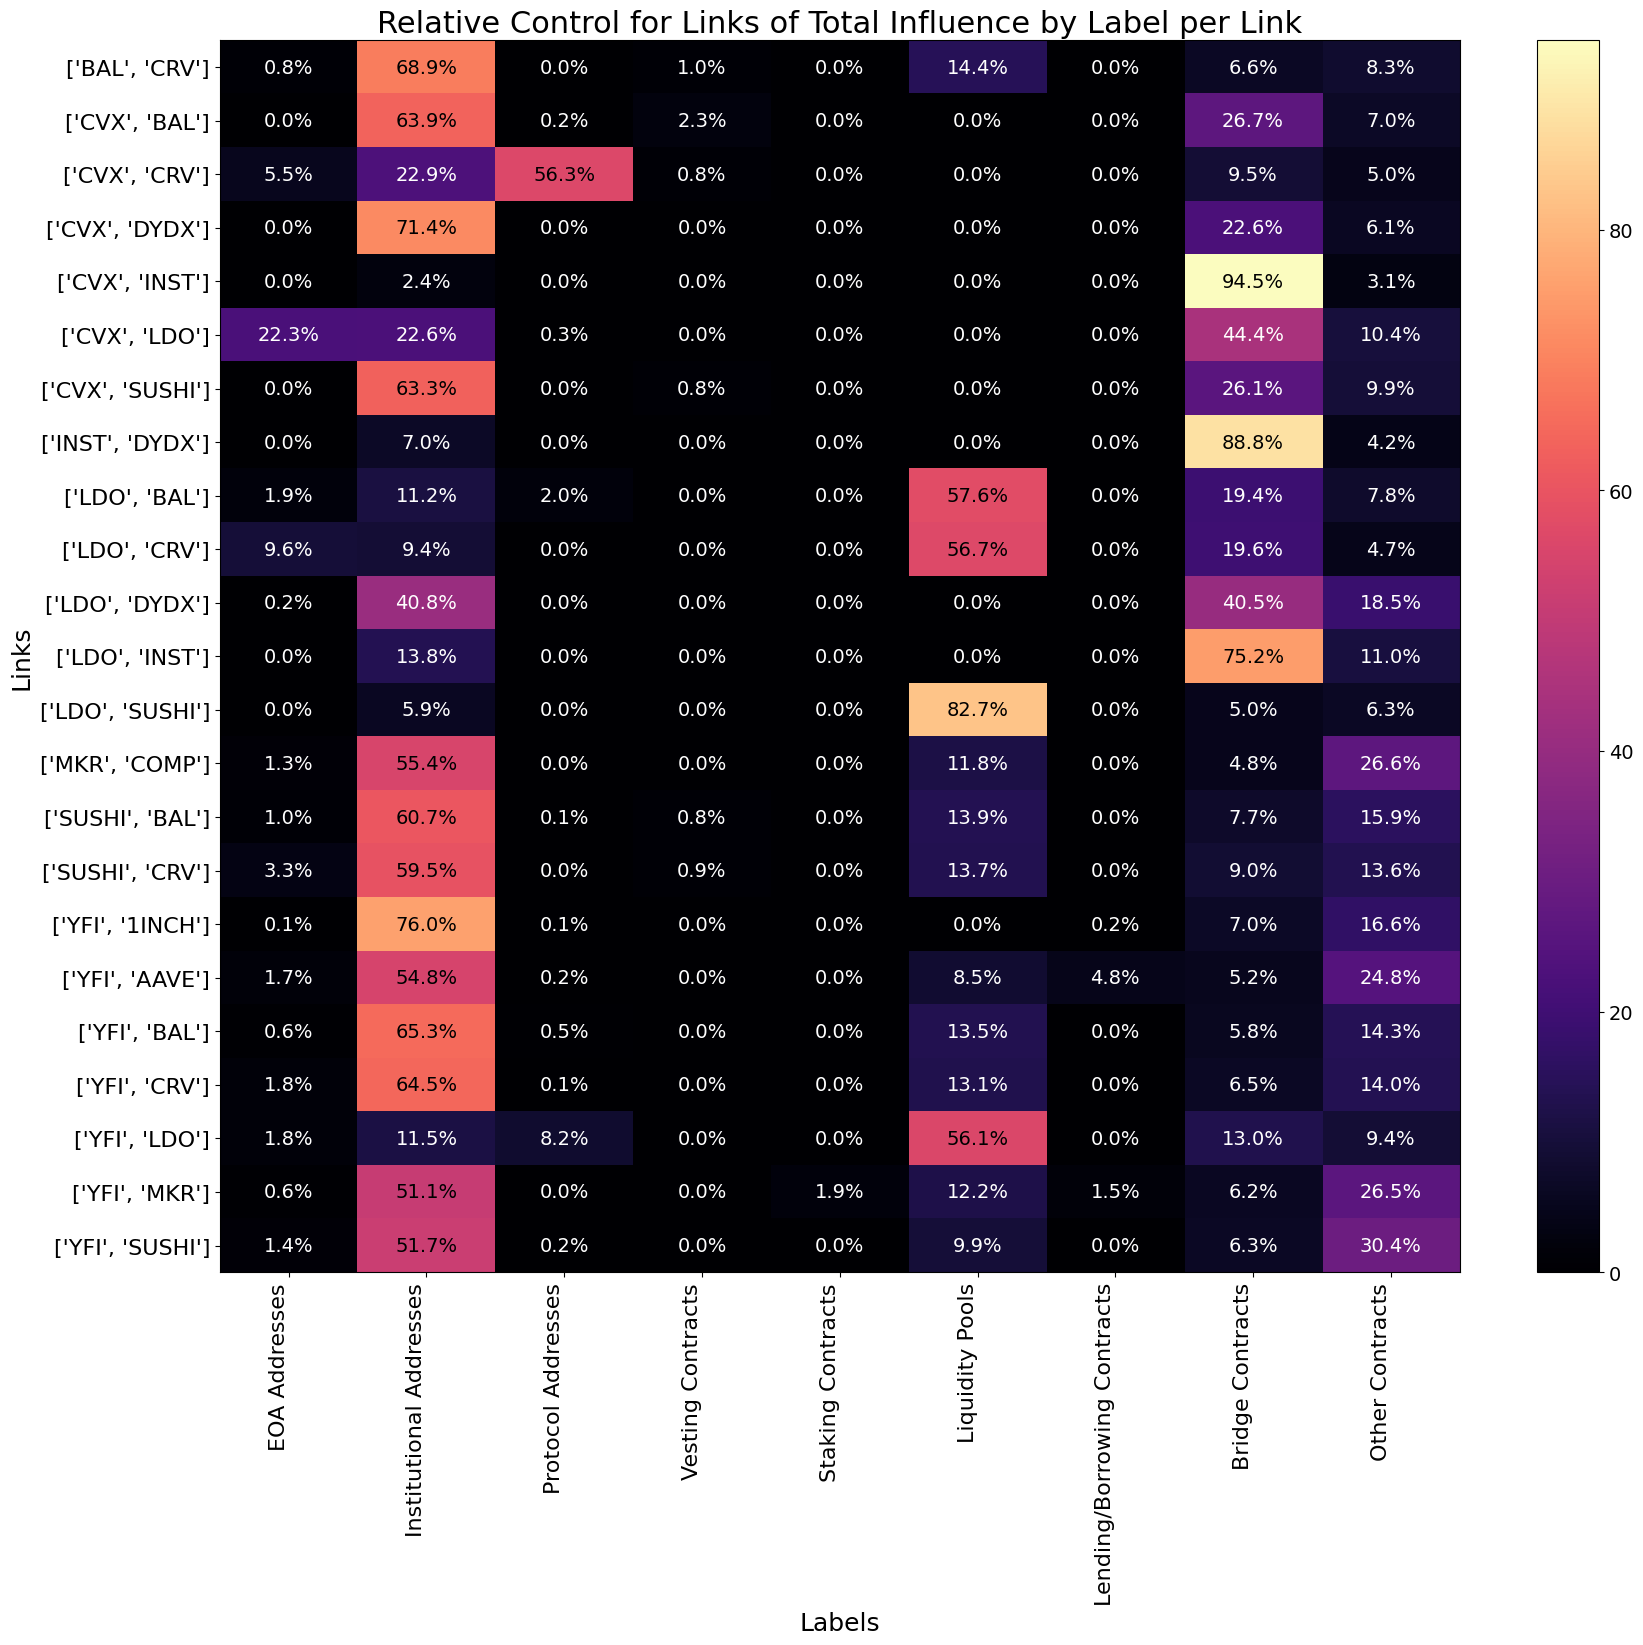

In [68]:
plot_heatmap_labels(metric_dataframes, group='sample', colormap='magma', output_path='../output/links')

### Sensitivity Analysis 

In [31]:
import pandas as pd
import numpy as np
import pickle
import sys

# Define a function to load pickle files with dynamic module path adjustment
def load_pickle_dynamic(file_path):
    sys.modules['numpy._core'] = np.core
    with open(file_path, 'rb') as file:
        try:
            data = pickle.load(file)
        except ModuleNotFoundError as e:
            print(f"ModuleNotFoundError: {e}")
            data = pickle.load(file, encoding='latin1')
    return data

# List of file paths
file_paths = [
    "../output/links/metrics/links_data_0.005.pkl",
    "../output/links/metrics/links_data_0.05.pkl",
    "../output/links/metrics/links_data_5e-05.pkl",
    "../output/links/metrics/links_data_5e-06.pkl",
    "../output/links/metrics/links_data_5e-07.pkl",
    "../output/links/metrics/links_data_0.0005.pkl"
]

# Load the pickle files using the dynamic function
data_frames = {path: load_pickle_dynamic(path) for path in file_paths}



In [32]:
# Extract 'total influence' from the nested data structure
total_influence_records = []

for path, data in data_frames.items():
    for date, pairs in data['sample'].items():
        for pair, metrics in pairs.items():
            total_influence = metrics['total_influence']
            total_influence_records.append({
                'file': path,
                'date': date,
                'pair': pair,
                'total_influence': total_influence
            })

# Convert to DataFrame
df = pd.DataFrame(total_influence_records)

In [33]:
df

file        date  \
0      ../output/links/metrics/links_data_0.005.pkl  2021-01-15   
1      ../output/links/metrics/links_data_0.005.pkl  2021-01-15   
2      ../output/links/metrics/links_data_0.005.pkl  2021-01-15   
3      ../output/links/metrics/links_data_0.005.pkl  2021-01-15   
4      ../output/links/metrics/links_data_0.005.pkl  2021-01-15   
...                                             ...         ...   
1450  ../output/links/metrics/links_data_0.0005.pkl  2022-06-15   
1451  ../output/links/metrics/links_data_0.0005.pkl  2022-06-15   
1452  ../output/links/metrics/links_data_0.0005.pkl  2022-06-15   
1453  ../output/links/metrics/links_data_0.0005.pkl  2022-06-15   
1454  ../output/links/metrics/links_data_0.0005.pkl  2022-06-15   

                  pair  total_influence  
0     ['YFI', 'SUSHI']         0.021409  
1      ['YFI', 'AAVE']         0.059057  
2       ['YFI', 'CRV']         0.031666  
3     ['SUSHI', 'CRV']         0.011905  
4      ['AAVE', 'CRV']         0.029008  
...                ...              ...  
1450    ['CVX', 'BAL']         0.012975  
1451    ['LDO', 'BAL']         0.026286  
1452    ['CVX', 'LDO']         0.006881  
1453   ['LDO', 'DYDX']         0.007765  
1454   ['CVX', 'DYDX']         0.012975  

[1455 rows x 4 columns]

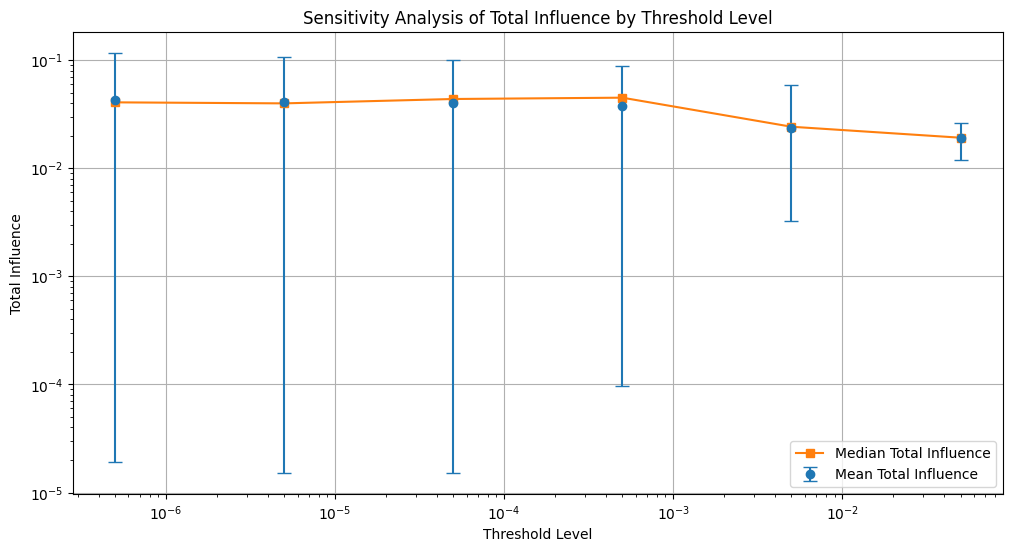

In [34]:
import pandas as pd
import matplotlib.pyplot as plt



# Extract threshold levels from the 'file' column
df['threshold'] = df['file'].str.extract(r'links_data_(.+)\.pkl')

# Convert 'threshold' to a numeric value for sorting
df['threshold'] = pd.to_numeric(df['threshold'], errors='coerce')

# Calculate summary statistics for total_influence by threshold level
summary_stats = df.groupby('threshold')['total_influence'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).reset_index()

# Ensure all relevant columns are numeric
summary_stats['threshold'] = summary_stats['threshold'].astype(float)
summary_stats['mean'] = summary_stats['mean'].astype(float)
summary_stats['median'] = summary_stats['median'].astype(float)
summary_stats['min'] = summary_stats['min'].astype(float)
summary_stats['max'] = summary_stats['max'].astype(float)

# Calculate error bars (difference between mean and min/max)
summary_stats['error_min'] = summary_stats['mean'] - summary_stats['min']
summary_stats['error_max'] = summary_stats['max'] - summary_stats['mean']

# Plot mean and median total_influence by threshold level
plt.figure(figsize=(12, 6))
plt.errorbar(summary_stats['threshold'], summary_stats['mean'], 
             yerr=[summary_stats['error_min'], summary_stats['error_max']], 
             fmt='o', label='Mean Total Influence', capsize=5)
plt.plot(summary_stats['threshold'], summary_stats['median'], 's-', label='Median Total Influence')

plt.xlabel('Threshold Level')
plt.ylabel('Total Influence')
plt.title('Sensitivity Analysis of Total Influence by Threshold Level')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()


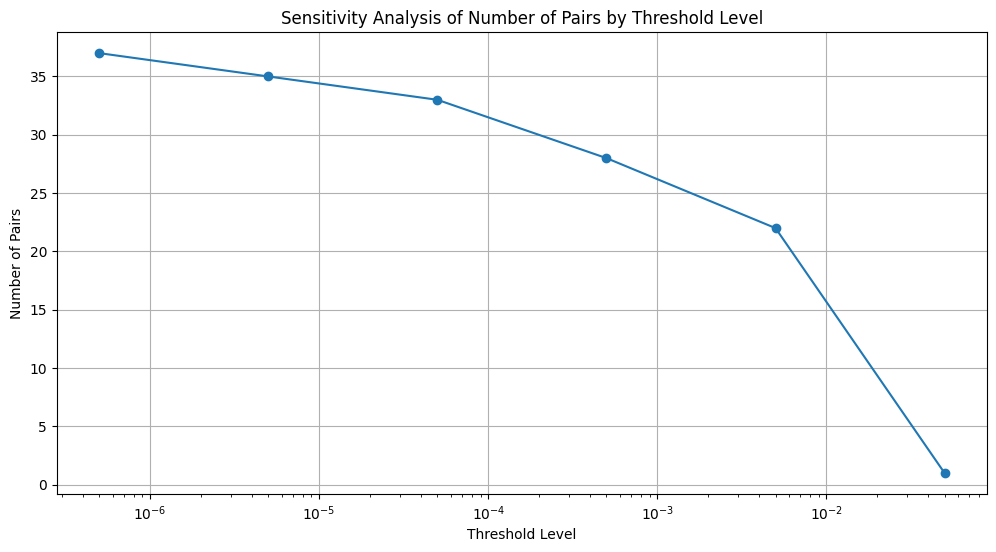

In [35]:
# Extract threshold levels from the 'file' column
df['threshold'] = df['file'].str.extract(r'links_data_(.+)\.pkl')

# Convert 'threshold' to a numeric value for sorting
df['threshold'] = pd.to_numeric(df['threshold'], errors='coerce')

# Count the number of unique pairs for each threshold level
pair_counts = df.groupby('threshold')['pair'].nunique().reset_index()
pair_counts.columns = ['threshold', 'pair_count']

# Ensure the threshold levels are treated as numeric
pair_counts['threshold'] = pair_counts['threshold'].astype(float)

# Plot the number of pairs for each threshold level
plt.figure(figsize=(12, 6))
plt.plot(pair_counts['threshold'], pair_counts['pair_count'], marker='o', linestyle='-')
plt.xlabel('Threshold Level')
plt.ylabel('Number of Pairs')
plt.title('Sensitivity Analysis of Number of Pairs by Threshold Level')
plt.xscale('log')
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

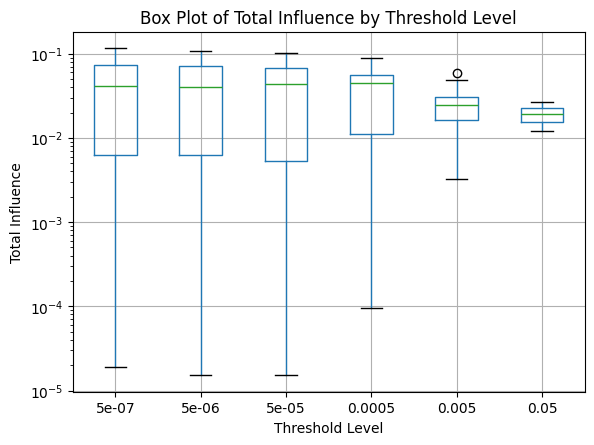

In [36]:
# Extract threshold levels from the 'file' column
df['threshold'] = df['file'].str.extract(r'links_data_(.+)\.pkl')

# Convert 'threshold' to a numeric value for sorting
df['threshold'] = pd.to_numeric(df['threshold'], errors='coerce')

# Plotting a box plot for total_influence by threshold level
plt.figure(figsize=(12, 6))
df.boxplot(column='total_influence', by='threshold', grid=True)
plt.xlabel('Threshold Level')
plt.ylabel('Total Influence')
plt.title('Box Plot of Total Influence by Threshold Level')
plt.suptitle('')  # Suppress the default title to make the plot clearer
plt.yscale('log')
plt.show()

In [37]:
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt

# Define a function to load pickle files with dynamic module path adjustment
def load_pickle_dynamic(file_path):
    sys.modules['numpy._core'] = np.core
    with open(file_path, 'rb') as file:
        try:
            data = pickle.load(file)
        except ModuleNotFoundError as e:
            print(f"ModuleNotFoundError: {e}")
            data = pickle.load(file, encoding='latin1')
    return data

# List of file paths
file_paths = [
    "../output/links/metrics/links_data_0.005.pkl",
    "../output/links/metrics/links_data_0.05.pkl",
    "../output/links/metrics/links_data_5e-05.pkl",
    "../output/links/metrics/links_data_5e-06.pkl",
    "../output/links/metrics/links_data_5e-07.pkl",
    "../output/links/metrics/links_data_0.0005.pkl"
]

# Load the pickle files using the dynamic function
data_frames = {path: load_pickle_dynamic(path) for path in file_paths}

# Combine data into a single DataFrame for easier analysis
combined_data = []

for path, data in data_frames.items():
    threshold = path.split('_')[-1].split('.pkl')[0]  # Extract threshold level from the file path
    threshold = threshold.replace('e-', 'e-')  # Ensure proper formatting
    for date, pairs in data['sample'].items():
        for pair, metrics in pairs.items():
            metrics['threshold'] = threshold
            metrics['date'] = date
            metrics['pair'] = pair
            combined_data.append(metrics)



In [38]:
combined_df = pd.DataFrame(combined_data)

# Convert threshold to numeric and sort
combined_df['threshold'] = pd.to_numeric(combined_df['threshold'], errors='coerce')
# combined_df = combined_df.dropna(subset=['threshold'])  # Drop rows with NaN thresholds
combined_df = combined_df.sort_values(by='threshold')

# List of metrics to plot
metrics = ['size', 'median_number_assets', 'total_influence', 'gini_total_influence', 
           'internal_influence', 'gini_internal_influence', 
           'external_influence', 'gini_external_influence',  'median_influence', 'median_wealth', 'total_wealth', 
           'gini_total_wealth', 'internal_wealth', 
           'gini_internal_wealth', 'external_wealth', 'gini_external_wealth']




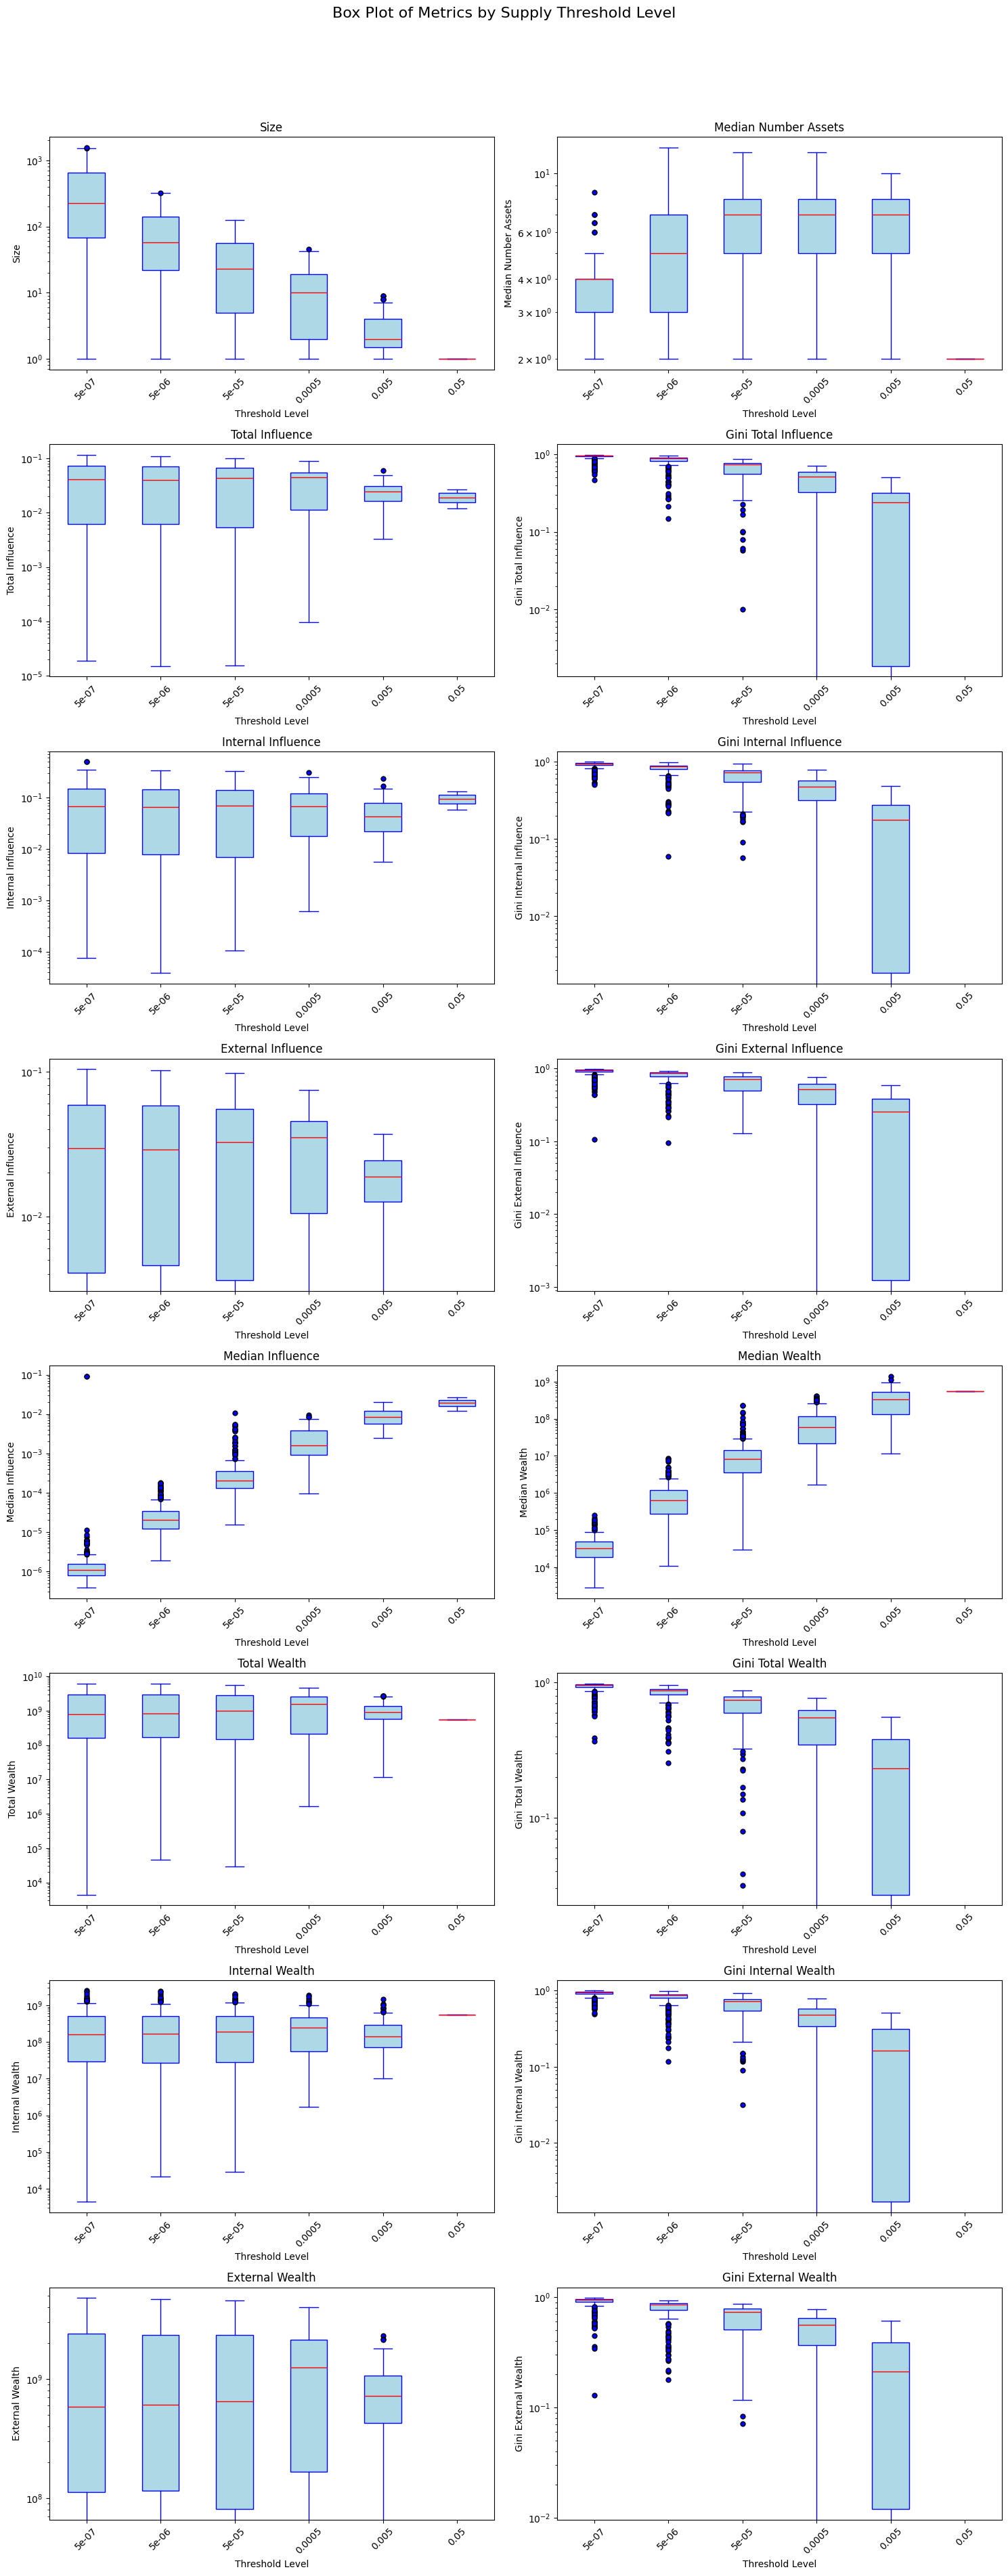

In [39]:
# Determine number of rows and columns for subplots
n_metrics = len(metrics)
n_cols = 2
n_rows = (n_metrics + n_cols - 1) // n_cols

# Generate box plots for each metric across different threshold levels
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

highlight_threshold = '5e-06'#0.000005

for i, metric in enumerate(metrics):
    ax = axes[i]
    boxplot = combined_df.boxplot(column=metric, by='threshold', grid=False, patch_artist=True,
                                  boxprops=dict(facecolor='lightblue', color='blue'),
                                  medianprops=dict(color='red'),
                                  whiskerprops=dict(color='blue'),
                                  capprops=dict(color='blue'),
                                  flierprops=dict(markerfacecolor='blue', marker='o', markersize=5),
                                  ax=ax)
    
    # Highlight the specific threshold
    for j, line in enumerate(ax.artists):
        threshold_value = combined_df['threshold'].unique()[j]
        if threshold_value == highlight_threshold:
            line.set_facecolor('orange')
    
    ax.set_xlabel('Threshold Level')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()}')
    ax.set_yscale('log')
    ax.tick_params(axis='x', rotation=45)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Box Plot of Metrics by Supply Threshold Level', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()